In [1]:
# CLEANED VERSION OF GRAPH CREATION WITH COMMENTS
# This notebook uses the CoDeTM4Cleaned dataset to avoid data leakage



In [2]:

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [3]:




from data.dataset.codet_m4_cleaned import CoDeTM4Cleaned


In [4]:



train, val, test  = CoDeTM4Cleaned('../../data/codet_cleaned_20250812_201438/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)




2025-09-03 22:42:35,054 - INFO - Initialized CoDeTM4Cleaned with cleaned data from: ../../data/codet_cleaned_20250812_201438/


2025-09-03 22:42:35,230 - INFO - Loaded train split: 405069 samples


2025-09-03 22:42:35,242 - INFO - Loaded val split: 47035 samples


2025-09-03 22:42:35,253 - INFO - Loaded test split: 47046 samples


In [5]:

from datasets import concatenate_datasets



In [6]:


codet = concatenate_datasets([train, val, test])



In [7]:


import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

# Enable comment parsing by setting `parser.set_included_ranges` with full range of the source code
# This is a workaround: tree-sitter parsers by default include comments as nodes, 
# so no extra flag is needed, but if previously you filtered comments, do not filter now.



import matplotlib.pyplot as plt



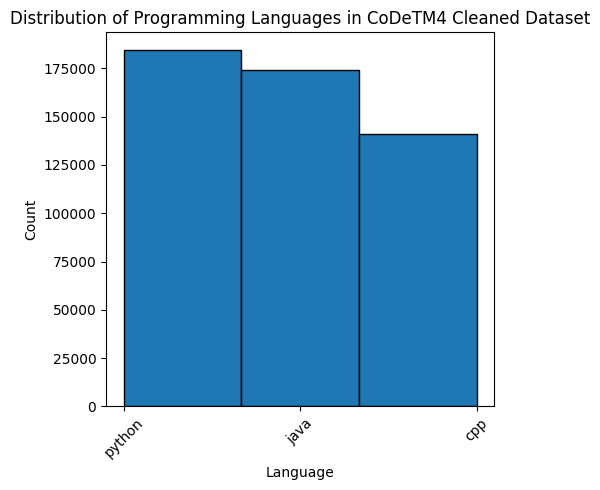

Python count: 184419
Java count: 173917
C++ count: 140814


In [8]:


language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Cleaned Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')



In [9]:


def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")




In [10]:

def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    # Include full range to keep comments included
    code_bytes = bytes(sample[code_key], 'utf-8')
    # Use full range
    #parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # Reset included ranges to None after parse to avoid side effects
    #parser.set_included_ranges(None)
    return tree



In [11]:


from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()



In [12]:


from typing import Set


In [13]:

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types




In [14]:

def extract_types(sample):
    # Import everything needed inside the function
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    parser = get_parser(sample['language'])
    code_bytes = sample['code'].encode('utf-8')
    # parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # parser.set_included_ranges(None)
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}


In [15]:

result = codet.map(extract_types, batched=False, num_proc=8)


Map (num_proc=8):   0%|          | 0/499150 [00:00<?, ? examples/s]

In [16]:

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)


In [17]:

print(f"Collected {len(all_types)} unique node types")



Collected 565 unique node types


In [18]:


all_types = sorted(list(all_types))



In [19]:


type_to_ind = {t: i for i, t in enumerate(all_types)}



In [20]:


len(all_types)



565

In [21]:

for t in all_types:
    print(t)




!
!=
"
""
#define
#elif
#else
#endif
#if
#ifdef
#ifndef
#include
%
%=
&
&&
&=
'
(
()
)
*
**
**=
*=
+
++
+=
,
-
--
-=
->
.
.*
...
/
//
//=
/=
:
::
:=
;
<
<<
<<=
<=
<=>
<>
=
==
>
>=
>>
>>=
>>>
>>>=
?
@
@interface
ERROR
L"
L'
NULL
R"
U"
[
[[
[]
\
]
]]
^
^=
_
__asm
__asm__
__attribute
__attribute__
__future__
__inline
__restrict__
__volatile__
abstract
abstract_array_declarator
abstract_function_declarator
abstract_parenthesized_declarator
abstract_pointer_declarator
abstract_reference_declarator
access_specifier
alias_declaration
aliased_import
alignas
alignas_qualifier
alignof
alignof_expression
and
annotated_type
annotation
annotation_argument_list
annotation_type_body
annotation_type_declaration
annotation_type_element_declaration
argument_list
array_access
array_creation_expression
array_declarator
array_initializer
array_type
as
as_pattern
as_pattern_target
asm
assert
assert_statement
assignment
assignment_expression
asterisk
async
attribute
attribute_declaration
attribute_specifie

In [22]:


from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node



In [23]:


from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor


In [24]:

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id



In [25]:


from tqdm import tqdm



In [26]:


def create_graph(sample, code_key='cleaned_code'):
    tree = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target_binary']], dtype=tlong)

    graph_features = tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data





In [27]:

codet



Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 499150
})

In [28]:


def create_graphs(dataset, desc_keyword, code_key='cleaned_code'):
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample, code_key)
        graphs.append(data)

    return graphs
    


In [29]:



from torch_geometric.data import Data
from torch import save
import gc


In [30]:

train_graphs = create_graphs(train, 'train', 'code')
save(train_graphs, '../../data/codet_graphs/train_graphs_cleaned_comments.pt')
del train, train_graphs
gc.collect()
val_graphs = create_graphs(val, 'val', 'code')
save(val_graphs, '../../data/codet_graphs/val_graphs_cleaned_comments.pt')
del val, val_graphs
gc.collect()
test_graphs = create_graphs(test, 'test', 'code')
save(test_graphs, '../../data/codet_graphs/test_graphs_cleaned_comments.pt')
del test, test_graphs
gc.collect()
save(type_to_ind, '../../data/codet_graphs/type_to_ind_cleaned_comments.pt')


Creating train graphs:   0%|                                                                | 0/405069 [00:00<?, ?it/s]

Creating train graphs:   0%|                                                    | 208/405069 [00:00<03:14, 2079.99it/s]

Creating train graphs:   0%|                                                    | 435/405069 [00:00<03:05, 2178.95it/s]

Creating train graphs:   0%|                                                    | 653/405069 [00:00<03:14, 2084.54it/s]

Creating train graphs:   0%|                                                    | 869/405069 [00:00<03:11, 2105.41it/s]

Creating train graphs:   0%|▏                                                  | 1099/405069 [00:00<03:05, 2174.05it/s]

Creating train graphs:   0%|▏                                                  | 1317/405069 [00:00<03:08, 2140.16it/s]

Creating train graphs:   0%|▏                                                  | 1532/405069 [00:00<03:09, 2129.68it/s]

Creating train graphs:   0%|▏                                                  | 1746/405069 [00:00<03:09, 2132.90it/s]

Creating train graphs:   0%|▏                                                  | 1965/405069 [00:00<03:08, 2143.91it/s]

Creating train graphs:   1%|▎                                                  | 2180/405069 [00:01<03:08, 2132.74it/s]

Creating train graphs:   1%|▎                                                  | 2394/405069 [00:01<03:14, 2072.26it/s]

Creating train graphs:   1%|▎                                                  | 2602/405069 [00:01<03:14, 2068.43it/s]

Creating train graphs:   1%|▎                                                  | 2815/405069 [00:01<03:13, 2080.51it/s]

Creating train graphs:   1%|▍                                                  | 3029/405069 [00:01<03:12, 2091.96it/s]

Creating train graphs:   1%|▍                                                  | 3240/405069 [00:01<03:12, 2091.11it/s]

Creating train graphs:   1%|▍                                                  | 3456/405069 [00:01<03:10, 2111.59it/s]

Creating train graphs:   1%|▍                                                  | 3668/405069 [00:01<03:09, 2114.09it/s]

Creating train graphs:   1%|▍                                                  | 3900/405069 [00:01<03:04, 2169.12it/s]

Creating train graphs:   1%|▌                                                  | 4139/405069 [00:01<02:59, 2228.38it/s]

Creating train graphs:   1%|▌                                                  | 4362/405069 [00:02<03:04, 2170.60it/s]

Creating train graphs:   1%|▌                                                  | 4580/405069 [00:02<03:09, 2117.46it/s]

Creating train graphs:   1%|▌                                                  | 4793/405069 [00:02<03:11, 2090.80it/s]

Creating train graphs:   1%|▋                                                  | 5010/405069 [00:02<03:09, 2113.75it/s]

Creating train graphs:   1%|▋                                                  | 5229/405069 [00:02<03:07, 2136.08it/s]

Creating train graphs:   1%|▋                                                  | 5443/405069 [00:02<03:08, 2124.71it/s]

Creating train graphs:   1%|▋                                                  | 5677/405069 [00:02<03:03, 2181.82it/s]

Creating train graphs:   1%|▋                                                  | 5896/405069 [00:02<03:03, 2177.80it/s]

Creating train graphs:   2%|▊                                                  | 6114/405069 [00:02<03:05, 2152.91it/s]

Creating train graphs:   2%|▊                                                  | 6347/405069 [00:02<03:01, 2198.69it/s]

Creating train graphs:   2%|▊                                                  | 6567/405069 [00:03<04:06, 1615.68it/s]

Creating train graphs:   2%|▊                                                  | 6794/405069 [00:03<03:45, 1770.00it/s]

Creating train graphs:   2%|▉                                                  | 7001/405069 [00:03<03:36, 1841.20it/s]

Creating train graphs:   2%|▉                                                  | 7218/405069 [00:03<03:26, 1928.30it/s]

Creating train graphs:   2%|▉                                                  | 7444/405069 [00:03<03:17, 2013.83it/s]

Creating train graphs:   2%|▉                                                  | 7667/405069 [00:03<03:12, 2068.79it/s]

Creating train graphs:   2%|▉                                                  | 7896/405069 [00:03<03:06, 2125.97it/s]

Creating train graphs:   2%|█                                                  | 8114/405069 [00:03<03:06, 2123.18it/s]

Creating train graphs:   2%|█                                                  | 8336/405069 [00:03<03:04, 2151.33it/s]

Creating train graphs:   2%|█                                                  | 8554/405069 [00:04<03:04, 2147.14it/s]

Creating train graphs:   2%|█                                                  | 8779/405069 [00:04<03:02, 2176.32it/s]

Creating train graphs:   2%|█▏                                                 | 8998/405069 [00:04<03:07, 2117.73it/s]

Creating train graphs:   2%|█▏                                                 | 9224/405069 [00:04<03:03, 2152.86it/s]

Creating train graphs:   2%|█▏                                                 | 9441/405069 [00:04<03:05, 2132.89it/s]

Creating train graphs:   2%|█▏                                                 | 9658/405069 [00:04<03:04, 2143.74it/s]

Creating train graphs:   2%|█▏                                                 | 9873/405069 [00:04<03:05, 2126.76it/s]

Creating train graphs:   2%|█▏                                                | 10088/405069 [00:04<03:05, 2127.35it/s]

Creating train graphs:   3%|█▎                                                | 10301/405069 [00:04<03:08, 2097.16it/s]

Creating train graphs:   3%|█▎                                                | 10511/405069 [00:05<03:14, 2032.31it/s]

Creating train graphs:   3%|█▎                                                | 10731/405069 [00:05<03:10, 2074.78it/s]

Creating train graphs:   3%|█▎                                                | 10949/405069 [00:05<03:07, 2099.35it/s]

Creating train graphs:   3%|█▍                                                | 11165/405069 [00:05<03:06, 2115.46it/s]

Creating train graphs:   3%|█▍                                                | 11377/405069 [00:05<03:06, 2107.38it/s]

Creating train graphs:   3%|█▍                                                | 11594/405069 [00:05<03:05, 2125.85it/s]

Creating train graphs:   3%|█▍                                                | 11807/405069 [00:05<03:05, 2114.48it/s]

Creating train graphs:   3%|█▍                                                | 12019/405069 [00:05<03:05, 2116.06it/s]

Creating train graphs:   3%|█▌                                                | 12247/405069 [00:05<03:01, 2158.43it/s]

Creating train graphs:   3%|█▌                                                | 12474/405069 [00:05<02:59, 2191.60it/s]

Creating train graphs:   3%|█▌                                                | 12703/405069 [00:06<02:56, 2220.89it/s]

Creating train graphs:   3%|█▌                                                | 12926/405069 [00:06<02:58, 2197.29it/s]

Creating train graphs:   3%|█▌                                                | 13155/405069 [00:06<02:56, 2224.75it/s]

Creating train graphs:   3%|█▋                                                | 13378/405069 [00:06<03:00, 2168.17it/s]

Creating train graphs:   3%|█▋                                                | 13596/405069 [00:06<03:03, 2134.08it/s]

Creating train graphs:   3%|█▋                                                | 13810/405069 [00:06<03:04, 2120.67it/s]

Creating train graphs:   3%|█▋                                                | 14023/405069 [00:06<03:06, 2092.75it/s]

Creating train graphs:   4%|█▊                                                | 14233/405069 [00:06<03:09, 2058.79it/s]

Creating train graphs:   4%|█▊                                                | 14440/405069 [00:06<03:11, 2044.91it/s]

Creating train graphs:   4%|█▊                                                | 14663/405069 [00:06<03:06, 2098.83it/s]

Creating train graphs:   4%|█▊                                                | 14895/405069 [00:07<03:00, 2163.81it/s]

Creating train graphs:   4%|█▊                                                | 15112/405069 [00:07<03:03, 2121.65it/s]

Creating train graphs:   4%|█▉                                                | 15325/405069 [00:07<03:06, 2087.39it/s]

Creating train graphs:   4%|█▉                                                | 15535/405069 [00:07<03:07, 2078.90it/s]

Creating train graphs:   4%|█▉                                                | 15744/405069 [00:07<03:09, 2052.07it/s]

Creating train graphs:   4%|█▉                                                | 15972/405069 [00:07<03:03, 2118.57it/s]

Creating train graphs:   4%|██                                                | 16206/405069 [00:07<02:58, 2183.67it/s]

Creating train graphs:   4%|██                                                | 16425/405069 [00:07<03:00, 2147.36it/s]

Creating train graphs:   4%|██                                                | 16662/405069 [00:07<02:55, 2206.92it/s]

Creating train graphs:   4%|██                                                | 16884/405069 [00:08<02:58, 2178.57it/s]

Creating train graphs:   4%|██                                                | 17103/405069 [00:08<02:59, 2162.84it/s]

Creating train graphs:   4%|██▏                                               | 17332/405069 [00:08<02:56, 2200.11it/s]

Creating train graphs:   4%|██▏                                               | 17555/405069 [00:08<02:55, 2208.88it/s]

Creating train graphs:   4%|██▏                                               | 17778/405069 [00:08<02:55, 2210.09it/s]

Creating train graphs:   4%|██▏                                               | 18000/405069 [00:08<03:00, 2149.16it/s]

Creating train graphs:   5%|██▎                                               | 18231/405069 [00:08<02:56, 2196.12it/s]

Creating train graphs:   5%|██▎                                               | 18452/405069 [00:08<02:56, 2193.74it/s]

Creating train graphs:   5%|██▎                                               | 18672/405069 [00:08<03:03, 2102.43it/s]

Creating train graphs:   5%|██▎                                               | 18891/405069 [00:08<03:02, 2121.53it/s]

Creating train graphs:   5%|██▎                                               | 19104/405069 [00:09<03:03, 2099.57it/s]

Creating train graphs:   5%|██▍                                               | 19338/405069 [00:09<02:58, 2163.26it/s]

Creating train graphs:   5%|██▍                                               | 19555/405069 [00:09<04:21, 1473.99it/s]

Creating train graphs:   5%|██▍                                               | 19769/405069 [00:09<03:58, 1618.14it/s]

Creating train graphs:   5%|██▍                                               | 19984/405069 [00:09<03:43, 1725.18it/s]

Creating train graphs:   5%|██▍                                               | 20187/405069 [00:09<03:34, 1797.82it/s]

Creating train graphs:   5%|██▌                                               | 20393/405069 [00:09<03:26, 1862.40it/s]

Creating train graphs:   5%|██▌                                               | 20610/405069 [00:09<03:18, 1941.42it/s]

Creating train graphs:   5%|██▌                                               | 20840/405069 [00:10<03:08, 2042.15it/s]

Creating train graphs:   5%|██▌                                               | 21052/405069 [00:10<03:10, 2018.21it/s]

Creating train graphs:   5%|██▋                                               | 21275/405069 [00:10<03:04, 2078.72it/s]

Creating train graphs:   5%|██▋                                               | 21487/405069 [00:10<03:04, 2078.63it/s]

Creating train graphs:   5%|██▋                                               | 21711/405069 [00:10<03:00, 2119.50it/s]

Creating train graphs:   5%|██▋                                               | 21925/405069 [00:10<03:05, 2070.83it/s]

Creating train graphs:   5%|██▋                                               | 22153/405069 [00:10<02:59, 2131.49it/s]

Creating train graphs:   6%|██▊                                               | 22375/405069 [00:10<02:57, 2157.42it/s]

Creating train graphs:   6%|██▊                                               | 22603/405069 [00:10<02:54, 2187.13it/s]

Creating train graphs:   6%|██▊                                               | 22827/405069 [00:10<02:53, 2202.77it/s]

Creating train graphs:   6%|██▊                                               | 23049/405069 [00:11<02:53, 2207.89it/s]

Creating train graphs:   6%|██▊                                               | 23271/405069 [00:11<02:56, 2160.01it/s]

Creating train graphs:   6%|██▉                                               | 23488/405069 [00:11<02:56, 2156.61it/s]

Creating train graphs:   6%|██▉                                               | 23708/405069 [00:11<02:56, 2163.03it/s]

Creating train graphs:   6%|██▉                                               | 23925/405069 [00:11<02:58, 2133.53it/s]

Creating train graphs:   6%|██▉                                               | 24149/405069 [00:11<02:55, 2164.83it/s]

Creating train graphs:   6%|███                                               | 24367/405069 [00:11<02:56, 2162.92it/s]

Creating train graphs:   6%|███                                               | 24584/405069 [00:11<03:00, 2108.76it/s]

Creating train graphs:   6%|███                                               | 24796/405069 [00:11<03:01, 2093.70it/s]

Creating train graphs:   6%|███                                               | 25011/405069 [00:11<03:00, 2104.02it/s]

Creating train graphs:   6%|███                                               | 25222/405069 [00:12<03:01, 2093.46it/s]

Creating train graphs:   6%|███▏                                              | 25437/405069 [00:12<02:59, 2110.12it/s]

Creating train graphs:   6%|███▏                                              | 25678/405069 [00:12<02:53, 2192.46it/s]

Creating train graphs:   6%|███▏                                              | 25907/405069 [00:12<02:50, 2221.40it/s]

Creating train graphs:   6%|███▏                                              | 26141/405069 [00:12<02:48, 2250.01it/s]

Creating train graphs:   7%|███▎                                              | 26367/405069 [00:12<02:48, 2252.99it/s]

Creating train graphs:   7%|███▎                                              | 26593/405069 [00:12<02:50, 2215.41it/s]

Creating train graphs:   7%|███▎                                              | 26815/405069 [00:12<02:55, 2159.40it/s]

Creating train graphs:   7%|███▎                                              | 27038/405069 [00:12<02:53, 2179.95it/s]

Creating train graphs:   7%|███▎                                              | 27265/405069 [00:12<02:51, 2206.40it/s]

Creating train graphs:   7%|███▍                                              | 27486/405069 [00:13<02:53, 2175.31it/s]

Creating train graphs:   7%|███▍                                              | 27711/405069 [00:13<02:52, 2190.83it/s]

Creating train graphs:   7%|███▍                                              | 27940/405069 [00:13<02:49, 2220.09it/s]

Creating train graphs:   7%|███▍                                              | 28163/405069 [00:13<02:52, 2190.55it/s]

Creating train graphs:   7%|███▌                                              | 28396/405069 [00:13<02:48, 2231.61it/s]

Creating train graphs:   7%|███▌                                              | 28620/405069 [00:13<02:53, 2163.62it/s]

Creating train graphs:   7%|███▌                                              | 28837/405069 [00:13<02:57, 2122.30it/s]

Creating train graphs:   7%|███▌                                              | 29050/405069 [00:13<02:59, 2094.24it/s]

Creating train graphs:   7%|███▌                                              | 29267/405069 [00:13<02:57, 2116.17it/s]

Creating train graphs:   7%|███▋                                              | 29482/405069 [00:14<02:57, 2119.86it/s]

Creating train graphs:   7%|███▋                                              | 29702/405069 [00:14<02:55, 2143.43it/s]

Creating train graphs:   7%|███▋                                              | 29940/405069 [00:14<02:49, 2206.90it/s]

Creating train graphs:   7%|███▋                                              | 30162/405069 [00:14<02:49, 2210.78it/s]

Creating train graphs:   8%|███▊                                              | 30394/405069 [00:14<02:47, 2236.62it/s]

Creating train graphs:   8%|███▊                                              | 30618/405069 [00:14<02:49, 2211.30it/s]

Creating train graphs:   8%|███▊                                              | 30849/405069 [00:14<02:47, 2233.89it/s]

Creating train graphs:   8%|███▊                                              | 31075/405069 [00:14<02:46, 2241.63it/s]

Creating train graphs:   8%|███▊                                              | 31300/405069 [00:14<02:48, 2224.27it/s]

Creating train graphs:   8%|███▉                                              | 31523/405069 [00:14<02:49, 2206.35it/s]

Creating train graphs:   8%|███▉                                              | 31744/405069 [00:15<02:51, 2175.28it/s]

Creating train graphs:   8%|███▉                                              | 31965/405069 [00:15<02:50, 2185.48it/s]

Creating train graphs:   8%|███▉                                              | 32198/405069 [00:15<02:47, 2221.64it/s]

Creating train graphs:   8%|████                                              | 32424/405069 [00:15<02:47, 2226.41it/s]

Creating train graphs:   8%|████                                              | 32647/405069 [00:15<02:49, 2194.91it/s]

Creating train graphs:   8%|████                                              | 32873/405069 [00:15<02:48, 2207.58it/s]

Creating train graphs:   8%|████                                              | 33099/405069 [00:15<02:47, 2216.52it/s]

Creating train graphs:   8%|████                                              | 33321/405069 [00:15<02:54, 2129.22it/s]

Creating train graphs:   8%|████▏                                             | 33540/405069 [00:15<02:53, 2145.81it/s]

Creating train graphs:   8%|████▏                                             | 33756/405069 [00:15<03:01, 2042.56it/s]

Creating train graphs:   8%|████▏                                             | 33969/405069 [00:16<02:59, 2067.38it/s]

Creating train graphs:   8%|████▏                                             | 34177/405069 [00:16<03:01, 2047.39it/s]

Creating train graphs:   8%|████▏                                             | 34399/405069 [00:16<02:56, 2097.37it/s]

Creating train graphs:   9%|████▎                                             | 34610/405069 [00:16<02:57, 2082.78it/s]

Creating train graphs:   9%|████▎                                             | 34824/405069 [00:16<02:56, 2099.54it/s]

Creating train graphs:   9%|████▎                                             | 35043/405069 [00:16<02:54, 2119.98it/s]

Creating train graphs:   9%|████▎                                             | 35256/405069 [00:16<04:39, 1321.40it/s]

Creating train graphs:   9%|████▍                                             | 35491/405069 [00:17<04:08, 1486.13it/s]

Creating train graphs:   9%|████▍                                             | 35711/405069 [00:17<03:45, 1638.41it/s]

Creating train graphs:   9%|████▍                                             | 35919/405069 [00:17<03:32, 1740.76it/s]

Creating train graphs:   9%|████▍                                             | 36134/405069 [00:17<03:19, 1845.47it/s]

Creating train graphs:   9%|████▍                                             | 36357/405069 [00:17<03:09, 1943.20it/s]

Creating train graphs:   9%|████▌                                             | 36570/405069 [00:17<03:05, 1989.28it/s]

Creating train graphs:   9%|████▌                                             | 36793/405069 [00:17<02:59, 2057.23it/s]

Creating train graphs:   9%|████▌                                             | 37031/405069 [00:17<02:51, 2143.83it/s]

Creating train graphs:   9%|████▌                                             | 37251/405069 [00:17<02:50, 2153.89it/s]

Creating train graphs:   9%|████▋                                             | 37476/405069 [00:17<02:48, 2182.02it/s]

Creating train graphs:   9%|████▋                                             | 37697/405069 [00:18<02:50, 2152.20it/s]

Creating train graphs:   9%|████▋                                             | 37915/405069 [00:18<02:51, 2141.53it/s]

Creating train graphs:   9%|████▋                                             | 38142/405069 [00:18<02:48, 2172.81it/s]

Creating train graphs:   9%|████▋                                             | 38362/405069 [00:18<02:48, 2174.41it/s]

Creating train graphs:  10%|████▊                                             | 38581/405069 [00:18<02:48, 2172.59it/s]

Creating train graphs:  10%|████▊                                             | 38799/405069 [00:18<02:51, 2136.82it/s]

Creating train graphs:  10%|████▊                                             | 39014/405069 [00:18<02:50, 2140.69it/s]

Creating train graphs:  10%|████▊                                             | 39232/405069 [00:18<02:50, 2145.97it/s]

Creating train graphs:  10%|████▊                                             | 39455/405069 [00:18<02:48, 2170.86it/s]

Creating train graphs:  10%|████▉                                             | 39675/405069 [00:18<02:48, 2173.06it/s]

Creating train graphs:  10%|████▉                                             | 39893/405069 [00:19<02:47, 2175.13it/s]

Creating train graphs:  10%|████▉                                             | 40111/405069 [00:19<02:49, 2157.28it/s]

Creating train graphs:  10%|████▉                                             | 40331/405069 [00:19<02:48, 2163.54it/s]

Creating train graphs:  10%|█████                                             | 40548/405069 [00:19<02:49, 2146.32it/s]

Creating train graphs:  10%|█████                                             | 40763/405069 [00:19<02:54, 2091.65it/s]

Creating train graphs:  10%|█████                                             | 40994/405069 [00:19<02:49, 2149.11it/s]

Creating train graphs:  10%|█████                                             | 41210/405069 [00:19<02:52, 2115.04it/s]

Creating train graphs:  10%|█████                                             | 41431/405069 [00:19<02:50, 2136.53it/s]

Creating train graphs:  10%|█████▏                                            | 41668/405069 [00:19<02:45, 2198.63it/s]

Creating train graphs:  10%|█████▏                                            | 41889/405069 [00:19<02:45, 2189.07it/s]

Creating train graphs:  10%|█████▏                                            | 42109/405069 [00:20<02:48, 2154.13it/s]

Creating train graphs:  10%|█████▏                                            | 42325/405069 [00:20<02:50, 2130.89it/s]

Creating train graphs:  11%|█████▎                                            | 42540/405069 [00:20<02:50, 2130.25it/s]

Creating train graphs:  11%|█████▎                                            | 42761/405069 [00:20<02:48, 2153.71it/s]

Creating train graphs:  11%|█████▎                                            | 42977/405069 [00:20<02:52, 2099.65it/s]

Creating train graphs:  11%|█████▎                                            | 43194/405069 [00:20<02:50, 2120.17it/s]

Creating train graphs:  11%|█████▎                                            | 43421/405069 [00:20<02:47, 2157.89it/s]

Creating train graphs:  11%|█████▍                                            | 43645/405069 [00:20<02:46, 2175.71it/s]

Creating train graphs:  11%|█████▍                                            | 43880/405069 [00:20<02:42, 2220.74it/s]

Creating train graphs:  11%|█████▍                                            | 44112/405069 [00:20<02:40, 2250.18it/s]

Creating train graphs:  11%|█████▍                                            | 44338/405069 [00:21<02:42, 2220.06it/s]

Creating train graphs:  11%|█████▌                                            | 44561/405069 [00:21<02:50, 2116.76it/s]

Creating train graphs:  11%|█████▌                                            | 44800/405069 [00:21<02:44, 2195.05it/s]

Creating train graphs:  11%|█████▌                                            | 45021/405069 [00:21<02:43, 2199.38it/s]

Creating train graphs:  11%|█████▌                                            | 45242/405069 [00:21<02:45, 2170.68it/s]

Creating train graphs:  11%|█████▌                                            | 45460/405069 [00:21<02:45, 2173.40it/s]

Creating train graphs:  11%|█████▋                                            | 45683/405069 [00:21<02:44, 2183.64it/s]

Creating train graphs:  11%|█████▋                                            | 45912/405069 [00:21<02:42, 2208.55it/s]

Creating train graphs:  11%|█████▋                                            | 46134/405069 [00:21<02:44, 2186.04it/s]

Creating train graphs:  11%|█████▋                                            | 46353/405069 [00:22<02:44, 2187.20it/s]

Creating train graphs:  11%|█████▋                                            | 46572/405069 [00:22<02:53, 2071.37it/s]

Creating train graphs:  12%|█████▊                                            | 46797/405069 [00:22<02:49, 2116.44it/s]

Creating train graphs:  12%|█████▊                                            | 47026/405069 [00:22<02:45, 2166.70it/s]

Creating train graphs:  12%|█████▊                                            | 47255/405069 [00:22<02:42, 2196.35it/s]

Creating train graphs:  12%|█████▊                                            | 47476/405069 [00:22<02:45, 2162.20it/s]

Creating train graphs:  12%|█████▉                                            | 47720/405069 [00:22<02:39, 2236.86it/s]

Creating train graphs:  12%|█████▉                                            | 47945/405069 [00:22<02:41, 2214.68it/s]

Creating train graphs:  12%|█████▉                                            | 48167/405069 [00:22<02:47, 2134.84it/s]

Creating train graphs:  12%|█████▉                                            | 48391/405069 [00:22<02:45, 2158.87it/s]

Creating train graphs:  12%|█████▉                                            | 48608/405069 [00:23<02:45, 2155.84it/s]

Creating train graphs:  12%|██████                                            | 48831/405069 [00:23<02:43, 2177.54it/s]

Creating train graphs:  12%|██████                                            | 49056/405069 [00:23<02:42, 2192.45it/s]

Creating train graphs:  12%|██████                                            | 49276/405069 [00:23<02:44, 2162.70it/s]

Creating train graphs:  12%|██████                                            | 49493/405069 [00:23<02:49, 2103.02it/s]

Creating train graphs:  12%|██████▏                                           | 49727/405069 [00:23<02:44, 2165.42it/s]

Creating train graphs:  12%|██████▏                                           | 49945/405069 [00:23<02:45, 2150.83it/s]

Creating train graphs:  12%|██████▏                                           | 50176/405069 [00:23<02:41, 2197.41it/s]

Creating train graphs:  12%|██████▏                                           | 50397/405069 [00:23<02:45, 2144.22it/s]

Creating train graphs:  12%|██████▏                                           | 50612/405069 [00:23<02:45, 2139.68it/s]

Creating train graphs:  13%|██████▎                                           | 50827/405069 [00:24<02:48, 2099.64it/s]

Creating train graphs:  13%|██████▎                                           | 51038/405069 [00:24<02:53, 2043.23it/s]

Creating train graphs:  13%|██████▎                                           | 51267/405069 [00:24<02:47, 2108.14it/s]

Creating train graphs:  13%|██████▎                                           | 51479/405069 [00:24<02:48, 2099.39it/s]

Creating train graphs:  13%|██████▍                                           | 51694/405069 [00:24<02:47, 2108.02it/s]

Creating train graphs:  13%|██████▍                                           | 51906/405069 [00:24<02:47, 2105.35it/s]

Creating train graphs:  13%|██████▍                                           | 52142/405069 [00:24<02:41, 2180.49it/s]

Creating train graphs:  13%|██████▍                                           | 52361/405069 [00:24<02:43, 2157.71it/s]

Creating train graphs:  13%|██████▍                                           | 52580/405069 [00:24<02:43, 2160.87it/s]

Creating train graphs:  13%|██████▌                                           | 52797/405069 [00:25<02:44, 2138.26it/s]

Creating train graphs:  13%|██████▌                                           | 53011/405069 [00:25<02:45, 2126.24it/s]

Creating train graphs:  13%|██████▌                                           | 53231/405069 [00:25<02:43, 2148.00it/s]

Creating train graphs:  13%|██████▌                                           | 53467/405069 [00:25<02:39, 2204.33it/s]

Creating train graphs:  13%|██████▋                                           | 53688/405069 [00:25<02:39, 2199.48it/s]

Creating train graphs:  13%|██████▋                                           | 53923/405069 [00:25<02:36, 2237.57it/s]

Creating train graphs:  13%|██████▋                                           | 54161/405069 [00:25<02:34, 2273.17it/s]

Creating train graphs:  13%|██████▋                                           | 54389/405069 [00:25<02:37, 2228.78it/s]

Creating train graphs:  13%|██████▋                                           | 54613/405069 [00:25<02:37, 2225.53it/s]

Creating train graphs:  14%|██████▊                                           | 54836/405069 [00:25<02:40, 2181.77it/s]

Creating train graphs:  14%|██████▊                                           | 55055/405069 [00:26<02:49, 2063.53it/s]

Creating train graphs:  14%|██████▊                                           | 55263/405069 [00:26<04:59, 1168.74it/s]

Creating train graphs:  14%|██████▊                                           | 55484/405069 [00:26<04:16, 1362.35it/s]

Creating train graphs:  14%|██████▊                                           | 55688/405069 [00:26<03:52, 1501.43it/s]

Creating train graphs:  14%|██████▉                                           | 55897/405069 [00:26<03:33, 1633.21it/s]

Creating train graphs:  14%|██████▉                                           | 56121/405069 [00:26<03:16, 1778.77it/s]

Creating train graphs:  14%|██████▉                                           | 56350/405069 [00:26<03:02, 1906.95it/s]

Creating train graphs:  14%|██████▉                                           | 56582/405069 [00:27<02:53, 2013.29it/s]

Creating train graphs:  14%|███████                                           | 56798/405069 [00:27<02:51, 2031.51it/s]

Creating train graphs:  14%|███████                                           | 57028/405069 [00:27<02:45, 2107.28it/s]

Creating train graphs:  14%|███████                                           | 57247/405069 [00:27<02:43, 2124.94it/s]

Creating train graphs:  14%|███████                                           | 57465/405069 [00:27<02:44, 2110.29it/s]

Creating train graphs:  14%|███████                                           | 57680/405069 [00:27<02:45, 2097.46it/s]

Creating train graphs:  14%|███████▏                                          | 57894/405069 [00:27<02:44, 2109.83it/s]

Creating train graphs:  14%|███████▏                                          | 58120/405069 [00:27<02:41, 2147.60it/s]

Creating train graphs:  14%|███████▏                                          | 58337/405069 [00:27<02:45, 2092.52it/s]

Creating train graphs:  14%|███████▏                                          | 58557/405069 [00:27<02:43, 2123.72it/s]

Creating train graphs:  15%|███████▎                                          | 58785/405069 [00:28<02:40, 2163.19it/s]

Creating train graphs:  15%|███████▎                                          | 59003/405069 [00:28<02:41, 2142.90it/s]

Creating train graphs:  15%|███████▎                                          | 59218/405069 [00:28<02:42, 2132.46it/s]

Creating train graphs:  15%|███████▎                                          | 59432/405069 [00:28<02:44, 2103.71it/s]

Creating train graphs:  15%|███████▎                                          | 59643/405069 [00:28<02:45, 2087.21it/s]

Creating train graphs:  15%|███████▍                                          | 59861/405069 [00:28<02:44, 2102.09it/s]

Creating train graphs:  15%|███████▍                                          | 60072/405069 [00:28<02:44, 2098.25it/s]

Creating train graphs:  15%|███████▍                                          | 60295/405069 [00:28<02:41, 2137.14it/s]

Creating train graphs:  15%|███████▍                                          | 60517/405069 [00:28<02:39, 2155.32it/s]

Creating train graphs:  15%|███████▍                                          | 60737/405069 [00:28<02:39, 2162.17it/s]

Creating train graphs:  15%|███████▌                                          | 60967/405069 [00:29<02:36, 2196.61it/s]

Creating train graphs:  15%|███████▌                                          | 61189/405069 [00:29<02:36, 2203.57it/s]

Creating train graphs:  15%|███████▌                                          | 61410/405069 [00:29<02:40, 2147.84it/s]

Creating train graphs:  15%|███████▌                                          | 61626/405069 [00:29<02:39, 2151.40it/s]

Creating train graphs:  15%|███████▋                                          | 61844/405069 [00:29<02:39, 2153.49it/s]

Creating train graphs:  15%|███████▋                                          | 62070/405069 [00:29<02:37, 2178.57it/s]

Creating train graphs:  15%|███████▋                                          | 62292/405069 [00:29<02:36, 2184.38it/s]

Creating train graphs:  15%|███████▋                                          | 62511/405069 [00:29<02:37, 2173.14it/s]

Creating train graphs:  15%|███████▋                                          | 62735/405069 [00:29<02:37, 2180.04it/s]

Creating train graphs:  16%|███████▊                                          | 62954/405069 [00:30<02:40, 2132.43it/s]

Creating train graphs:  16%|███████▊                                          | 63168/405069 [00:30<02:41, 2122.22it/s]

Creating train graphs:  16%|███████▊                                          | 63392/405069 [00:30<02:38, 2150.49it/s]

Creating train graphs:  16%|███████▊                                          | 63610/405069 [00:30<02:38, 2152.84it/s]

Creating train graphs:  16%|███████▉                                          | 63833/405069 [00:30<02:37, 2169.25it/s]

Creating train graphs:  16%|███████▉                                          | 64051/405069 [00:30<02:45, 2062.39it/s]

Creating train graphs:  16%|███████▉                                          | 64261/405069 [00:30<02:44, 2067.25it/s]

Creating train graphs:  16%|███████▉                                          | 64469/405069 [00:30<02:45, 2053.08it/s]

Creating train graphs:  16%|███████▉                                          | 64713/405069 [00:30<02:37, 2159.45it/s]

Creating train graphs:  16%|████████                                          | 64930/405069 [00:30<02:41, 2106.95it/s]

Creating train graphs:  16%|████████                                          | 65149/405069 [00:31<02:39, 2124.86it/s]

Creating train graphs:  16%|████████                                          | 65365/405069 [00:31<02:39, 2128.91it/s]

Creating train graphs:  16%|████████                                          | 65579/405069 [00:31<02:56, 1923.07it/s]

Creating train graphs:  16%|████████                                          | 65787/405069 [00:31<02:52, 1966.17it/s]

Creating train graphs:  16%|████████▏                                         | 66014/405069 [00:31<02:45, 2046.02it/s]

Creating train graphs:  16%|████████▏                                         | 66240/405069 [00:31<02:40, 2107.31it/s]

Creating train graphs:  16%|████████▏                                         | 66453/405069 [00:31<02:41, 2095.64it/s]

Creating train graphs:  16%|████████▏                                         | 66683/405069 [00:31<02:37, 2155.19it/s]

Creating train graphs:  17%|████████▎                                         | 66900/405069 [00:31<02:37, 2146.93it/s]

Creating train graphs:  17%|████████▎                                         | 67133/405069 [00:31<02:34, 2194.38it/s]

Creating train graphs:  17%|████████▎                                         | 67354/405069 [00:32<02:34, 2192.52it/s]

Creating train graphs:  17%|████████▎                                         | 67585/405069 [00:32<02:31, 2220.74it/s]

Creating train graphs:  17%|████████▎                                         | 67808/405069 [00:32<02:32, 2210.38it/s]

Creating train graphs:  17%|████████▍                                         | 68030/405069 [00:32<02:39, 2112.99it/s]

Creating train graphs:  17%|████████▍                                         | 68244/405069 [00:32<02:38, 2120.75it/s]

Creating train graphs:  17%|████████▍                                         | 68469/405069 [00:32<02:36, 2152.15it/s]

Creating train graphs:  17%|████████▍                                         | 68685/405069 [00:32<02:40, 2093.10it/s]

Creating train graphs:  17%|████████▌                                         | 68901/405069 [00:32<02:39, 2110.65it/s]

Creating train graphs:  17%|████████▌                                         | 69125/405069 [00:32<02:36, 2148.46it/s]

Creating train graphs:  17%|████████▌                                         | 69346/405069 [00:33<02:35, 2160.22it/s]

Creating train graphs:  17%|████████▌                                         | 69563/405069 [00:33<02:36, 2144.10it/s]

Creating train graphs:  17%|████████▌                                         | 69794/405069 [00:33<02:33, 2186.59it/s]

Creating train graphs:  17%|████████▋                                         | 70013/405069 [00:33<02:33, 2181.15it/s]

Creating train graphs:  17%|████████▋                                         | 70232/405069 [00:33<02:35, 2158.18it/s]

Creating train graphs:  17%|████████▋                                         | 70467/405069 [00:33<02:31, 2208.25it/s]

Creating train graphs:  17%|████████▋                                         | 70688/405069 [00:33<02:34, 2170.25it/s]

Creating train graphs:  18%|████████▊                                         | 70906/405069 [00:33<02:36, 2141.69it/s]

Creating train graphs:  18%|████████▊                                         | 71129/405069 [00:33<02:34, 2167.50it/s]

Creating train graphs:  18%|████████▊                                         | 71346/405069 [00:33<02:34, 2155.54it/s]

Creating train graphs:  18%|████████▊                                         | 71562/405069 [00:34<02:37, 2119.34it/s]

Creating train graphs:  18%|████████▊                                         | 71782/405069 [00:34<02:35, 2136.71it/s]

Creating train graphs:  18%|████████▉                                         | 71997/405069 [00:34<02:36, 2134.33it/s]

Creating train graphs:  18%|████████▉                                         | 72211/405069 [00:34<02:36, 2129.70it/s]

Creating train graphs:  18%|████████▉                                         | 72428/405069 [00:34<02:35, 2139.84it/s]

Creating train graphs:  18%|████████▉                                         | 72655/405069 [00:34<02:33, 2172.06it/s]

Creating train graphs:  18%|████████▉                                         | 72873/405069 [00:34<02:33, 2167.98it/s]

Creating train graphs:  18%|█████████                                         | 73092/405069 [00:34<02:33, 2168.08it/s]

Creating train graphs:  18%|█████████                                         | 73309/405069 [00:34<02:36, 2124.39it/s]

Creating train graphs:  18%|█████████                                         | 73529/405069 [00:34<02:34, 2140.33it/s]

Creating train graphs:  18%|█████████                                         | 73744/405069 [00:35<02:37, 2099.80it/s]

Creating train graphs:  18%|█████████▏                                        | 73964/405069 [00:35<02:35, 2129.09it/s]

Creating train graphs:  18%|█████████▏                                        | 74178/405069 [00:35<02:35, 2126.04it/s]

Creating train graphs:  18%|█████████▏                                        | 74391/405069 [00:35<02:36, 2114.71it/s]

Creating train graphs:  18%|█████████▏                                        | 74620/405069 [00:35<02:32, 2160.15it/s]

Creating train graphs:  18%|█████████▏                                        | 74845/405069 [00:35<02:31, 2186.78it/s]

Creating train graphs:  19%|█████████▎                                        | 75064/405069 [00:35<02:35, 2124.55it/s]

Creating train graphs:  19%|█████████▎                                        | 75277/405069 [00:35<02:43, 2019.93it/s]

Creating train graphs:  19%|█████████▎                                        | 75481/405069 [00:35<02:43, 2019.89it/s]

Creating train graphs:  19%|█████████▎                                        | 75696/405069 [00:36<02:40, 2051.45it/s]

Creating train graphs:  19%|█████████▎                                        | 75922/405069 [00:36<02:35, 2112.11it/s]

Creating train graphs:  19%|█████████▍                                        | 76156/405069 [00:36<02:31, 2166.29it/s]

Creating train graphs:  19%|█████████▍                                        | 76374/405069 [00:36<02:33, 2138.86it/s]

Creating train graphs:  19%|█████████▍                                        | 76589/405069 [00:36<02:34, 2129.65it/s]

Creating train graphs:  19%|█████████▍                                        | 76832/405069 [00:36<02:28, 2211.39it/s]

Creating train graphs:  19%|█████████▌                                        | 77054/405069 [00:36<02:29, 2200.95it/s]

Creating train graphs:  19%|█████████▌                                        | 77275/405069 [00:36<02:31, 2159.00it/s]

Creating train graphs:  19%|█████████▌                                        | 77492/405069 [00:36<02:34, 2124.93it/s]

Creating train graphs:  19%|█████████▌                                        | 77708/405069 [00:36<02:33, 2135.14it/s]

Creating train graphs:  19%|█████████▌                                        | 77922/405069 [00:37<02:34, 2111.76it/s]

Creating train graphs:  19%|█████████▋                                        | 78134/405069 [00:37<02:39, 2053.96it/s]

Creating train graphs:  19%|█████████▋                                        | 78364/405069 [00:37<02:34, 2118.99it/s]

Creating train graphs:  19%|█████████▋                                        | 78577/405069 [00:37<02:33, 2122.18it/s]

Creating train graphs:  19%|█████████▋                                        | 78790/405069 [00:37<02:36, 2081.63it/s]

Creating train graphs:  20%|█████████▊                                        | 78999/405069 [00:37<02:37, 2071.99it/s]

Creating train graphs:  20%|█████████▊                                        | 79224/405069 [00:37<02:33, 2117.93it/s]

Creating train graphs:  20%|█████████▊                                        | 79448/405069 [00:37<02:31, 2147.54it/s]

Creating train graphs:  20%|█████████▊                                        | 79691/405069 [00:37<02:26, 2224.42it/s]

Creating train graphs:  20%|█████████▊                                        | 79914/405069 [00:38<05:00, 1080.45it/s]

Creating train graphs:  20%|█████████▉                                        | 80119/405069 [00:38<04:20, 1245.64it/s]

Creating train graphs:  20%|█████████▉                                        | 80342/405069 [00:38<03:46, 1435.51it/s]

Creating train graphs:  20%|█████████▉                                        | 80563/405069 [00:38<03:22, 1601.00it/s]

Creating train graphs:  20%|█████████▉                                        | 80792/405069 [00:38<03:04, 1760.29it/s]

Creating train graphs:  20%|██████████                                        | 81019/405069 [00:38<02:51, 1889.08it/s]

Creating train graphs:  20%|██████████                                        | 81234/405069 [00:38<02:46, 1947.96it/s]

Creating train graphs:  20%|██████████                                        | 81462/405069 [00:39<02:38, 2038.84it/s]

Creating train graphs:  20%|██████████                                        | 81680/405069 [00:39<02:36, 2072.70it/s]

Creating train graphs:  20%|██████████                                        | 81911/405069 [00:39<02:31, 2134.46it/s]

Creating train graphs:  20%|██████████▏                                       | 82132/405069 [00:39<02:35, 2078.13it/s]

Creating train graphs:  20%|██████████▏                                       | 82348/405069 [00:39<02:34, 2095.48it/s]

Creating train graphs:  20%|██████████▏                                       | 82566/405069 [00:39<02:32, 2113.78it/s]

Creating train graphs:  20%|██████████▏                                       | 82793/405069 [00:39<02:29, 2159.30it/s]

Creating train graphs:  20%|██████████▏                                       | 83011/405069 [00:39<02:29, 2159.04it/s]

Creating train graphs:  21%|██████████▎                                       | 83231/405069 [00:39<02:28, 2171.13it/s]

Creating train graphs:  21%|██████████▎                                       | 83451/405069 [00:39<02:27, 2173.24it/s]

Creating train graphs:  21%|██████████▎                                       | 83670/405069 [00:40<02:29, 2152.65it/s]

Creating train graphs:  21%|██████████▎                                       | 83886/405069 [00:40<02:31, 2117.29it/s]

Creating train graphs:  21%|██████████▍                                       | 84121/405069 [00:40<02:27, 2179.12it/s]

Creating train graphs:  21%|██████████▍                                       | 84340/405069 [00:40<02:36, 2043.86it/s]

Creating train graphs:  21%|██████████▍                                       | 84557/405069 [00:40<02:34, 2079.52it/s]

Creating train graphs:  21%|██████████▍                                       | 84777/405069 [00:40<02:31, 2108.12it/s]

Creating train graphs:  21%|██████████▍                                       | 84994/405069 [00:40<02:30, 2119.94it/s]

Creating train graphs:  21%|██████████▌                                       | 85215/405069 [00:40<02:29, 2146.31it/s]

Creating train graphs:  21%|██████████▌                                       | 85434/405069 [00:40<02:28, 2159.19it/s]

Creating train graphs:  21%|██████████▌                                       | 85661/405069 [00:40<02:25, 2192.04it/s]

Creating train graphs:  21%|██████████▌                                       | 85882/405069 [00:41<02:25, 2190.87it/s]

Creating train graphs:  21%|██████████▋                                       | 86102/405069 [00:41<02:27, 2161.42it/s]

Creating train graphs:  21%|██████████▋                                       | 86319/405069 [00:41<02:30, 2120.14it/s]

Creating train graphs:  21%|██████████▋                                       | 86534/405069 [00:41<02:29, 2128.86it/s]

Creating train graphs:  21%|██████████▋                                       | 86754/405069 [00:41<02:28, 2143.51it/s]

Creating train graphs:  21%|██████████▋                                       | 86969/405069 [00:41<02:54, 1826.80it/s]

Creating train graphs:  22%|██████████▊                                       | 87177/405069 [00:41<02:48, 1888.78it/s]

Creating train graphs:  22%|██████████▊                                       | 87395/405069 [00:41<02:41, 1963.12it/s]

Creating train graphs:  22%|██████████▊                                       | 87621/405069 [00:41<02:35, 2046.40it/s]

Creating train graphs:  22%|██████████▊                                       | 87853/405069 [00:42<02:29, 2118.62it/s]

Creating train graphs:  22%|██████████▊                                       | 88072/405069 [00:42<02:28, 2133.10it/s]

Creating train graphs:  22%|██████████▉                                       | 88288/405069 [00:42<02:30, 2098.08it/s]

Creating train graphs:  22%|██████████▉                                       | 88520/405069 [00:42<02:26, 2162.47it/s]

Creating train graphs:  22%|██████████▉                                       | 88754/405069 [00:42<02:23, 2208.03it/s]

Creating train graphs:  22%|██████████▉                                       | 88976/405069 [00:42<02:25, 2173.15it/s]

Creating train graphs:  22%|███████████                                       | 89211/405069 [00:42<02:22, 2218.39it/s]

Creating train graphs:  22%|███████████                                       | 89434/405069 [00:42<02:25, 2164.51it/s]

Creating train graphs:  22%|███████████                                       | 89663/405069 [00:42<02:24, 2181.95it/s]

Creating train graphs:  22%|███████████                                       | 89888/405069 [00:42<02:23, 2198.50it/s]

Creating train graphs:  22%|███████████                                       | 90115/405069 [00:43<02:22, 2213.00it/s]

Creating train graphs:  22%|███████████▏                                      | 90348/405069 [00:43<02:20, 2247.50it/s]

Creating train graphs:  22%|███████████▏                                      | 90574/405069 [00:43<02:23, 2199.05it/s]

Creating train graphs:  22%|███████████▏                                      | 90812/405069 [00:43<02:19, 2245.44it/s]

Creating train graphs:  22%|███████████▏                                      | 91037/405069 [00:43<02:20, 2233.63it/s]

Creating train graphs:  23%|███████████▎                                      | 91271/405069 [00:43<02:18, 2258.33it/s]

Creating train graphs:  23%|███████████▎                                      | 91498/405069 [00:43<02:23, 2178.07it/s]

Creating train graphs:  23%|███████████▎                                      | 91728/405069 [00:43<02:21, 2206.93it/s]

Creating train graphs:  23%|███████████▎                                      | 91950/405069 [00:43<02:25, 2148.09it/s]

Creating train graphs:  23%|███████████▍                                      | 92166/405069 [00:44<02:26, 2139.19it/s]

Creating train graphs:  23%|███████████▍                                      | 92416/405069 [00:44<02:19, 2243.99it/s]

Creating train graphs:  23%|███████████▍                                      | 92642/405069 [00:44<02:20, 2229.08it/s]

Creating train graphs:  23%|███████████▍                                      | 92866/405069 [00:44<02:21, 2212.79it/s]

Creating train graphs:  23%|███████████▍                                      | 93094/405069 [00:44<02:20, 2226.00it/s]

Creating train graphs:  23%|███████████▌                                      | 93317/405069 [00:44<02:22, 2188.46it/s]

Creating train graphs:  23%|███████████▌                                      | 93537/405069 [00:44<02:22, 2179.08it/s]

Creating train graphs:  23%|███████████▌                                      | 93756/405069 [00:44<02:24, 2150.71it/s]

Creating train graphs:  23%|███████████▌                                      | 93972/405069 [00:44<02:27, 2110.22it/s]

Creating train graphs:  23%|███████████▋                                      | 94187/405069 [00:44<02:26, 2121.77it/s]

Creating train graphs:  23%|███████████▋                                      | 94400/405069 [00:45<02:27, 2105.66it/s]

Creating train graphs:  23%|███████████▋                                      | 94611/405069 [00:45<02:27, 2100.77it/s]

Creating train graphs:  23%|███████████▋                                      | 94829/405069 [00:45<02:26, 2124.13it/s]

Creating train graphs:  23%|███████████▋                                      | 95043/405069 [00:45<02:26, 2122.54it/s]

Creating train graphs:  24%|███████████▊                                      | 95260/405069 [00:45<02:25, 2130.30it/s]

Creating train graphs:  24%|███████████▊                                      | 95483/405069 [00:45<02:23, 2159.92it/s]

Creating train graphs:  24%|███████████▊                                      | 95714/405069 [00:45<02:20, 2200.24it/s]

Creating train graphs:  24%|███████████▊                                      | 95935/405069 [00:45<02:22, 2164.43it/s]

Creating train graphs:  24%|███████████▊                                      | 96152/405069 [00:45<02:26, 2104.00it/s]

Creating train graphs:  24%|███████████▉                                      | 96385/405069 [00:45<02:22, 2163.37it/s]

Creating train graphs:  24%|███████████▉                                      | 96602/405069 [00:46<02:24, 2140.25it/s]

Creating train graphs:  24%|███████████▉                                      | 96832/405069 [00:46<02:21, 2180.59it/s]

Creating train graphs:  24%|███████████▉                                      | 97051/405069 [00:46<02:24, 2133.18it/s]

Creating train graphs:  24%|████████████                                      | 97265/405069 [00:46<02:24, 2122.81it/s]

Creating train graphs:  24%|████████████                                      | 97483/405069 [00:46<02:23, 2139.53it/s]

Creating train graphs:  24%|████████████                                      | 97704/405069 [00:46<02:22, 2153.94it/s]

Creating train graphs:  24%|████████████                                      | 97920/405069 [00:46<02:32, 2018.49it/s]

Creating train graphs:  24%|████████████                                      | 98159/405069 [00:46<02:24, 2123.77it/s]

Creating train graphs:  24%|████████████▏                                     | 98374/405069 [00:46<02:25, 2107.04it/s]

Creating train graphs:  24%|████████████▏                                     | 98587/405069 [00:47<02:24, 2113.68it/s]

Creating train graphs:  24%|████████████▏                                     | 98808/405069 [00:47<02:22, 2141.84it/s]

Creating train graphs:  24%|████████████▏                                     | 99029/405069 [00:47<02:21, 2155.58it/s]

Creating train graphs:  25%|████████████▎                                     | 99246/405069 [00:47<02:22, 2147.15it/s]

Creating train graphs:  25%|████████████▎                                     | 99475/405069 [00:47<02:19, 2182.93it/s]

Creating train graphs:  25%|████████████▎                                     | 99694/405069 [00:47<02:20, 2172.15it/s]

Creating train graphs:  25%|████████████▎                                     | 99912/405069 [00:47<02:21, 2149.01it/s]

Creating train graphs:  25%|████████████                                     | 100139/405069 [00:47<02:19, 2178.27it/s]

Creating train graphs:  25%|████████████▏                                    | 100357/405069 [00:47<02:21, 2147.02it/s]

Creating train graphs:  25%|████████████▏                                    | 100573/405069 [00:47<02:21, 2144.53it/s]

Creating train graphs:  25%|████████████▏                                    | 100788/405069 [00:48<02:29, 2032.19it/s]

Creating train graphs:  25%|████████████▏                                    | 100993/405069 [00:48<02:37, 1927.28it/s]

Creating train graphs:  25%|████████████▏                                    | 101188/405069 [00:48<02:41, 1886.36it/s]

Creating train graphs:  25%|████████████▎                                    | 101378/405069 [00:48<02:43, 1853.91it/s]

Creating train graphs:  25%|████████████▎                                    | 101565/405069 [00:48<02:46, 1817.52it/s]

Creating train graphs:  25%|████████████▎                                    | 101748/405069 [00:48<02:53, 1747.09it/s]

Creating train graphs:  25%|████████████▎                                    | 101924/405069 [00:48<03:11, 1578.95it/s]

Creating train graphs:  25%|████████████▎                                    | 102085/405069 [00:48<03:17, 1530.51it/s]

Creating train graphs:  25%|████████████▎                                    | 102240/405069 [00:48<03:22, 1491.91it/s]

Creating train graphs:  25%|████████████▍                                    | 102391/405069 [00:49<03:25, 1472.91it/s]

Creating train graphs:  25%|████████████▍                                    | 102546/405069 [00:49<03:23, 1490.04it/s]

Creating train graphs:  25%|████████████▍                                    | 102696/405069 [00:49<03:23, 1488.65it/s]

Creating train graphs:  25%|████████████▍                                    | 102929/405069 [00:49<02:55, 1724.69it/s]

Creating train graphs:  25%|████████████▍                                    | 103162/405069 [00:49<02:39, 1894.61it/s]

Creating train graphs:  26%|████████████▌                                    | 103401/405069 [00:49<02:27, 2039.35it/s]

Creating train graphs:  26%|████████████▌                                    | 103632/405069 [00:49<02:22, 2112.83it/s]

Creating train graphs:  26%|████████████▌                                    | 103859/405069 [00:49<02:19, 2159.27it/s]

Creating train graphs:  26%|████████████▌                                    | 104086/405069 [00:49<02:17, 2185.65it/s]

Creating train graphs:  26%|████████████▌                                    | 104306/405069 [00:50<02:21, 2132.87it/s]

Creating train graphs:  26%|████████████▋                                    | 104520/405069 [00:50<02:29, 2011.40it/s]

Creating train graphs:  26%|████████████▋                                    | 104723/405069 [00:50<02:31, 1988.57it/s]

Creating train graphs:  26%|████████████▋                                    | 104923/405069 [00:50<02:34, 1942.07it/s]

Creating train graphs:  26%|████████████▋                                    | 105119/405069 [00:50<02:37, 1898.64it/s]

Creating train graphs:  26%|████████████▋                                    | 105310/405069 [00:50<02:42, 1839.31it/s]

Creating train graphs:  26%|████████████▊                                    | 105495/405069 [00:50<02:48, 1782.14it/s]

Creating train graphs:  26%|████████████▊                                    | 105675/405069 [00:50<02:47, 1782.15it/s]

Creating train graphs:  26%|████████████▊                                    | 105854/405069 [00:50<02:51, 1749.47it/s]

Creating train graphs:  26%|████████████▊                                    | 106030/405069 [00:50<02:54, 1713.31it/s]

Creating train graphs:  26%|████████████▊                                    | 106205/405069 [00:51<02:53, 1718.88it/s]

Creating train graphs:  26%|████████████▊                                    | 106378/405069 [00:51<02:54, 1712.20it/s]

Creating train graphs:  26%|████████████▉                                    | 106559/405069 [00:51<02:51, 1740.65it/s]

Creating train graphs:  26%|████████████▉                                    | 106734/405069 [00:51<02:55, 1703.39it/s]

Creating train graphs:  26%|████████████▉                                    | 106905/405069 [00:51<02:56, 1690.57it/s]

Creating train graphs:  26%|████████████▉                                    | 107075/405069 [00:51<02:56, 1688.40it/s]

Creating train graphs:  26%|████████████▉                                    | 107244/405069 [00:51<02:58, 1669.28it/s]

Creating train graphs:  27%|████████████▉                                    | 107412/405069 [00:51<02:58, 1667.53it/s]

Creating train graphs:  27%|█████████████                                    | 107586/405069 [00:51<02:56, 1688.87it/s]

Creating train graphs:  27%|█████████████                                    | 107762/405069 [00:52<02:54, 1704.88it/s]

Creating train graphs:  27%|█████████████                                    | 107944/405069 [00:52<02:51, 1733.88it/s]

Creating train graphs:  27%|█████████████                                    | 108121/405069 [00:52<02:50, 1744.61it/s]

Creating train graphs:  27%|█████████████                                    | 108296/405069 [00:52<02:54, 1700.62it/s]

Creating train graphs:  27%|█████████████                                    | 108475/405069 [00:52<02:52, 1721.77it/s]

Creating train graphs:  27%|█████████████▏                                   | 108659/405069 [00:52<02:49, 1751.43it/s]

Creating train graphs:  27%|█████████████▏                                   | 108835/405069 [00:52<02:52, 1718.42it/s]

Creating train graphs:  27%|█████████████▏                                   | 109010/405069 [00:52<02:51, 1722.61it/s]

Creating train graphs:  27%|█████████████▏                                   | 109186/405069 [00:52<02:51, 1728.52it/s]

Creating train graphs:  27%|█████████████▏                                   | 109363/405069 [00:52<02:50, 1735.65it/s]

Creating train graphs:  27%|█████████████▎                                   | 109546/405069 [00:53<02:48, 1758.38it/s]

Creating train graphs:  27%|█████████████▎                                   | 109722/405069 [00:53<02:48, 1748.49it/s]

Creating train graphs:  27%|█████████████▎                                   | 109897/405069 [00:53<02:49, 1738.63it/s]

Creating train graphs:  27%|█████████████▎                                   | 110071/405069 [00:53<02:56, 1674.55it/s]

Creating train graphs:  27%|█████████████▎                                   | 110241/405069 [00:53<02:55, 1677.06it/s]

Creating train graphs:  27%|█████████████▎                                   | 110421/405069 [00:53<02:52, 1707.96it/s]

Creating train graphs:  27%|█████████████▍                                   | 110601/405069 [00:53<02:50, 1729.93it/s]

Creating train graphs:  27%|█████████████▋                                    | 110775/405069 [00:54<06:34, 745.51it/s]

Creating train graphs:  27%|█████████████▋                                    | 110947/405069 [00:54<05:29, 893.69it/s]

Creating train graphs:  27%|█████████████▍                                   | 111118/405069 [00:54<04:43, 1038.42it/s]

Creating train graphs:  27%|█████████████▍                                   | 111293/405069 [00:54<04:08, 1181.09it/s]

Creating train graphs:  28%|█████████████▍                                   | 111467/405069 [00:54<03:45, 1304.03it/s]

Creating train graphs:  28%|█████████████▌                                   | 111629/405069 [00:54<04:49, 1013.76it/s]

Creating train graphs:  28%|█████████████▊                                    | 111762/405069 [00:55<05:46, 846.16it/s]

Creating train graphs:  28%|█████████████▊                                    | 111872/405069 [00:55<06:24, 761.82it/s]

Creating train graphs:  28%|█████████████▊                                    | 111967/405069 [00:55<07:04, 690.81it/s]

Creating train graphs:  28%|█████████████▊                                    | 112049/405069 [00:55<07:34, 644.17it/s]

Creating train graphs:  28%|█████████████▊                                    | 112122/405069 [00:55<07:31, 648.22it/s]

Creating train graphs:  28%|█████████████▊                                    | 112193/405069 [00:55<07:53, 619.18it/s]

Creating train graphs:  28%|█████████████▊                                    | 112259/405069 [00:56<08:29, 574.71it/s]

Creating train graphs:  28%|█████████████▊                                    | 112319/405069 [00:56<08:36, 566.39it/s]

Creating train graphs:  28%|█████████████▊                                    | 112378/405069 [00:56<09:16, 525.64it/s]

Creating train graphs:  28%|█████████████▉                                    | 112436/405069 [00:56<09:03, 538.60it/s]

Creating train graphs:  28%|█████████████▉                                    | 112491/405069 [00:56<09:05, 536.05it/s]

Creating train graphs:  28%|█████████████▉                                    | 112546/405069 [00:56<09:12, 529.93it/s]

Creating train graphs:  28%|█████████████▉                                    | 112623/405069 [00:56<08:11, 594.86it/s]

Creating train graphs:  28%|█████████████▉                                    | 112684/405069 [00:56<08:32, 570.46it/s]

Creating train graphs:  28%|█████████████▉                                    | 112742/405069 [00:56<08:42, 559.25it/s]

Creating train graphs:  28%|█████████████▉                                    | 112800/405069 [00:56<08:44, 557.28it/s]

Creating train graphs:  28%|█████████████▉                                    | 112857/405069 [00:57<09:20, 521.33it/s]

Creating train graphs:  28%|█████████████▉                                    | 112910/405069 [00:57<09:25, 516.67it/s]

Creating train graphs:  28%|█████████████▉                                    | 112963/405069 [00:57<09:44, 499.61it/s]

Creating train graphs:  28%|█████████████▉                                    | 113014/405069 [00:57<10:37, 458.32it/s]

Creating train graphs:  28%|█████████████▉                                    | 113073/405069 [00:57<09:55, 490.49it/s]

Creating train graphs:  28%|█████████████▉                                    | 113126/405069 [00:57<09:42, 501.27it/s]

Creating train graphs:  28%|█████████████▉                                    | 113190/405069 [00:57<09:01, 538.66it/s]

Creating train graphs:  28%|█████████████▉                                    | 113249/405069 [00:57<08:48, 551.74it/s]

Creating train graphs:  28%|█████████████▉                                    | 113305/405069 [00:57<09:03, 537.05it/s]

Creating train graphs:  28%|█████████████▉                                    | 113360/405069 [00:58<09:04, 536.15it/s]

Creating train graphs:  28%|█████████████▉                                    | 113417/405069 [00:58<08:55, 544.34it/s]

Creating train graphs:  28%|██████████████                                    | 113474/405069 [00:58<08:49, 550.21it/s]

Creating train graphs:  28%|██████████████                                    | 113530/405069 [00:58<08:48, 551.46it/s]

Creating train graphs:  28%|██████████████                                    | 113586/405069 [00:58<09:12, 527.56it/s]

Creating train graphs:  28%|██████████████                                    | 113643/405069 [00:58<09:01, 538.16it/s]

Creating train graphs:  28%|██████████████                                    | 113698/405069 [00:58<08:59, 540.03it/s]

Creating train graphs:  28%|██████████████                                    | 113753/405069 [00:58<09:10, 529.04it/s]

Creating train graphs:  28%|██████████████                                    | 113807/405069 [00:58<09:30, 510.09it/s]

Creating train graphs:  28%|██████████████                                    | 113859/405069 [00:59<10:11, 476.43it/s]

Creating train graphs:  28%|██████████████                                    | 113914/405069 [00:59<09:51, 492.50it/s]

Creating train graphs:  28%|██████████████                                    | 113972/405069 [00:59<09:24, 515.49it/s]

Creating train graphs:  28%|██████████████                                    | 114025/405069 [00:59<09:39, 502.46it/s]

Creating train graphs:  28%|██████████████                                    | 114078/405069 [00:59<09:36, 504.54it/s]

Creating train graphs:  28%|██████████████                                    | 114148/405069 [00:59<08:43, 555.50it/s]

Creating train graphs:  28%|██████████████                                    | 114204/405069 [00:59<09:03, 535.24it/s]

Creating train graphs:  28%|██████████████                                    | 114267/405069 [00:59<08:43, 555.78it/s]

Creating train graphs:  28%|██████████████                                    | 114323/405069 [00:59<08:44, 553.82it/s]

Creating train graphs:  28%|██████████████                                    | 114381/405069 [01:00<08:49, 548.70it/s]

Creating train graphs:  28%|██████████████▏                                   | 114450/405069 [01:00<08:14, 587.61it/s]

Creating train graphs:  28%|██████████████▏                                   | 114510/405069 [01:00<08:14, 587.79it/s]

Creating train graphs:  28%|██████████████▏                                   | 114569/405069 [01:00<08:16, 585.02it/s]

Creating train graphs:  28%|██████████████▏                                   | 114628/405069 [01:00<08:29, 569.78it/s]

Creating train graphs:  28%|██████████████▏                                   | 114693/405069 [01:00<08:12, 589.57it/s]

Creating train graphs:  28%|██████████████▏                                   | 114753/405069 [01:00<08:39, 558.46it/s]

Creating train graphs:  28%|██████████████▏                                   | 114810/405069 [01:00<08:51, 546.32it/s]

Creating train graphs:  28%|██████████████▏                                   | 114871/405069 [01:00<08:34, 564.23it/s]

Creating train graphs:  28%|██████████████▏                                   | 114928/405069 [01:00<09:16, 521.08it/s]

Creating train graphs:  28%|██████████████▏                                   | 114981/405069 [01:01<09:27, 510.93it/s]

Creating train graphs:  28%|██████████████▏                                   | 115033/405069 [01:01<09:26, 512.02it/s]

Creating train graphs:  28%|██████████████▏                                   | 115085/405069 [01:01<09:39, 500.15it/s]

Creating train graphs:  28%|██████████████▏                                   | 115138/405069 [01:01<09:31, 507.13it/s]

Creating train graphs:  28%|██████████████▏                                   | 115189/405069 [01:01<10:37, 454.57it/s]

Creating train graphs:  28%|██████████████▏                                   | 115246/405069 [01:01<10:00, 482.92it/s]

Creating train graphs:  28%|██████████████▏                                   | 115306/405069 [01:01<09:28, 509.59it/s]

Creating train graphs:  28%|██████████████▏                                   | 115373/405069 [01:01<08:43, 553.03it/s]

Creating train graphs:  28%|██████████████▏                                   | 115430/405069 [01:01<09:02, 533.50it/s]

Creating train graphs:  29%|██████████████▎                                   | 115485/405069 [01:02<09:11, 524.87it/s]

Creating train graphs:  29%|██████████████▎                                   | 115550/405069 [01:02<08:41, 555.35it/s]

Creating train graphs:  29%|██████████████▎                                   | 115615/405069 [01:02<08:18, 580.65it/s]

Creating train graphs:  29%|██████████████▎                                   | 115674/405069 [01:02<08:59, 536.87it/s]

Creating train graphs:  29%|██████████████▎                                   | 115729/405069 [01:02<09:38, 500.55it/s]

Creating train graphs:  29%|██████████████▎                                   | 115794/405069 [01:02<08:55, 540.43it/s]

Creating train graphs:  29%|██████████████▎                                   | 115854/405069 [01:02<08:40, 555.34it/s]

Creating train graphs:  29%|██████████████▎                                   | 115917/405069 [01:02<08:21, 576.41it/s]

Creating train graphs:  29%|██████████████▎                                   | 115976/405069 [01:02<08:22, 575.35it/s]

Creating train graphs:  29%|██████████████▎                                   | 116035/405069 [01:03<08:35, 560.15it/s]

Creating train graphs:  29%|██████████████▎                                   | 116092/405069 [01:03<08:49, 545.83it/s]

Creating train graphs:  29%|██████████████▎                                   | 116147/405069 [01:03<09:25, 510.83it/s]

Creating train graphs:  29%|██████████████▎                                   | 116202/405069 [01:03<09:22, 513.13it/s]

Creating train graphs:  29%|██████████████▎                                   | 116265/405069 [01:03<08:50, 544.13it/s]

Creating train graphs:  29%|██████████████▎                                   | 116327/405069 [01:03<08:30, 565.67it/s]

Creating train graphs:  29%|██████████████▎                                   | 116399/405069 [01:03<07:54, 608.44it/s]

Creating train graphs:  29%|██████████████▍                                   | 116461/405069 [01:03<08:04, 596.18it/s]

Creating train graphs:  29%|██████████████▍                                   | 116521/405069 [01:03<08:08, 590.47it/s]

Creating train graphs:  29%|██████████████▍                                   | 116581/405069 [01:04<08:18, 578.16it/s]

Creating train graphs:  29%|██████████████▍                                   | 116640/405069 [01:04<08:38, 556.01it/s]

Creating train graphs:  29%|██████████████▍                                   | 116707/405069 [01:04<08:15, 581.57it/s]

Creating train graphs:  29%|██████████████▍                                   | 116766/405069 [01:04<08:55, 538.02it/s]

Creating train graphs:  29%|██████████████▍                                   | 116825/405069 [01:04<08:43, 550.69it/s]

Creating train graphs:  29%|██████████████▍                                   | 116899/405069 [01:04<07:57, 603.64it/s]

Creating train graphs:  29%|██████████████▍                                   | 116961/405069 [01:04<08:07, 591.43it/s]

Creating train graphs:  29%|██████████████▍                                   | 117021/405069 [01:04<08:17, 579.06it/s]

Creating train graphs:  29%|██████████████▍                                   | 117080/405069 [01:04<08:35, 558.42it/s]

Creating train graphs:  29%|██████████████▍                                   | 117140/405069 [01:05<08:25, 570.05it/s]

Creating train graphs:  29%|██████████████▍                                   | 117198/405069 [01:05<08:59, 533.30it/s]

Creating train graphs:  29%|██████████████▍                                   | 117252/405069 [01:05<09:36, 499.41it/s]

Creating train graphs:  29%|██████████████▍                                   | 117313/405069 [01:05<09:21, 512.58it/s]

Creating train graphs:  29%|██████████████▍                                   | 117372/405069 [01:05<09:02, 530.68it/s]

Creating train graphs:  29%|██████████████▍                                   | 117426/405069 [01:05<09:20, 513.30it/s]

Creating train graphs:  29%|██████████████▌                                   | 117482/405069 [01:05<09:06, 526.21it/s]

Creating train graphs:  29%|██████████████▌                                   | 117536/405069 [01:05<09:28, 505.77it/s]

Creating train graphs:  29%|██████████████▌                                   | 117587/405069 [01:05<09:57, 481.48it/s]

Creating train graphs:  29%|██████████████▌                                   | 117638/405069 [01:06<09:49, 487.96it/s]

Creating train graphs:  29%|██████████████▌                                   | 117699/405069 [01:06<09:21, 512.17it/s]

Creating train graphs:  29%|██████████████▌                                   | 117751/405069 [01:06<09:23, 510.06it/s]

Creating train graphs:  29%|██████████████▌                                   | 117818/405069 [01:06<08:42, 549.48it/s]

Creating train graphs:  29%|██████████████▌                                   | 117874/405069 [01:06<09:03, 528.21it/s]

Creating train graphs:  29%|██████████████▌                                   | 117937/405069 [01:06<08:38, 553.79it/s]

Creating train graphs:  29%|██████████████▌                                   | 117993/405069 [01:06<09:43, 492.21it/s]

Creating train graphs:  29%|██████████████▌                                   | 118056/405069 [01:06<09:28, 504.69it/s]

Creating train graphs:  29%|██████████████▌                                   | 118120/405069 [01:06<09:07, 523.96it/s]

Creating train graphs:  29%|██████████████▌                                   | 118174/405069 [01:07<09:35, 498.74it/s]

Creating train graphs:  29%|██████████████▌                                   | 118225/405069 [01:07<09:46, 488.73it/s]

Creating train graphs:  29%|██████████████▌                                   | 118275/405069 [01:07<10:24, 459.47it/s]

Creating train graphs:  29%|██████████████▌                                   | 118335/405069 [01:07<09:38, 495.43it/s]

Creating train graphs:  29%|██████████████▌                                   | 118386/405069 [01:07<10:05, 473.46it/s]

Creating train graphs:  29%|██████████████▌                                   | 118451/405069 [01:07<09:09, 521.26it/s]

Creating train graphs:  29%|██████████████▋                                   | 118505/405069 [01:07<09:13, 517.82it/s]

Creating train graphs:  29%|██████████████▋                                   | 118558/405069 [01:07<09:14, 516.89it/s]

Creating train graphs:  29%|██████████████▋                                   | 118611/405069 [01:07<09:52, 483.41it/s]

Creating train graphs:  29%|██████████████▋                                   | 118670/405069 [01:08<09:21, 509.86it/s]

Creating train graphs:  29%|██████████████▋                                   | 118722/405069 [01:08<09:26, 505.61it/s]

Creating train graphs:  29%|██████████████▋                                   | 118774/405069 [01:08<09:32, 499.78it/s]

Creating train graphs:  29%|██████████████▋                                   | 118827/405069 [01:08<09:32, 499.84it/s]

Creating train graphs:  29%|██████████████▋                                   | 118878/405069 [01:08<09:35, 497.07it/s]

Creating train graphs:  29%|██████████████▋                                   | 118946/405069 [01:08<08:55, 534.26it/s]

Creating train graphs:  29%|██████████████▋                                   | 119017/405069 [01:08<08:09, 584.36it/s]

Creating train graphs:  29%|██████████████▋                                   | 119076/405069 [01:08<08:39, 550.92it/s]

Creating train graphs:  29%|██████████████▋                                   | 119140/405069 [01:08<08:16, 575.85it/s]

Creating train graphs:  29%|██████████████▋                                   | 119200/405069 [01:09<08:11, 581.09it/s]

Creating train graphs:  29%|██████████████▋                                   | 119259/405069 [01:09<08:23, 567.26it/s]

Creating train graphs:  29%|██████████████▋                                   | 119317/405069 [01:09<08:43, 545.89it/s]

Creating train graphs:  29%|██████████████▋                                   | 119376/405069 [01:09<08:33, 556.73it/s]

Creating train graphs:  29%|██████████████▋                                   | 119436/405069 [01:09<08:23, 567.48it/s]

Creating train graphs:  29%|██████████████▋                                   | 119494/405069 [01:09<09:25, 505.28it/s]

Creating train graphs:  30%|██████████████▊                                   | 119546/405069 [01:09<09:29, 501.17it/s]

Creating train graphs:  30%|██████████████▊                                   | 119613/405069 [01:09<08:42, 545.87it/s]

Creating train graphs:  30%|██████████████▊                                   | 119669/405069 [01:09<09:09, 519.25it/s]

Creating train graphs:  30%|██████████████▊                                   | 119742/405069 [01:10<08:14, 577.10it/s]

Creating train graphs:  30%|██████████████▊                                   | 119803/405069 [01:10<08:09, 583.08it/s]

Creating train graphs:  30%|██████████████▊                                   | 119863/405069 [01:10<08:53, 534.46it/s]

Creating train graphs:  30%|██████████████▊                                   | 119918/405069 [01:10<09:07, 520.35it/s]

Creating train graphs:  30%|██████████████▊                                   | 119971/405069 [01:10<09:06, 521.56it/s]

Creating train graphs:  30%|██████████████▊                                   | 120031/405069 [01:10<08:47, 540.45it/s]

Creating train graphs:  30%|██████████████▊                                   | 120094/405069 [01:10<08:26, 562.69it/s]

Creating train graphs:  30%|██████████████▊                                   | 120156/405069 [01:10<08:14, 575.85it/s]

Creating train graphs:  30%|██████████████▊                                   | 120214/405069 [01:10<08:19, 570.44it/s]

Creating train graphs:  30%|██████████████▊                                   | 120284/405069 [01:10<07:49, 606.32it/s]

Creating train graphs:  30%|██████████████▊                                   | 120353/405069 [01:11<07:31, 630.81it/s]

Creating train graphs:  30%|██████████████▊                                   | 120417/405069 [01:11<07:59, 593.29it/s]

Creating train graphs:  30%|██████████████▊                                   | 120477/405069 [01:11<08:38, 548.63it/s]

Creating train graphs:  30%|██████████████▉                                   | 120533/405069 [01:11<08:41, 545.79it/s]

Creating train graphs:  30%|██████████████▉                                   | 120594/405069 [01:11<08:27, 560.48it/s]

Creating train graphs:  30%|██████████████▉                                   | 120651/405069 [01:11<08:53, 533.05it/s]

Creating train graphs:  30%|██████████████▉                                   | 120705/405069 [01:11<10:06, 468.86it/s]

Creating train graphs:  30%|██████████████▉                                   | 120770/405069 [01:11<09:12, 514.12it/s]

Creating train graphs:  30%|██████████████▉                                   | 120824/405069 [01:12<09:28, 499.62it/s]

Creating train graphs:  30%|██████████████▉                                   | 120888/405069 [01:12<08:50, 535.89it/s]

Creating train graphs:  30%|██████████████▉                                   | 120943/405069 [01:12<09:22, 504.86it/s]

Creating train graphs:  30%|██████████████▉                                   | 120995/405069 [01:12<09:21, 506.22it/s]

Creating train graphs:  30%|██████████████▉                                   | 121049/405069 [01:12<09:13, 512.74it/s]

Creating train graphs:  30%|██████████████▉                                   | 121109/405069 [01:12<08:49, 536.12it/s]

Creating train graphs:  30%|██████████████▉                                   | 121164/405069 [01:12<08:48, 537.02it/s]

Creating train graphs:  30%|██████████████▉                                   | 121219/405069 [01:12<08:54, 531.54it/s]

Creating train graphs:  30%|██████████████▉                                   | 121274/405069 [01:12<08:50, 535.33it/s]

Creating train graphs:  30%|██████████████▉                                   | 121335/405069 [01:12<08:30, 555.49it/s]

Creating train graphs:  30%|██████████████▉                                   | 121394/405069 [01:13<08:27, 559.06it/s]

Creating train graphs:  30%|██████████████▉                                   | 121451/405069 [01:13<08:33, 552.55it/s]

Creating train graphs:  30%|██████████████▉                                   | 121507/405069 [01:13<08:38, 546.75it/s]

Creating train graphs:  30%|███████████████                                   | 121562/405069 [01:13<08:49, 535.24it/s]

Creating train graphs:  30%|███████████████                                   | 121616/405069 [01:13<08:51, 533.53it/s]

Creating train graphs:  30%|███████████████                                   | 121674/405069 [01:13<08:39, 545.46it/s]

Creating train graphs:  30%|███████████████                                   | 121729/405069 [01:13<08:48, 535.80it/s]

Creating train graphs:  30%|███████████████                                   | 121783/405069 [01:13<09:47, 482.31it/s]

Creating train graphs:  30%|███████████████                                   | 121841/405069 [01:13<09:21, 504.75it/s]

Creating train graphs:  30%|███████████████                                   | 121893/405069 [01:14<09:48, 480.91it/s]

Creating train graphs:  30%|███████████████                                   | 121942/405069 [01:14<09:47, 482.07it/s]

Creating train graphs:  30%|███████████████                                   | 121999/405069 [01:14<09:20, 505.27it/s]

Creating train graphs:  30%|███████████████                                   | 122058/405069 [01:14<08:59, 524.94it/s]

Creating train graphs:  30%|███████████████                                   | 122115/405069 [01:14<08:47, 536.36it/s]

Creating train graphs:  30%|███████████████                                   | 122178/405069 [01:14<08:26, 558.70it/s]

Creating train graphs:  30%|███████████████                                   | 122237/405069 [01:14<08:20, 564.54it/s]

Creating train graphs:  30%|███████████████                                   | 122294/405069 [01:14<08:39, 543.84it/s]

Creating train graphs:  30%|███████████████                                   | 122353/405069 [01:14<08:30, 553.90it/s]

Creating train graphs:  30%|███████████████                                   | 122415/405069 [01:14<08:14, 571.37it/s]

Creating train graphs:  30%|███████████████                                   | 122473/405069 [01:15<08:13, 572.22it/s]

Creating train graphs:  30%|███████████████                                   | 122531/405069 [01:15<09:24, 500.95it/s]

Creating train graphs:  30%|███████████████▏                                  | 122599/405069 [01:15<08:38, 544.53it/s]

Creating train graphs:  30%|███████████████▏                                  | 122656/405069 [01:15<08:36, 547.02it/s]

Creating train graphs:  30%|███████████████▏                                  | 122714/405069 [01:15<08:29, 554.72it/s]

Creating train graphs:  30%|███████████████▏                                  | 122774/405069 [01:15<08:18, 566.03it/s]

Creating train graphs:  30%|███████████████▏                                  | 122832/405069 [01:15<08:15, 570.07it/s]

Creating train graphs:  30%|███████████████▏                                  | 122896/405069 [01:15<07:59, 588.79it/s]

Creating train graphs:  30%|███████████████▏                                  | 122956/405069 [01:15<08:24, 559.21it/s]

Creating train graphs:  30%|███████████████▏                                  | 123013/405069 [01:16<08:23, 560.68it/s]

Creating train graphs:  30%|███████████████▏                                  | 123073/405069 [01:16<08:14, 570.36it/s]

Creating train graphs:  30%|███████████████▏                                  | 123143/405069 [01:16<07:44, 606.31it/s]

Creating train graphs:  30%|███████████████▏                                  | 123204/405069 [01:16<08:20, 562.87it/s]

Creating train graphs:  30%|███████████████▏                                  | 123262/405069 [01:16<08:38, 543.36it/s]

Creating train graphs:  30%|███████████████▏                                  | 123317/405069 [01:16<08:59, 522.10it/s]

Creating train graphs:  30%|███████████████▏                                  | 123370/405069 [01:16<09:07, 514.38it/s]

Creating train graphs:  30%|███████████████▏                                  | 123437/405069 [01:16<08:34, 546.98it/s]

Creating train graphs:  30%|███████████████▏                                  | 123493/405069 [01:16<08:32, 549.09it/s]

Creating train graphs:  31%|███████████████▎                                  | 123550/405069 [01:17<08:28, 553.48it/s]

Creating train graphs:  31%|███████████████▎                                  | 123606/405069 [01:17<08:51, 529.36it/s]

Creating train graphs:  31%|███████████████▎                                  | 123660/405069 [01:17<09:33, 490.79it/s]

Creating train graphs:  31%|███████████████▎                                  | 123713/405069 [01:17<09:25, 497.37it/s]

Creating train graphs:  31%|███████████████▎                                  | 123771/405069 [01:17<09:00, 520.30it/s]

Creating train graphs:  31%|███████████████▎                                  | 123839/405069 [01:17<08:20, 562.45it/s]

Creating train graphs:  31%|███████████████▎                                  | 123896/405069 [01:17<08:40, 539.80it/s]

Creating train graphs:  31%|███████████████▎                                  | 123954/405069 [01:17<08:31, 549.58it/s]

Creating train graphs:  31%|███████████████▎                                  | 124010/405069 [01:17<08:50, 529.80it/s]

Creating train graphs:  31%|███████████████▎                                  | 124066/405069 [01:18<08:43, 536.80it/s]

Creating train graphs:  31%|███████████████▎                                  | 124146/405069 [01:18<07:40, 610.45it/s]

Creating train graphs:  31%|███████████████▎                                  | 124208/405069 [01:18<08:03, 581.21it/s]

Creating train graphs:  31%|███████████████▎                                  | 124273/405069 [01:18<07:48, 598.91it/s]

Creating train graphs:  31%|███████████████▎                                  | 124334/405069 [01:18<08:03, 580.47it/s]

Creating train graphs:  31%|███████████████▎                                  | 124393/405069 [01:18<08:02, 581.52it/s]

Creating train graphs:  31%|███████████████▎                                  | 124452/405069 [01:18<09:19, 501.79it/s]

Creating train graphs:  31%|███████████████▎                                  | 124505/405069 [01:18<09:16, 503.89it/s]

Creating train graphs:  31%|███████████████▎                                  | 124557/405069 [01:18<09:47, 477.38it/s]

Creating train graphs:  31%|███████████████▍                                  | 124606/405069 [01:19<09:57, 469.51it/s]

Creating train graphs:  31%|███████████████▍                                  | 124661/405069 [01:19<09:32, 489.94it/s]

Creating train graphs:  31%|███████████████▍                                  | 124723/405069 [01:19<08:55, 523.19it/s]

Creating train graphs:  31%|███████████████▍                                  | 124777/405069 [01:19<09:22, 498.32it/s]

Creating train graphs:  31%|███████████████▍                                  | 124838/405069 [01:19<08:51, 527.72it/s]

Creating train graphs:  31%|███████████████▍                                  | 124892/405069 [01:19<09:08, 510.98it/s]

Creating train graphs:  31%|███████████████▍                                  | 124947/405069 [01:19<08:58, 520.44it/s]

Creating train graphs:  31%|███████████████▍                                  | 125000/405069 [01:19<08:59, 518.73it/s]

Creating train graphs:  31%|███████████████▍                                  | 125065/405069 [01:19<08:24, 554.87it/s]

Creating train graphs:  31%|███████████████▍                                  | 125121/405069 [01:20<08:40, 537.62it/s]

Creating train graphs:  31%|███████████████▍                                  | 125176/405069 [01:20<08:50, 527.57it/s]

Creating train graphs:  31%|███████████████▍                                  | 125237/405069 [01:20<08:29, 549.50it/s]

Creating train graphs:  31%|███████████████▍                                  | 125294/405069 [01:20<08:25, 553.82it/s]

Creating train graphs:  31%|███████████████▍                                  | 125350/405069 [01:20<08:38, 539.89it/s]

Creating train graphs:  31%|███████████████▍                                  | 125415/405069 [01:20<08:10, 569.96it/s]

Creating train graphs:  31%|███████████████▍                                  | 125473/405069 [01:20<08:13, 566.29it/s]

Creating train graphs:  31%|███████████████▍                                  | 125538/405069 [01:20<07:56, 587.25it/s]

Creating train graphs:  31%|███████████████▌                                  | 125601/405069 [01:20<07:48, 596.27it/s]

Creating train graphs:  31%|███████████████▌                                  | 125663/405069 [01:20<07:45, 599.71it/s]

Creating train graphs:  31%|███████████████▌                                  | 125724/405069 [01:21<08:44, 532.26it/s]

Creating train graphs:  31%|███████████████▌                                  | 125779/405069 [01:21<08:59, 517.45it/s]

Creating train graphs:  31%|███████████████▌                                  | 125832/405069 [01:21<08:57, 519.45it/s]

Creating train graphs:  31%|███████████████▌                                  | 125888/405069 [01:21<08:46, 530.76it/s]

Creating train graphs:  31%|███████████████▌                                  | 125958/405069 [01:21<08:07, 572.45it/s]

Creating train graphs:  31%|███████████████▌                                  | 126016/405069 [01:21<08:11, 568.10it/s]

Creating train graphs:  31%|███████████████▌                                  | 126074/405069 [01:21<08:27, 549.35it/s]

Creating train graphs:  31%|███████████████▌                                  | 126130/405069 [01:21<09:00, 515.79it/s]

Creating train graphs:  31%|███████████████▌                                  | 126189/405069 [01:21<08:41, 534.70it/s]

Creating train graphs:  31%|███████████████▌                                  | 126260/405069 [01:22<08:01, 579.10it/s]

Creating train graphs:  31%|███████████████▌                                  | 126321/405069 [01:22<07:54, 587.90it/s]

Creating train graphs:  31%|███████████████▌                                  | 126398/405069 [01:22<07:16, 638.72it/s]

Creating train graphs:  31%|███████████████▌                                  | 126463/405069 [01:22<07:38, 608.29it/s]

Creating train graphs:  31%|███████████████▌                                  | 126525/405069 [01:22<08:11, 566.68it/s]

Creating train graphs:  31%|███████████████▋                                  | 126586/405069 [01:22<08:05, 573.80it/s]

Creating train graphs:  31%|███████████████▋                                  | 126646/405069 [01:22<08:05, 573.12it/s]

Creating train graphs:  31%|███████████████▋                                  | 126704/405069 [01:22<08:28, 547.29it/s]

Creating train graphs:  31%|███████████████▋                                  | 126760/405069 [01:22<08:35, 540.33it/s]

Creating train graphs:  31%|███████████████▋                                  | 126822/405069 [01:23<08:17, 559.48it/s]

Creating train graphs:  31%|███████████████▋                                  | 126879/405069 [01:23<08:35, 539.45it/s]

Creating train graphs:  31%|███████████████▋                                  | 126934/405069 [01:23<09:15, 500.34it/s]

Creating train graphs:  31%|███████████████▋                                  | 126999/405069 [01:23<08:35, 539.26it/s]

Creating train graphs:  31%|███████████████▋                                  | 127055/405069 [01:23<08:30, 545.02it/s]

Creating train graphs:  31%|███████████████▋                                  | 127124/405069 [01:23<07:55, 584.53it/s]

Creating train graphs:  31%|███████████████▋                                  | 127184/405069 [01:23<08:28, 546.49it/s]

Creating train graphs:  31%|███████████████▋                                  | 127261/405069 [01:23<07:39, 604.90it/s]

Creating train graphs:  31%|███████████████▋                                  | 127323/405069 [01:23<07:51, 589.22it/s]

Creating train graphs:  31%|███████████████▋                                  | 127383/405069 [01:24<07:51, 588.94it/s]

Creating train graphs:  31%|███████████████▋                                  | 127443/405069 [01:24<08:58, 515.72it/s]

Creating train graphs:  31%|███████████████▋                                  | 127497/405069 [01:24<08:58, 515.33it/s]

Creating train graphs:  31%|███████████████▋                                  | 127562/405069 [01:24<08:33, 539.98it/s]

Creating train graphs:  32%|███████████████▊                                  | 127618/405069 [01:24<09:10, 504.07it/s]

Creating train graphs:  32%|███████████████▊                                  | 127674/405069 [01:24<08:55, 517.54it/s]

Creating train graphs:  32%|███████████████▊                                  | 127727/405069 [01:24<09:04, 509.77it/s]

Creating train graphs:  32%|███████████████▊                                  | 127796/405069 [01:24<08:16, 558.19it/s]

Creating train graphs:  32%|███████████████▊                                  | 127853/405069 [01:24<08:20, 553.70it/s]

Creating train graphs:  32%|███████████████▊                                  | 127909/405069 [01:25<08:40, 532.71it/s]

Creating train graphs:  32%|███████████████▊                                  | 127969/405069 [01:25<08:23, 550.07it/s]

Creating train graphs:  32%|███████████████▊                                  | 128025/405069 [01:25<08:56, 516.04it/s]

Creating train graphs:  32%|███████████████▊                                  | 128078/405069 [01:25<09:10, 503.23it/s]

Creating train graphs:  32%|███████████████▊                                  | 128139/405069 [01:25<08:42, 529.79it/s]

Creating train graphs:  32%|███████████████▊                                  | 128204/405069 [01:25<08:15, 558.93it/s]

Creating train graphs:  32%|███████████████▊                                  | 128274/405069 [01:25<07:43, 597.48it/s]

Creating train graphs:  32%|███████████████▊                                  | 128335/405069 [01:25<07:48, 590.85it/s]

Creating train graphs:  32%|███████████████▊                                  | 128395/405069 [01:25<07:51, 586.72it/s]

Creating train graphs:  32%|███████████████▊                                  | 128458/405069 [01:26<07:42, 597.52it/s]

Creating train graphs:  32%|███████████████▊                                  | 128529/405069 [01:26<07:19, 628.54it/s]

Creating train graphs:  32%|███████████████▊                                  | 128593/405069 [01:26<07:36, 605.23it/s]

Creating train graphs:  32%|███████████████▉                                  | 128654/405069 [01:26<08:10, 563.01it/s]

Creating train graphs:  32%|███████████████▉                                  | 128711/405069 [01:26<08:11, 561.84it/s]

Creating train graphs:  32%|███████████████▉                                  | 128769/405069 [01:26<08:14, 559.09it/s]

Creating train graphs:  32%|███████████████▉                                  | 128826/405069 [01:26<08:23, 548.18it/s]

Creating train graphs:  32%|███████████████▉                                  | 128882/405069 [01:26<08:29, 542.31it/s]

Creating train graphs:  32%|███████████████▉                                  | 128953/405069 [01:26<07:49, 588.37it/s]

Creating train graphs:  32%|███████████████▉                                  | 129013/405069 [01:27<08:39, 531.88it/s]

Creating train graphs:  32%|███████████████▉                                  | 129076/405069 [01:27<08:14, 558.40it/s]

Creating train graphs:  32%|███████████████▉                                  | 129133/405069 [01:27<08:38, 531.99it/s]

Creating train graphs:  32%|███████████████▉                                  | 129196/405069 [01:27<08:28, 542.49it/s]

Creating train graphs:  32%|███████████████▉                                  | 129251/405069 [01:27<08:33, 537.16it/s]

Creating train graphs:  32%|███████████████▉                                  | 129306/405069 [01:27<08:52, 517.61it/s]

Creating train graphs:  32%|███████████████▉                                  | 129359/405069 [01:27<08:53, 516.75it/s]

Creating train graphs:  32%|███████████████▉                                  | 129411/405069 [01:27<08:59, 510.48it/s]

Creating train graphs:  32%|███████████████▉                                  | 129463/405069 [01:27<08:58, 511.73it/s]

Creating train graphs:  32%|███████████████▉                                  | 129520/405069 [01:27<08:45, 523.98it/s]

Creating train graphs:  32%|███████████████▉                                  | 129592/405069 [01:28<07:54, 580.77it/s]

Creating train graphs:  32%|████████████████                                  | 129651/405069 [01:28<08:00, 573.40it/s]

Creating train graphs:  32%|████████████████                                  | 129709/405069 [01:28<08:25, 545.15it/s]

Creating train graphs:  32%|████████████████                                  | 129764/405069 [01:28<08:26, 543.45it/s]

Creating train graphs:  32%|████████████████                                  | 129819/405069 [01:28<08:44, 524.29it/s]

Creating train graphs:  32%|████████████████                                  | 129872/405069 [01:28<09:21, 489.93it/s]

Creating train graphs:  32%|████████████████                                  | 129929/405069 [01:28<09:03, 506.27it/s]

Creating train graphs:  32%|████████████████                                  | 129985/405069 [01:28<08:49, 519.79it/s]

Creating train graphs:  32%|████████████████                                  | 130047/405069 [01:28<08:25, 543.62it/s]

Creating train graphs:  32%|████████████████                                  | 130103/405069 [01:29<08:21, 548.32it/s]

Creating train graphs:  32%|████████████████                                  | 130159/405069 [01:29<08:26, 542.26it/s]

Creating train graphs:  32%|████████████████                                  | 130214/405069 [01:29<08:59, 509.08it/s]

Creating train graphs:  32%|████████████████                                  | 130269/405069 [01:29<08:58, 510.53it/s]

Creating train graphs:  32%|████████████████                                  | 130324/405069 [01:29<08:51, 517.26it/s]

Creating train graphs:  32%|████████████████                                  | 130380/405069 [01:29<08:46, 522.00it/s]

Creating train graphs:  32%|████████████████                                  | 130433/405069 [01:29<08:46, 521.31it/s]

Creating train graphs:  32%|████████████████                                  | 130486/405069 [01:29<09:05, 503.44it/s]

Creating train graphs:  32%|████████████████                                  | 130537/405069 [01:29<09:29, 482.02it/s]

Creating train graphs:  32%|████████████████                                  | 130588/405069 [01:30<09:21, 488.47it/s]

Creating train graphs:  32%|████████████████▏                                 | 130639/405069 [01:30<09:16, 493.19it/s]

Creating train graphs:  32%|████████████████▏                                 | 130689/405069 [01:30<09:50, 464.35it/s]

Creating train graphs:  32%|████████████████▏                                 | 130746/405069 [01:30<09:18, 491.06it/s]

Creating train graphs:  32%|████████████████▏                                 | 130805/405069 [01:30<08:51, 516.19it/s]

Creating train graphs:  32%|████████████████▏                                 | 130858/405069 [01:30<09:05, 502.83it/s]

Creating train graphs:  32%|████████████████▏                                 | 130923/405069 [01:30<08:26, 541.55it/s]

Creating train graphs:  32%|████████████████▏                                 | 130978/405069 [01:30<08:38, 528.78it/s]

Creating train graphs:  32%|████████████████▏                                 | 131040/405069 [01:30<08:13, 554.80it/s]

Creating train graphs:  32%|████████████████▏                                 | 131097/405069 [01:30<08:11, 557.59it/s]

Creating train graphs:  32%|████████████████▏                                 | 131154/405069 [01:31<08:28, 539.17it/s]

Creating train graphs:  32%|████████████████▏                                 | 131225/405069 [01:31<07:48, 584.70it/s]

Creating train graphs:  32%|████████████████▏                                 | 131293/405069 [01:31<07:28, 610.47it/s]

Creating train graphs:  32%|████████████████▏                                 | 131355/405069 [01:31<07:41, 592.52it/s]

Creating train graphs:  32%|████████████████▏                                 | 131417/405069 [01:31<07:37, 598.69it/s]

Creating train graphs:  32%|████████████████▏                                 | 131478/405069 [01:31<07:48, 583.35it/s]

Creating train graphs:  32%|████████████████▏                                 | 131537/405069 [01:31<08:00, 568.95it/s]

Creating train graphs:  32%|████████████████▏                                 | 131595/405069 [01:31<08:19, 547.17it/s]

Creating train graphs:  33%|████████████████▎                                 | 131650/405069 [01:32<09:30, 479.48it/s]

Creating train graphs:  33%|████████████████▎                                 | 131712/405069 [01:32<08:49, 515.92it/s]

Creating train graphs:  33%|████████████████▎                                 | 131766/405069 [01:32<08:57, 508.68it/s]

Creating train graphs:  33%|████████████████▎                                 | 131834/405069 [01:32<08:15, 550.97it/s]

Creating train graphs:  33%|████████████████▎                                 | 131891/405069 [01:32<08:41, 524.10it/s]

Creating train graphs:  33%|████████████████▎                                 | 131945/405069 [01:32<08:45, 519.92it/s]

Creating train graphs:  33%|████████████████▎                                 | 132003/405069 [01:32<08:31, 533.63it/s]

Creating train graphs:  33%|████████████████▎                                 | 132057/405069 [01:32<08:44, 520.71it/s]

Creating train graphs:  33%|████████████████▎                                 | 132115/405069 [01:32<08:42, 522.69it/s]

Creating train graphs:  33%|████████████████▎                                 | 132168/405069 [01:33<09:43, 468.09it/s]

Creating train graphs:  33%|████████████████▎                                 | 132216/405069 [01:33<09:42, 468.76it/s]

Creating train graphs:  33%|████████████████▎                                 | 132289/405069 [01:33<08:26, 538.56it/s]

Creating train graphs:  33%|████████████████▎                                 | 132349/405069 [01:33<08:10, 555.76it/s]

Creating train graphs:  33%|████████████████▎                                 | 132417/405069 [01:33<07:45, 586.22it/s]

Creating train graphs:  33%|████████████████▎                                 | 132477/405069 [01:33<08:09, 556.53it/s]

Creating train graphs:  33%|████████████████▎                                 | 132534/405069 [01:33<08:24, 540.64it/s]

Creating train graphs:  33%|████████████████▎                                 | 132590/405069 [01:33<08:23, 541.51it/s]

Creating train graphs:  33%|████████████████▎                                 | 132645/405069 [01:33<08:26, 537.83it/s]

Creating train graphs:  33%|████████████████▍                                 | 132700/405069 [01:33<08:28, 535.19it/s]

Creating train graphs:  33%|████████████████▍                                 | 132754/405069 [01:34<09:41, 468.01it/s]

Creating train graphs:  33%|████████████████▍                                 | 132808/405069 [01:34<09:19, 486.98it/s]

Creating train graphs:  33%|████████████████▍                                 | 132859/405069 [01:34<09:49, 461.70it/s]

Creating train graphs:  33%|████████████████▍                                 | 132930/405069 [01:34<08:39, 523.99it/s]

Creating train graphs:  33%|████████████████▍                                 | 132990/405069 [01:34<08:19, 544.90it/s]

Creating train graphs:  33%|████████████████▍                                 | 133046/405069 [01:34<08:33, 529.73it/s]

Creating train graphs:  33%|████████████████▍                                 | 133100/405069 [01:34<09:27, 478.97it/s]

Creating train graphs:  33%|████████████████▍                                 | 133161/405069 [01:34<08:50, 512.28it/s]

Creating train graphs:  33%|████████████████▍                                 | 133218/405069 [01:35<08:36, 526.64it/s]

Creating train graphs:  33%|████████████████▍                                 | 133272/405069 [01:35<08:56, 506.24it/s]

Creating train graphs:  33%|████████████████▍                                 | 133324/405069 [01:35<09:25, 480.78it/s]

Creating train graphs:  33%|████████████████▍                                 | 133373/405069 [01:35<09:37, 470.51it/s]

Creating train graphs:  33%|████████████████▍                                 | 133425/405069 [01:35<09:21, 483.96it/s]

Creating train graphs:  33%|████████████████▍                                 | 133474/405069 [01:35<09:38, 469.80it/s]

Creating train graphs:  33%|████████████████▍                                 | 133523/405069 [01:35<09:34, 472.81it/s]

Creating train graphs:  33%|████████████████▍                                 | 133586/405069 [01:35<08:44, 517.54it/s]

Creating train graphs:  33%|████████████████▍                                 | 133659/405069 [01:35<07:48, 578.94it/s]

Creating train graphs:  33%|████████████████▌                                 | 133718/405069 [01:35<07:51, 575.44it/s]

Creating train graphs:  33%|████████████████▌                                 | 133776/405069 [01:36<08:35, 526.07it/s]

Creating train graphs:  33%|████████████████▌                                 | 133835/405069 [01:36<08:24, 537.76it/s]

Creating train graphs:  33%|████████████████▌                                 | 133890/405069 [01:36<08:44, 516.57it/s]

Creating train graphs:  33%|████████████████▌                                 | 133960/405069 [01:36<07:59, 565.73it/s]

Creating train graphs:  33%|████████████████▌                                 | 134020/405069 [01:36<07:52, 573.80it/s]

Creating train graphs:  33%|████████████████▌                                 | 134078/405069 [01:36<08:02, 561.08it/s]

Creating train graphs:  33%|████████████████▌                                 | 134143/405069 [01:36<07:44, 583.14it/s]

Creating train graphs:  33%|████████████████▌                                 | 134202/405069 [01:36<08:12, 550.19it/s]

Creating train graphs:  33%|████████████████▌                                 | 134258/405069 [01:36<08:43, 516.84it/s]

Creating train graphs:  33%|████████████████▌                                 | 134315/405069 [01:37<08:32, 528.41it/s]

Creating train graphs:  33%|████████████████▌                                 | 134369/405069 [01:37<08:58, 502.26it/s]

Creating train graphs:  33%|████████████████▌                                 | 134421/405069 [01:37<08:58, 502.98it/s]

Creating train graphs:  33%|████████████████▌                                 | 134486/405069 [01:37<08:18, 542.50it/s]

Creating train graphs:  33%|████████████████▌                                 | 134541/405069 [01:37<08:53, 507.12it/s]

Creating train graphs:  33%|████████████████▌                                 | 134593/405069 [01:37<09:23, 480.33it/s]

Creating train graphs:  33%|████████████████▌                                 | 134644/405069 [01:37<09:18, 484.41it/s]

Creating train graphs:  33%|████████████████▋                                 | 134696/405069 [01:37<09:10, 491.53it/s]

Creating train graphs:  33%|████████████████▋                                 | 134759/405069 [01:37<08:32, 527.59it/s]

Creating train graphs:  33%|████████████████▋                                 | 134820/405069 [01:38<08:10, 551.16it/s]

Creating train graphs:  33%|████████████████▋                                 | 134885/405069 [01:38<07:50, 574.82it/s]

Creating train graphs:  33%|████████████████▋                                 | 134947/405069 [01:38<07:41, 585.93it/s]

Creating train graphs:  33%|████████████████▋                                 | 135010/405069 [01:38<07:33, 595.70it/s]

Creating train graphs:  33%|████████████████▋                                 | 135070/405069 [01:38<07:56, 566.96it/s]

Creating train graphs:  33%|████████████████▋                                 | 135133/405069 [01:38<07:41, 584.94it/s]

Creating train graphs:  33%|████████████████▋                                 | 135192/405069 [01:38<07:54, 568.31it/s]

Creating train graphs:  33%|████████████████▋                                 | 135250/405069 [01:38<08:12, 548.13it/s]

Creating train graphs:  33%|████████████████▋                                 | 135306/405069 [01:38<08:51, 507.20it/s]

Creating train graphs:  33%|████████████████▋                                 | 135358/405069 [01:39<08:53, 505.20it/s]

Creating train graphs:  33%|████████████████▋                                 | 135412/405069 [01:39<08:45, 513.40it/s]

Creating train graphs:  33%|████████████████▋                                 | 135472/405069 [01:39<08:26, 531.85it/s]

Creating train graphs:  33%|████████████████▋                                 | 135526/405069 [01:39<08:49, 509.47it/s]

Creating train graphs:  33%|████████████████▋                                 | 135580/405069 [01:39<09:07, 491.86it/s]

Creating train graphs:  33%|████████████████▋                                 | 135633/405069 [01:39<08:57, 500.98it/s]

Creating train graphs:  33%|████████████████▋                                 | 135685/405069 [01:39<08:58, 500.70it/s]

Creating train graphs:  34%|████████████████▊                                 | 135736/405069 [01:39<09:16, 484.06it/s]

Creating train graphs:  34%|████████████████▊                                 | 135785/405069 [01:39<09:39, 464.82it/s]

Creating train graphs:  34%|████████████████▊                                 | 135832/405069 [01:40<09:45, 459.88it/s]

Creating train graphs:  34%|████████████████▊                                 | 135899/405069 [01:40<08:41, 516.05it/s]

Creating train graphs:  34%|████████████████▊                                 | 135955/405069 [01:40<08:29, 528.60it/s]

Creating train graphs:  34%|████████████████▊                                 | 136014/405069 [01:40<08:13, 544.80it/s]

Creating train graphs:  34%|████████████████▊                                 | 136069/405069 [01:40<08:18, 540.01it/s]

Creating train graphs:  34%|████████████████▊                                 | 136124/405069 [01:40<08:18, 539.78it/s]

Creating train graphs:  34%|████████████████▊                                 | 136179/405069 [01:40<08:22, 534.93it/s]

Creating train graphs:  34%|████████████████▊                                 | 136234/405069 [01:40<08:21, 536.20it/s]

Creating train graphs:  34%|████████████████▊                                 | 136296/405069 [01:40<08:02, 557.51it/s]

Creating train graphs:  34%|████████████████▊                                 | 136352/405069 [01:40<08:16, 540.75it/s]

Creating train graphs:  34%|████████████████▊                                 | 136414/405069 [01:41<07:57, 562.04it/s]

Creating train graphs:  34%|████████████████▊                                 | 136471/405069 [01:41<08:30, 526.00it/s]

Creating train graphs:  34%|████████████████▊                                 | 136525/405069 [01:41<08:35, 521.17it/s]

Creating train graphs:  34%|████████████████▊                                 | 136588/405069 [01:41<08:09, 548.78it/s]

Creating train graphs:  34%|████████████████▊                                 | 136644/405069 [01:41<08:32, 523.53it/s]

Creating train graphs:  34%|████████████████▊                                 | 136704/405069 [01:41<08:15, 541.86it/s]

Creating train graphs:  34%|████████████████▉                                 | 136767/405069 [01:41<07:54, 565.30it/s]

Creating train graphs:  34%|████████████████▉                                 | 136838/405069 [01:41<07:26, 600.08it/s]

Creating train graphs:  34%|████████████████▉                                 | 136899/405069 [01:42<09:15, 482.85it/s]

Creating train graphs:  34%|████████████████▉                                 | 136958/405069 [01:42<08:47, 508.22it/s]

Creating train graphs:  34%|████████████████▉                                 | 137015/405069 [01:42<08:35, 520.30it/s]

Creating train graphs:  34%|████████████████▉                                 | 137070/405069 [01:42<08:28, 526.91it/s]

Creating train graphs:  34%|████████████████▉                                 | 137125/405069 [01:42<08:29, 526.02it/s]

Creating train graphs:  34%|████████████████▉                                 | 137179/405069 [01:42<08:46, 508.48it/s]

Creating train graphs:  34%|████████████████▉                                 | 137246/405069 [01:42<08:03, 553.46it/s]

Creating train graphs:  34%|████████████████▉                                 | 137314/405069 [01:42<07:47, 573.16it/s]

Creating train graphs:  34%|████████████████▉                                 | 137375/405069 [01:42<07:38, 583.60it/s]

Creating train graphs:  34%|████████████████▉                                 | 137445/405069 [01:42<07:14, 615.36it/s]

Creating train graphs:  34%|████████████████▉                                 | 137508/405069 [01:43<07:29, 595.37it/s]

Creating train graphs:  34%|████████████████▉                                 | 137570/405069 [01:43<07:32, 590.60it/s]

Creating train graphs:  34%|████████████████▉                                 | 137630/405069 [01:43<07:42, 578.42it/s]

Creating train graphs:  34%|████████████████▉                                 | 137692/405069 [01:43<07:34, 588.58it/s]

Creating train graphs:  34%|█████████████████                                 | 137752/405069 [01:43<07:36, 585.12it/s]

Creating train graphs:  34%|█████████████████                                 | 137811/405069 [01:43<07:38, 583.16it/s]

Creating train graphs:  34%|█████████████████                                 | 137876/405069 [01:43<07:23, 602.63it/s]

Creating train graphs:  34%|█████████████████                                 | 137937/405069 [01:43<07:54, 563.40it/s]

Creating train graphs:  34%|█████████████████                                 | 137994/405069 [01:43<08:19, 535.17it/s]

Creating train graphs:  34%|█████████████████                                 | 138062/405069 [01:44<07:46, 571.92it/s]

Creating train graphs:  34%|█████████████████                                 | 138135/405069 [01:44<07:14, 614.66it/s]

Creating train graphs:  34%|█████████████████                                 | 138198/405069 [01:44<07:41, 577.73it/s]

Creating train graphs:  34%|█████████████████                                 | 138267/405069 [01:44<07:32, 589.20it/s]

Creating train graphs:  34%|█████████████████                                 | 138327/405069 [01:44<07:55, 561.18it/s]

Creating train graphs:  34%|█████████████████                                 | 138385/405069 [01:44<07:50, 566.30it/s]

Creating train graphs:  34%|█████████████████                                 | 138445/405069 [01:44<07:44, 574.13it/s]

Creating train graphs:  34%|█████████████████                                 | 138503/405069 [01:44<08:15, 537.49it/s]

Creating train graphs:  34%|█████████████████                                 | 138558/405069 [01:44<08:53, 499.64it/s]

Creating train graphs:  34%|█████████████████                                 | 138614/405069 [01:45<08:36, 515.57it/s]

Creating train graphs:  34%|█████████████████                                 | 138667/405069 [01:45<08:44, 508.33it/s]

Creating train graphs:  34%|█████████████████                                 | 138723/405069 [01:45<08:30, 521.26it/s]

Creating train graphs:  34%|█████████████████▏                                | 138776/405069 [01:45<08:50, 502.35it/s]

Creating train graphs:  34%|█████████████████▏                                | 138831/405069 [01:45<08:37, 514.25it/s]

Creating train graphs:  34%|█████████████████▏                                | 138883/405069 [01:45<08:47, 504.38it/s]

Creating train graphs:  34%|█████████████████▏                                | 138947/405069 [01:45<08:15, 536.90it/s]

Creating train graphs:  34%|█████████████████▏                                | 139001/405069 [01:45<08:44, 507.23it/s]

Creating train graphs:  34%|█████████████████▏                                | 139053/405069 [01:45<08:49, 502.39it/s]

Creating train graphs:  34%|█████████████████▏                                | 139108/405069 [01:46<08:36, 515.39it/s]

Creating train graphs:  34%|█████████████████▏                                | 139166/405069 [01:46<08:20, 530.87it/s]

Creating train graphs:  34%|█████████████████▏                                | 139220/405069 [01:46<08:58, 493.53it/s]

Creating train graphs:  34%|█████████████████▏                                | 139278/405069 [01:46<08:40, 510.39it/s]

Creating train graphs:  34%|█████████████████▏                                | 139346/405069 [01:46<07:57, 556.39it/s]

Creating train graphs:  34%|█████████████████▏                                | 139405/405069 [01:46<07:53, 561.18it/s]

Creating train graphs:  34%|█████████████████▏                                | 139462/405069 [01:46<08:07, 544.89it/s]

Creating train graphs:  34%|█████████████████▏                                | 139523/405069 [01:46<08:14, 537.43it/s]

Creating train graphs:  34%|█████████████████▏                                | 139583/405069 [01:46<07:59, 553.36it/s]

Creating train graphs:  34%|█████████████████▏                                | 139639/405069 [01:47<08:36, 514.26it/s]

Creating train graphs:  34%|█████████████████▏                                | 139692/405069 [01:47<08:37, 512.95it/s]

Creating train graphs:  34%|█████████████████▏                                | 139746/405069 [01:47<08:34, 516.18it/s]

Creating train graphs:  35%|█████████████████▎                                | 139799/405069 [01:47<08:32, 517.16it/s]

Creating train graphs:  35%|█████████████████▎                                | 139851/405069 [01:47<09:11, 480.74it/s]

Creating train graphs:  35%|█████████████████▎                                | 139908/405069 [01:47<08:46, 503.95it/s]

Creating train graphs:  35%|█████████████████▎                                | 139965/405069 [01:47<08:28, 521.10it/s]

Creating train graphs:  35%|█████████████████▎                                | 140034/405069 [01:47<07:52, 561.45it/s]

Creating train graphs:  35%|█████████████████▎                                | 140091/405069 [01:47<08:10, 540.59it/s]

Creating train graphs:  35%|█████████████████▎                                | 140156/405069 [01:47<07:44, 569.89it/s]

Creating train graphs:  35%|█████████████████▎                                | 140222/405069 [01:48<07:25, 594.04it/s]

Creating train graphs:  35%|█████████████████▎                                | 140282/405069 [01:48<07:30, 587.25it/s]

Creating train graphs:  35%|█████████████████▎                                | 140342/405069 [01:48<08:12, 537.90it/s]

Creating train graphs:  35%|█████████████████▎                                | 140397/405069 [01:48<08:14, 535.35it/s]

Creating train graphs:  35%|█████████████████▎                                | 140452/405069 [01:48<08:36, 512.28it/s]

Creating train graphs:  35%|█████████████████▎                                | 140505/405069 [01:48<08:52, 496.69it/s]

Creating train graphs:  35%|█████████████████▎                                | 140573/405069 [01:48<08:08, 540.93it/s]

Creating train graphs:  35%|█████████████████▎                                | 140632/405069 [01:48<07:58, 553.07it/s]

Creating train graphs:  35%|█████████████████▎                                | 140694/405069 [01:48<07:46, 567.26it/s]

Creating train graphs:  35%|█████████████████▎                                | 140757/405069 [01:49<07:31, 585.27it/s]

Creating train graphs:  35%|█████████████████▍                                | 140816/405069 [01:49<07:46, 566.84it/s]

Creating train graphs:  35%|█████████████████▍                                | 140874/405069 [01:49<07:48, 564.16it/s]

Creating train graphs:  35%|█████████████████▍                                | 140940/405069 [01:49<07:27, 590.07it/s]

Creating train graphs:  35%|█████████████████▍                                | 141001/405069 [01:49<07:29, 587.32it/s]

Creating train graphs:  35%|█████████████████▍                                | 141060/405069 [01:49<07:57, 552.76it/s]

Creating train graphs:  35%|█████████████████▍                                | 141128/405069 [01:49<07:29, 586.83it/s]

Creating train graphs:  35%|█████████████████▍                                | 141195/405069 [01:49<07:12, 610.58it/s]

Creating train graphs:  35%|█████████████████▍                                | 141257/405069 [01:49<07:12, 609.78it/s]

Creating train graphs:  35%|█████████████████▍                                | 141319/405069 [01:50<08:01, 547.32it/s]

Creating train graphs:  35%|█████████████████▍                                | 141376/405069 [01:50<08:20, 526.35it/s]

Creating train graphs:  35%|█████████████████▍                                | 141430/405069 [01:50<08:32, 514.78it/s]

Creating train graphs:  35%|█████████████████▍                                | 141494/405069 [01:50<08:02, 545.87it/s]

Creating train graphs:  35%|█████████████████▍                                | 141556/405069 [01:50<07:54, 555.69it/s]

Creating train graphs:  35%|█████████████████▍                                | 141613/405069 [01:50<08:54, 493.22it/s]

Creating train graphs:  35%|█████████████████▍                                | 141664/405069 [01:50<09:03, 484.93it/s]

Creating train graphs:  35%|█████████████████▍                                | 141714/405069 [01:50<09:12, 476.25it/s]

Creating train graphs:  35%|█████████████████▌                                | 141776/405069 [01:50<08:32, 513.76it/s]

Creating train graphs:  35%|█████████████████▌                                | 141830/405069 [01:51<08:29, 516.75it/s]

Creating train graphs:  35%|█████████████████▌                                | 141883/405069 [01:51<08:39, 506.18it/s]

Creating train graphs:  35%|█████████████████▌                                | 141935/405069 [01:51<09:50, 445.94it/s]

Creating train graphs:  35%|█████████████████▌                                | 142006/405069 [01:51<08:31, 514.72it/s]

Creating train graphs:  35%|█████████████████▌                                | 142060/405069 [01:51<08:44, 501.19it/s]

Creating train graphs:  35%|█████████████████▌                                | 142116/405069 [01:51<08:29, 515.75it/s]

Creating train graphs:  35%|█████████████████▌                                | 142169/405069 [01:51<09:01, 485.86it/s]

Creating train graphs:  35%|█████████████████▌                                | 142219/405069 [01:51<09:44, 449.45it/s]

Creating train graphs:  35%|█████████████████▌                                | 142290/405069 [01:51<08:27, 517.81it/s]

Creating train graphs:  35%|█████████████████▌                                | 142344/405069 [01:52<08:32, 512.68it/s]

Creating train graphs:  35%|█████████████████▌                                | 142397/405069 [01:52<08:59, 486.57it/s]

Creating train graphs:  35%|█████████████████▌                                | 142447/405069 [01:52<09:02, 483.66it/s]

Creating train graphs:  35%|█████████████████▌                                | 142498/405069 [01:52<08:56, 489.58it/s]

Creating train graphs:  35%|█████████████████▌                                | 142564/405069 [01:52<08:09, 536.16it/s]

Creating train graphs:  35%|█████████████████▌                                | 142622/405069 [01:52<08:06, 539.45it/s]

Creating train graphs:  35%|█████████████████▌                                | 142677/405069 [01:52<08:03, 542.48it/s]

Creating train graphs:  35%|█████████████████▌                                | 142739/405069 [01:52<07:48, 560.14it/s]

Creating train graphs:  35%|█████████████████▋                                | 142796/405069 [01:52<07:58, 548.61it/s]

Creating train graphs:  35%|█████████████████▋                                | 142863/405069 [01:53<07:29, 583.67it/s]

Creating train graphs:  35%|█████████████████▋                                | 142922/405069 [01:53<07:43, 565.69it/s]

Creating train graphs:  35%|█████████████████▋                                | 142979/405069 [01:53<07:56, 549.56it/s]

Creating train graphs:  35%|█████████████████▋                                | 143052/405069 [01:53<07:18, 597.52it/s]

Creating train graphs:  35%|█████████████████▋                                | 143113/405069 [01:53<07:45, 562.26it/s]

Creating train graphs:  35%|█████████████████▋                                | 143185/405069 [01:53<07:13, 604.40it/s]

Creating train graphs:  35%|█████████████████▋                                | 143247/405069 [01:53<07:41, 567.02it/s]

Creating train graphs:  35%|█████████████████▋                                | 143305/405069 [01:53<07:47, 559.84it/s]

Creating train graphs:  35%|█████████████████▋                                | 143364/405069 [01:53<07:40, 568.21it/s]

Creating train graphs:  35%|█████████████████▋                                | 143430/405069 [01:54<07:22, 590.91it/s]

Creating train graphs:  35%|█████████████████▋                                | 143495/405069 [01:54<07:11, 606.15it/s]

Creating train graphs:  35%|█████████████████▋                                | 143556/405069 [01:54<07:18, 596.87it/s]

Creating train graphs:  35%|█████████████████▋                                | 143616/405069 [01:54<07:24, 587.56it/s]

Creating train graphs:  35%|█████████████████▋                                | 143678/405069 [01:54<07:19, 595.22it/s]

Creating train graphs:  35%|█████████████████▋                                | 143738/405069 [01:54<07:46, 560.63it/s]

Creating train graphs:  35%|█████████████████▋                                | 143796/405069 [01:54<07:42, 564.49it/s]

Creating train graphs:  36%|█████████████████▊                                | 143853/405069 [01:54<08:34, 507.93it/s]

Creating train graphs:  36%|█████████████████▊                                | 143905/405069 [01:54<08:35, 507.09it/s]

Creating train graphs:  36%|█████████████████▊                                | 143962/405069 [01:55<08:20, 521.55it/s]

Creating train graphs:  36%|█████████████████▊                                | 144021/405069 [01:55<08:02, 540.81it/s]

Creating train graphs:  36%|█████████████████▊                                | 144076/405069 [01:55<08:08, 534.25it/s]

Creating train graphs:  36%|█████████████████▊                                | 144130/405069 [01:55<08:43, 498.68it/s]

Creating train graphs:  36%|█████████████████▊                                | 144181/405069 [01:55<08:42, 499.05it/s]

Creating train graphs:  36%|█████████████████▊                                | 144232/405069 [01:55<08:59, 483.08it/s]

Creating train graphs:  36%|█████████████████▊                                | 144289/405069 [01:55<08:35, 505.93it/s]

Creating train graphs:  36%|█████████████████▊                                | 144344/405069 [01:55<08:24, 517.00it/s]

Creating train graphs:  36%|█████████████████▊                                | 144411/405069 [01:55<07:48, 556.32it/s]

Creating train graphs:  36%|█████████████████▊                                | 144467/405069 [01:55<07:52, 550.99it/s]

Creating train graphs:  36%|█████████████████▊                                | 144523/405069 [01:56<08:04, 537.98it/s]

Creating train graphs:  36%|█████████████████▊                                | 144577/405069 [01:56<08:17, 523.33it/s]

Creating train graphs:  36%|█████████████████▊                                | 144639/405069 [01:56<07:52, 550.90it/s]

Creating train graphs:  36%|█████████████████▊                                | 144695/405069 [01:56<07:53, 550.35it/s]

Creating train graphs:  36%|█████████████████▊                                | 144754/405069 [01:56<07:45, 558.65it/s]

Creating train graphs:  36%|█████████████████▊                                | 144812/405069 [01:56<07:42, 563.25it/s]

Creating train graphs:  36%|█████████████████▉                                | 144869/405069 [01:56<08:02, 539.82it/s]

Creating train graphs:  36%|█████████████████▉                                | 144924/405069 [01:56<09:23, 462.01it/s]

Creating train graphs:  36%|█████████████████▉                                | 144973/405069 [01:56<09:34, 452.86it/s]

Creating train graphs:  36%|█████████████████▉                                | 145027/405069 [01:57<09:08, 474.50it/s]

Creating train graphs:  36%|█████████████████▉                                | 145077/405069 [01:57<09:04, 477.54it/s]

Creating train graphs:  36%|█████████████████▉                                | 145134/405069 [01:57<08:36, 503.29it/s]

Creating train graphs:  36%|█████████████████▉                                | 145198/405069 [01:57<08:11, 528.65it/s]

Creating train graphs:  36%|█████████████████▉                                | 145255/405069 [01:57<08:00, 540.39it/s]

Creating train graphs:  36%|█████████████████▉                                | 145316/405069 [01:57<07:54, 547.83it/s]

Creating train graphs:  36%|█████████████████▉                                | 145379/405069 [01:57<07:35, 569.79it/s]

Creating train graphs:  36%|█████████████████▉                                | 145437/405069 [01:57<07:34, 571.10it/s]

Creating train graphs:  36%|█████████████████▉                                | 145495/405069 [01:57<07:39, 565.43it/s]

Creating train graphs:  36%|█████████████████▉                                | 145552/405069 [01:58<08:19, 519.76it/s]

Creating train graphs:  36%|█████████████████▉                                | 145605/405069 [01:58<08:50, 488.80it/s]

Creating train graphs:  36%|█████████████████▉                                | 145663/405069 [01:58<08:26, 512.02it/s]

Creating train graphs:  36%|█████████████████▉                                | 145731/405069 [01:58<07:45, 557.12it/s]

Creating train graphs:  36%|█████████████████▉                                | 145788/405069 [01:58<08:08, 530.68it/s]

Creating train graphs:  36%|██████████████████                                | 145859/405069 [01:58<07:27, 578.76it/s]

Creating train graphs:  36%|██████████████████                                | 145918/405069 [01:58<07:48, 553.73it/s]

Creating train graphs:  36%|██████████████████                                | 145975/405069 [01:58<08:18, 519.30it/s]

Creating train graphs:  36%|██████████████████                                | 146033/405069 [01:58<08:03, 535.67it/s]

Creating train graphs:  36%|██████████████████                                | 146097/405069 [01:59<07:38, 564.68it/s]

Creating train graphs:  36%|██████████████████                                | 146155/405069 [01:59<07:40, 562.64it/s]

Creating train graphs:  36%|██████████████████                                | 146216/405069 [01:59<19:54, 216.76it/s]

Creating train graphs:  36%|██████████████████                                | 146263/405069 [01:59<17:17, 249.55it/s]

Creating train graphs:  36%|██████████████████                                | 146323/405069 [02:00<14:07, 305.47it/s]

Creating train graphs:  36%|██████████████████                                | 146378/405069 [02:00<12:25, 347.00it/s]

Creating train graphs:  36%|██████████████████                                | 146428/405069 [02:00<11:41, 368.83it/s]

Creating train graphs:  36%|██████████████████                                | 146479/405069 [02:00<10:47, 399.58it/s]

Creating train graphs:  36%|██████████████████                                | 146537/405069 [02:00<09:44, 442.21it/s]

Creating train graphs:  36%|██████████████████                                | 146597/405069 [02:00<08:58, 480.23it/s]

Creating train graphs:  36%|██████████████████                                | 146651/405069 [02:00<09:32, 451.56it/s]

Creating train graphs:  36%|██████████████████                                | 146705/405069 [02:00<09:04, 474.36it/s]

Creating train graphs:  36%|██████████████████                                | 146769/405069 [02:00<08:23, 513.42it/s]

Creating train graphs:  36%|██████████████████                                | 146823/405069 [02:01<08:52, 484.68it/s]

Creating train graphs:  36%|██████████████████▏                               | 146874/405069 [02:01<08:46, 490.15it/s]

Creating train graphs:  36%|██████████████████▏                               | 146939/405069 [02:01<08:03, 534.34it/s]

Creating train graphs:  36%|██████████████████▏                               | 146994/405069 [02:01<08:09, 526.84it/s]

Creating train graphs:  36%|██████████████████▏                               | 147058/405069 [02:01<07:49, 549.57it/s]

Creating train graphs:  36%|██████████████████▏                               | 147130/405069 [02:01<07:17, 589.70it/s]

Creating train graphs:  36%|██████████████████▏                               | 147207/405069 [02:01<06:42, 641.31it/s]

Creating train graphs:  36%|██████████████████▏                               | 147272/405069 [02:01<07:11, 597.05it/s]

Creating train graphs:  36%|██████████████████▏                               | 147335/405069 [02:01<07:06, 604.52it/s]

Creating train graphs:  36%|██████████████████▏                               | 147397/405069 [02:01<07:49, 548.29it/s]

Creating train graphs:  36%|██████████████████▏                               | 147456/405069 [02:02<07:41, 557.94it/s]

Creating train graphs:  36%|██████████████████▏                               | 147513/405069 [02:02<08:11, 523.72it/s]

Creating train graphs:  36%|██████████████████▏                               | 147574/405069 [02:02<07:50, 546.91it/s]

Creating train graphs:  36%|██████████████████▏                               | 147631/405069 [02:02<07:46, 551.79it/s]

Creating train graphs:  36%|██████████████████▏                               | 147687/405069 [02:02<08:43, 491.46it/s]

Creating train graphs:  36%|██████████████████▏                               | 147738/405069 [02:02<08:48, 487.35it/s]

Creating train graphs:  36%|██████████████████▏                               | 147788/405069 [02:02<09:12, 465.60it/s]

Creating train graphs:  36%|██████████████████▏                               | 147845/405069 [02:02<08:49, 485.78it/s]

Creating train graphs:  37%|██████████████████▎                               | 147895/405069 [02:03<08:56, 479.17it/s]

Creating train graphs:  37%|██████████████████▎                               | 147958/405069 [02:03<08:14, 519.48it/s]

Creating train graphs:  37%|██████████████████▎                               | 148019/405069 [02:03<07:52, 543.55it/s]

Creating train graphs:  37%|██████████████████▎                               | 148074/405069 [02:03<08:45, 489.20it/s]

Creating train graphs:  37%|██████████████████▎                               | 148135/405069 [02:03<08:16, 517.52it/s]

Creating train graphs:  37%|██████████████████▎                               | 148201/405069 [02:03<07:42, 555.31it/s]

Creating train graphs:  37%|██████████████████▎                               | 148258/405069 [02:03<08:01, 533.84it/s]

Creating train graphs:  37%|██████████████████▎                               | 148320/405069 [02:03<07:41, 555.90it/s]

Creating train graphs:  37%|██████████████████▎                               | 148377/405069 [02:03<07:50, 545.97it/s]

Creating train graphs:  37%|██████████████████▎                               | 148433/405069 [02:03<07:51, 543.79it/s]

Creating train graphs:  37%|██████████████████▎                               | 148491/405069 [02:04<07:44, 552.55it/s]

Creating train graphs:  37%|██████████████████▎                               | 148547/405069 [02:04<09:32, 448.37it/s]

Creating train graphs:  37%|██████████████████▎                               | 148602/405069 [02:04<09:02, 472.63it/s]

Creating train graphs:  37%|██████████████████▎                               | 148654/405069 [02:04<08:49, 483.81it/s]

Creating train graphs:  37%|██████████████████▎                               | 148726/405069 [02:04<07:50, 545.21it/s]

Creating train graphs:  37%|██████████████████▎                               | 148783/405069 [02:04<08:52, 480.97it/s]

Creating train graphs:  37%|██████████████████▎                               | 148834/405069 [02:04<09:00, 473.80it/s]

Creating train graphs:  37%|██████████████████▍                               | 148886/405069 [02:04<08:47, 485.96it/s]

Creating train graphs:  37%|██████████████████▍                               | 148952/405069 [02:05<08:01, 532.07it/s]

Creating train graphs:  37%|██████████████████▍                               | 149007/405069 [02:05<08:08, 523.88it/s]

Creating train graphs:  37%|██████████████████▍                               | 149069/405069 [02:05<07:47, 547.80it/s]

Creating train graphs:  37%|██████████████████▍                               | 149125/405069 [02:05<08:04, 528.66it/s]

Creating train graphs:  37%|██████████████████▍                               | 149180/405069 [02:05<07:59, 533.16it/s]

Creating train graphs:  37%|██████████████████▍                               | 149237/405069 [02:05<07:51, 542.14it/s]

Creating train graphs:  37%|██████████████████▍                               | 149292/405069 [02:05<07:51, 542.84it/s]

Creating train graphs:  37%|██████████████████▍                               | 149355/405069 [02:05<07:31, 566.63it/s]

Creating train graphs:  37%|██████████████████▍                               | 149412/405069 [02:05<07:58, 534.65it/s]

Creating train graphs:  37%|██████████████████▍                               | 149471/405069 [02:06<08:08, 523.63it/s]

Creating train graphs:  37%|██████████████████▍                               | 149531/405069 [02:06<07:54, 538.87it/s]

Creating train graphs:  37%|██████████████████▍                               | 149588/405069 [02:06<07:50, 543.05it/s]

Creating train graphs:  37%|██████████████████▍                               | 149643/405069 [02:06<08:30, 500.73it/s]

Creating train graphs:  37%|██████████████████▍                               | 149702/405069 [02:06<08:07, 523.63it/s]

Creating train graphs:  37%|██████████████████▍                               | 149762/405069 [02:06<07:49, 543.47it/s]

Creating train graphs:  37%|██████████████████▍                               | 149829/405069 [02:06<07:20, 579.52it/s]

Creating train graphs:  37%|██████████████████▌                               | 149888/405069 [02:06<07:38, 556.78it/s]

Creating train graphs:  37%|██████████████████▌                               | 149945/405069 [02:06<07:37, 557.37it/s]

Creating train graphs:  37%|██████████████████▌                               | 150002/405069 [02:06<07:47, 545.35it/s]

Creating train graphs:  37%|██████████████████▌                               | 150057/405069 [02:07<07:46, 546.67it/s]

Creating train graphs:  37%|██████████████████▌                               | 150115/405069 [02:07<07:39, 554.71it/s]

Creating train graphs:  37%|██████████████████▌                               | 150179/405069 [02:07<07:19, 579.60it/s]

Creating train graphs:  37%|██████████████████▌                               | 150238/405069 [02:07<07:52, 539.78it/s]

Creating train graphs:  37%|██████████████████▌                               | 150293/405069 [02:07<08:26, 503.16it/s]

Creating train graphs:  37%|██████████████████▌                               | 150358/405069 [02:07<07:50, 541.45it/s]

Creating train graphs:  37%|██████████████████▌                               | 150418/405069 [02:07<07:36, 557.74it/s]

Creating train graphs:  37%|██████████████████▌                               | 150475/405069 [02:07<08:09, 519.82it/s]

Creating train graphs:  37%|██████████████████▌                               | 150542/405069 [02:07<07:33, 560.90it/s]

Creating train graphs:  37%|██████████████████▌                               | 150600/405069 [02:08<07:40, 552.30it/s]

Creating train graphs:  37%|██████████████████▌                               | 150656/405069 [02:08<07:49, 542.26it/s]

Creating train graphs:  37%|██████████████████▌                               | 150711/405069 [02:08<07:51, 539.87it/s]

Creating train graphs:  37%|██████████████████▌                               | 150776/405069 [02:08<07:26, 569.69it/s]

Creating train graphs:  37%|██████████████████▌                               | 150840/405069 [02:08<07:12, 588.32it/s]

Creating train graphs:  37%|██████████████████▋                               | 150900/405069 [02:08<07:18, 579.89it/s]

Creating train graphs:  37%|██████████████████▋                               | 150959/405069 [02:08<07:57, 531.92it/s]

Creating train graphs:  37%|██████████████████▋                               | 151014/405069 [02:08<08:49, 480.23it/s]

Creating train graphs:  37%|██████████████████▋                               | 151079/405069 [02:08<08:09, 518.91it/s]

Creating train graphs:  37%|██████████████████▋                               | 151153/405069 [02:09<07:22, 573.65it/s]

Creating train graphs:  37%|██████████████████▋                               | 151212/405069 [02:09<08:02, 525.97it/s]

Creating train graphs:  37%|██████████████████▋                               | 151267/405069 [02:09<08:15, 512.05it/s]

Creating train graphs:  37%|██████████████████▋                               | 151320/405069 [02:09<08:52, 476.28it/s]

Creating train graphs:  37%|██████████████████▋                               | 151369/405069 [02:09<09:01, 468.89it/s]

Creating train graphs:  37%|██████████████████▋                               | 151425/405069 [02:09<08:34, 493.11it/s]

Creating train graphs:  37%|██████████████████▋                               | 151480/405069 [02:09<08:26, 500.50it/s]

Creating train graphs:  37%|██████████████████▋                               | 151546/405069 [02:09<07:46, 543.47it/s]

Creating train graphs:  37%|██████████████████▋                               | 151602/405069 [02:09<08:00, 527.19it/s]

Creating train graphs:  37%|██████████████████▋                               | 151673/405069 [02:10<07:22, 572.11it/s]

Creating train graphs:  37%|██████████████████▋                               | 151731/405069 [02:10<07:36, 555.42it/s]

Creating train graphs:  37%|██████████████████▋                               | 151787/405069 [02:10<07:41, 548.97it/s]

Creating train graphs:  37%|██████████████████▋                               | 151843/405069 [02:10<07:46, 542.85it/s]

Creating train graphs:  38%|██████████████████▊                               | 151914/405069 [02:10<07:12, 585.53it/s]

Creating train graphs:  38%|██████████████████▊                               | 151973/405069 [02:10<07:28, 564.09it/s]

Creating train graphs:  38%|██████████████████▊                               | 152037/405069 [02:10<07:24, 569.46it/s]

Creating train graphs:  38%|██████████████████▊                               | 152108/405069 [02:10<07:03, 597.34it/s]

Creating train graphs:  38%|██████████████████▊                               | 152168/405069 [02:10<07:05, 594.72it/s]

Creating train graphs:  38%|██████████████████▊                               | 152228/405069 [02:11<07:08, 589.47it/s]

Creating train graphs:  38%|██████████████████▊                               | 152288/405069 [02:11<07:15, 580.78it/s]

Creating train graphs:  38%|██████████████████▊                               | 152347/405069 [02:11<07:55, 531.44it/s]

Creating train graphs:  38%|██████████████████▊                               | 152407/405069 [02:11<07:41, 546.94it/s]

Creating train graphs:  38%|██████████████████▊                               | 152463/405069 [02:11<07:50, 536.35it/s]

Creating train graphs:  38%|██████████████████▊                               | 152519/405069 [02:11<07:47, 539.89it/s]

Creating train graphs:  38%|██████████████████▊                               | 152583/405069 [02:11<07:28, 563.53it/s]

Creating train graphs:  38%|██████████████████▊                               | 152640/405069 [02:11<07:40, 548.08it/s]

Creating train graphs:  38%|██████████████████▊                               | 152696/405069 [02:11<07:40, 548.34it/s]

Creating train graphs:  38%|██████████████████▊                               | 152752/405069 [02:12<08:06, 518.90it/s]

Creating train graphs:  38%|██████████████████▊                               | 152820/405069 [02:12<07:28, 562.24it/s]

Creating train graphs:  38%|██████████████████▊                               | 152884/405069 [02:12<07:12, 582.72it/s]

Creating train graphs:  38%|██████████████████▉                               | 152958/405069 [02:12<06:41, 628.05it/s]

Creating train graphs:  38%|██████████████████▉                               | 153022/405069 [02:12<07:20, 571.54it/s]

Creating train graphs:  38%|██████████████████▉                               | 153088/405069 [02:12<07:04, 594.18it/s]

Creating train graphs:  38%|██████████████████▉                               | 153154/405069 [02:12<06:51, 612.64it/s]

Creating train graphs:  38%|██████████████████▉                               | 153217/405069 [02:12<07:44, 541.65it/s]

Creating train graphs:  38%|██████████████████▉                               | 153276/405069 [02:12<07:36, 551.49it/s]

Creating train graphs:  38%|██████████████████▉                               | 153333/405069 [02:13<08:05, 518.38it/s]

Creating train graphs:  38%|██████████████████▉                               | 153399/405069 [02:13<07:32, 556.08it/s]

Creating train graphs:  38%|██████████████████▉                               | 153457/405069 [02:13<07:58, 526.06it/s]

Creating train graphs:  38%|██████████████████▉                               | 153511/405069 [02:13<08:34, 488.95it/s]

Creating train graphs:  38%|██████████████████▉                               | 153563/405069 [02:13<08:25, 497.08it/s]

Creating train graphs:  38%|██████████████████▉                               | 153617/405069 [02:13<08:16, 506.01it/s]

Creating train graphs:  38%|██████████████████▉                               | 153685/405069 [02:13<07:38, 548.42it/s]

Creating train graphs:  38%|██████████████████▉                               | 153741/405069 [02:13<07:52, 532.14it/s]

Creating train graphs:  38%|██████████████████▉                               | 153795/405069 [02:13<08:10, 512.78it/s]

Creating train graphs:  38%|██████████████████▉                               | 153855/405069 [02:14<07:47, 536.99it/s]

Creating train graphs:  38%|██████████████████▉                               | 153910/405069 [02:14<07:55, 528.68it/s]

Creating train graphs:  38%|███████████████████                               | 153969/405069 [02:14<07:39, 546.09it/s]

Creating train graphs:  38%|███████████████████                               | 154024/405069 [02:14<07:46, 537.91it/s]

Creating train graphs:  38%|███████████████████                               | 154079/405069 [02:14<07:50, 533.70it/s]

Creating train graphs:  38%|███████████████████                               | 154133/405069 [02:14<08:30, 491.51it/s]

Creating train graphs:  38%|███████████████████                               | 154183/405069 [02:14<08:30, 491.14it/s]

Creating train graphs:  38%|███████████████████                               | 154236/405069 [02:14<08:19, 502.05it/s]

Creating train graphs:  38%|███████████████████                               | 154287/405069 [02:14<08:28, 493.04it/s]

Creating train graphs:  38%|███████████████████                               | 154353/405069 [02:15<07:47, 536.13it/s]

Creating train graphs:  38%|███████████████████                               | 154417/405069 [02:15<07:24, 564.42it/s]

Creating train graphs:  38%|███████████████████                               | 154474/405069 [02:15<07:31, 554.74it/s]

Creating train graphs:  38%|███████████████████                               | 154538/405069 [02:15<07:12, 579.42it/s]

Creating train graphs:  38%|███████████████████                               | 154597/405069 [02:15<07:30, 556.47it/s]

Creating train graphs:  38%|███████████████████                               | 154654/405069 [02:15<07:51, 531.52it/s]

Creating train graphs:  38%|███████████████████                               | 154708/405069 [02:15<07:58, 523.66it/s]

Creating train graphs:  38%|███████████████████                               | 154767/405069 [02:15<07:42, 540.78it/s]

Creating train graphs:  38%|███████████████████                               | 154822/405069 [02:15<07:54, 526.85it/s]

Creating train graphs:  38%|███████████████████                               | 154875/405069 [02:15<07:56, 524.77it/s]

Creating train graphs:  38%|███████████████████                               | 154930/405069 [02:16<07:50, 532.01it/s]

Creating train graphs:  38%|███████████████████▏                              | 154999/405069 [02:16<07:12, 577.97it/s]

Creating train graphs:  38%|███████████████████▏                              | 155059/405069 [02:16<07:07, 584.44it/s]

Creating train graphs:  38%|███████████████████▏                              | 155120/405069 [02:16<07:03, 590.25it/s]

Creating train graphs:  38%|███████████████████▏                              | 155180/405069 [02:16<07:28, 556.85it/s]

Creating train graphs:  38%|███████████████████▏                              | 155237/405069 [02:16<07:43, 539.13it/s]

Creating train graphs:  38%|███████████████████▏                              | 155298/405069 [02:16<07:33, 551.29it/s]

Creating train graphs:  38%|███████████████████▏                              | 155354/405069 [02:16<07:37, 546.02it/s]

Creating train graphs:  38%|███████████████████▏                              | 155414/405069 [02:16<07:28, 556.66it/s]

Creating train graphs:  38%|███████████████████▏                              | 155478/405069 [02:17<07:12, 577.33it/s]

Creating train graphs:  38%|███████████████████▏                              | 155536/405069 [02:17<07:32, 550.92it/s]

Creating train graphs:  38%|███████████████████▏                              | 155608/405069 [02:17<06:57, 597.12it/s]

Creating train graphs:  38%|███████████████████▏                              | 155669/405069 [02:17<07:21, 565.08it/s]

Creating train graphs:  38%|███████████████████▏                              | 155727/405069 [02:17<07:38, 543.49it/s]

Creating train graphs:  38%|███████████████████▏                              | 155789/405069 [02:17<07:25, 559.94it/s]

Creating train graphs:  38%|███████████████████▏                              | 155846/405069 [02:17<07:45, 535.70it/s]

Creating train graphs:  38%|███████████████████▏                              | 155901/405069 [02:17<07:50, 529.41it/s]

Creating train graphs:  39%|███████████████████▎                              | 155955/405069 [02:17<08:21, 496.35it/s]

Creating train graphs:  39%|███████████████████▎                              | 156027/405069 [02:18<07:29, 553.96it/s]

Creating train graphs:  39%|███████████████████▎                              | 156089/405069 [02:18<07:16, 570.73it/s]

Creating train graphs:  39%|███████████████████▎                              | 156147/405069 [02:18<07:49, 529.77it/s]

Creating train graphs:  39%|███████████████████▎                              | 156209/405069 [02:18<07:33, 548.38it/s]

Creating train graphs:  39%|███████████████████▎                              | 156272/405069 [02:18<07:16, 569.49it/s]

Creating train graphs:  39%|███████████████████▎                              | 156330/405069 [02:18<07:35, 546.13it/s]

Creating train graphs:  39%|███████████████████▎                              | 156386/405069 [02:18<08:18, 498.57it/s]

Creating train graphs:  39%|███████████████████▎                              | 156442/405069 [02:18<08:02, 514.86it/s]

Creating train graphs:  39%|███████████████████▎                              | 156495/405069 [02:18<08:34, 483.17it/s]

Creating train graphs:  39%|███████████████████▎                              | 156567/405069 [02:19<07:35, 545.10it/s]

Creating train graphs:  39%|███████████████████▎                              | 156625/405069 [02:19<07:27, 554.73it/s]

Creating train graphs:  39%|███████████████████▎                              | 156682/405069 [02:19<07:28, 554.35it/s]

Creating train graphs:  39%|███████████████████▎                              | 156739/405069 [02:19<08:06, 510.63it/s]

Creating train graphs:  39%|███████████████████▎                              | 156792/405069 [02:19<08:41, 475.79it/s]

Creating train graphs:  39%|███████████████████▎                              | 156860/405069 [02:19<07:51, 526.87it/s]

Creating train graphs:  39%|███████████████████▎                              | 156921/405069 [02:19<07:40, 539.24it/s]

Creating train graphs:  39%|███████████████████▍                              | 156987/405069 [02:19<07:14, 571.05it/s]

Creating train graphs:  39%|███████████████████▍                              | 157046/405069 [02:19<07:29, 551.47it/s]

Creating train graphs:  39%|███████████████████▍                              | 157102/405069 [02:20<07:35, 544.74it/s]

Creating train graphs:  39%|███████████████████▍                              | 157157/405069 [02:20<08:41, 475.34it/s]

Creating train graphs:  39%|███████████████████▍                              | 157207/405069 [02:20<09:06, 453.52it/s]

Creating train graphs:  39%|███████████████████▍                              | 157268/405069 [02:20<08:24, 491.43it/s]

Creating train graphs:  39%|███████████████████▍                              | 157322/405069 [02:20<08:11, 504.47it/s]

Creating train graphs:  39%|███████████████████▍                              | 157374/405069 [02:20<08:47, 469.70it/s]

Creating train graphs:  39%|███████████████████▍                              | 157438/405069 [02:20<08:01, 513.93it/s]

Creating train graphs:  39%|███████████████████▍                              | 157491/405069 [02:20<07:58, 516.94it/s]

Creating train graphs:  39%|███████████████████▍                              | 157546/405069 [02:20<07:51, 524.79it/s]

Creating train graphs:  39%|███████████████████▍                              | 157600/405069 [02:21<07:49, 527.64it/s]

Creating train graphs:  39%|███████████████████▍                              | 157655/405069 [02:21<07:45, 531.05it/s]

Creating train graphs:  39%|███████████████████▍                              | 157709/405069 [02:21<07:46, 530.56it/s]

Creating train graphs:  39%|███████████████████▍                              | 157763/405069 [02:21<08:10, 503.80it/s]

Creating train graphs:  39%|███████████████████▍                              | 157814/405069 [02:21<08:36, 478.45it/s]

Creating train graphs:  39%|███████████████████▍                              | 157869/405069 [02:21<08:18, 495.52it/s]

Creating train graphs:  39%|███████████████████▍                              | 157921/405069 [02:21<08:11, 502.43it/s]

Creating train graphs:  39%|███████████████████▍                              | 157972/405069 [02:21<08:11, 503.16it/s]

Creating train graphs:  39%|███████████████████▌                              | 158024/405069 [02:21<08:07, 506.58it/s]

Creating train graphs:  39%|███████████████████▌                              | 158084/405069 [02:22<07:46, 529.28it/s]

Creating train graphs:  39%|███████████████████▌                              | 158138/405069 [02:22<07:49, 526.25it/s]

Creating train graphs:  39%|███████████████████▌                              | 158198/405069 [02:22<07:31, 546.24it/s]

Creating train graphs:  39%|███████████████████▌                              | 158253/405069 [02:22<07:32, 545.74it/s]

Creating train graphs:  39%|███████████████████▌                              | 158316/405069 [02:22<07:13, 568.94it/s]

Creating train graphs:  39%|███████████████████▌                              | 158373/405069 [02:22<07:23, 556.08it/s]

Creating train graphs:  39%|███████████████████▌                              | 158429/405069 [02:22<07:29, 549.20it/s]

Creating train graphs:  39%|███████████████████▌                              | 158484/405069 [02:22<08:43, 471.12it/s]

Creating train graphs:  39%|███████████████████▌                              | 158542/405069 [02:22<08:15, 497.16it/s]

Creating train graphs:  39%|███████████████████▌                              | 158600/405069 [02:23<07:56, 516.90it/s]

Creating train graphs:  39%|███████████████████▌                              | 158656/405069 [02:23<07:48, 525.98it/s]

Creating train graphs:  39%|███████████████████▌                              | 158710/405069 [02:23<08:37, 475.94it/s]

Creating train graphs:  39%|███████████████████▌                              | 158775/405069 [02:23<07:57, 515.52it/s]

Creating train graphs:  39%|███████████████████▌                              | 158837/405069 [02:23<07:35, 541.12it/s]

Creating train graphs:  39%|███████████████████▌                              | 158893/405069 [02:23<08:07, 505.40it/s]

Creating train graphs:  39%|███████████████████▌                              | 158950/405069 [02:23<07:55, 517.25it/s]

Creating train graphs:  39%|███████████████████▋                              | 159013/405069 [02:23<07:29, 546.87it/s]

Creating train graphs:  39%|███████████████████▋                              | 159075/405069 [02:23<07:13, 567.52it/s]

Creating train graphs:  39%|███████████████████▋                              | 159136/405069 [02:23<07:07, 574.77it/s]

Creating train graphs:  39%|███████████████████▋                              | 159195/405069 [02:24<07:10, 570.92it/s]

Creating train graphs:  39%|███████████████████▋                              | 159253/405069 [02:24<07:53, 519.42it/s]

Creating train graphs:  39%|███████████████████▋                              | 159307/405069 [02:24<08:16, 495.34it/s]

Creating train graphs:  39%|███████████████████▋                              | 159373/405069 [02:24<07:36, 538.12it/s]

Creating train graphs:  39%|███████████████████▋                              | 159428/405069 [02:24<08:18, 492.35it/s]

Creating train graphs:  39%|███████████████████▋                              | 159485/405069 [02:24<08:01, 510.19it/s]

Creating train graphs:  39%|███████████████████▋                              | 159540/405069 [02:24<07:53, 518.23it/s]

Creating train graphs:  39%|███████████████████▋                              | 159609/405069 [02:24<07:17, 561.55it/s]

Creating train graphs:  39%|███████████████████▋                              | 159666/405069 [02:25<07:59, 511.68it/s]

Creating train graphs:  39%|███████████████████▋                              | 159719/405069 [02:25<08:16, 494.03it/s]

Creating train graphs:  39%|███████████████████▋                              | 159773/405069 [02:25<08:05, 505.02it/s]

Creating train graphs:  39%|███████████████████▋                              | 159826/405069 [02:25<08:01, 509.12it/s]

Creating train graphs:  39%|███████████████████▋                              | 159878/405069 [02:25<08:17, 492.72it/s]

Creating train graphs:  39%|███████████████████▋                              | 159928/405069 [02:25<08:23, 486.59it/s]

Creating train graphs:  39%|███████████████████▋                              | 159984/405069 [02:25<08:04, 505.86it/s]

Creating train graphs:  40%|███████████████████▊                              | 160035/405069 [02:25<08:18, 491.56it/s]

Creating train graphs:  40%|███████████████████▊                              | 160085/405069 [02:25<08:21, 488.40it/s]

Creating train graphs:  40%|███████████████████▊                              | 160146/405069 [02:25<07:48, 523.22it/s]

Creating train graphs:  40%|███████████████████▊                              | 160213/405069 [02:26<07:13, 564.20it/s]

Creating train graphs:  40%|███████████████████▊                              | 160286/405069 [02:26<06:40, 610.92it/s]

Creating train graphs:  40%|███████████████████▊                              | 160348/405069 [02:26<06:49, 597.77it/s]

Creating train graphs:  40%|███████████████████▊                              | 160417/405069 [02:26<06:35, 619.16it/s]

Creating train graphs:  40%|███████████████████▊                              | 160480/405069 [02:26<06:38, 613.38it/s]

Creating train graphs:  40%|███████████████████▊                              | 160542/405069 [02:26<06:46, 601.31it/s]

Creating train graphs:  40%|███████████████████▊                              | 160605/405069 [02:26<06:50, 595.83it/s]

Creating train graphs:  40%|███████████████████▊                              | 160665/405069 [02:26<07:02, 578.73it/s]

Creating train graphs:  40%|███████████████████▊                              | 160725/405069 [02:26<06:57, 584.79it/s]

Creating train graphs:  40%|███████████████████▊                              | 160796/405069 [02:27<06:35, 617.42it/s]

Creating train graphs:  40%|███████████████████▊                              | 160858/405069 [02:27<06:53, 590.66it/s]

Creating train graphs:  40%|███████████████████▊                              | 160918/405069 [02:27<07:55, 513.07it/s]

Creating train graphs:  40%|███████████████████▊                              | 160973/405069 [02:27<07:47, 522.67it/s]

Creating train graphs:  40%|███████████████████▉                              | 161027/405069 [02:27<07:47, 521.71it/s]

Creating train graphs:  40%|███████████████████▉                              | 161083/405069 [02:27<07:45, 523.61it/s]

Creating train graphs:  40%|███████████████████▉                              | 161146/405069 [02:27<07:22, 551.86it/s]

Creating train graphs:  40%|███████████████████▉                              | 161202/405069 [02:27<07:23, 549.48it/s]

Creating train graphs:  40%|███████████████████▉                              | 161258/405069 [02:27<07:44, 525.30it/s]

Creating train graphs:  40%|███████████████████▉                              | 161312/405069 [02:28<08:15, 492.10it/s]

Creating train graphs:  40%|███████████████████▉                              | 161362/405069 [02:28<08:22, 485.02it/s]

Creating train graphs:  40%|███████████████████▉                              | 161420/405069 [02:28<08:05, 501.54it/s]

Creating train graphs:  40%|███████████████████▉                              | 161471/405069 [02:28<08:23, 483.67it/s]

Creating train graphs:  40%|███████████████████▉                              | 161520/405069 [02:28<08:34, 473.63it/s]

Creating train graphs:  40%|███████████████████▉                              | 161578/405069 [02:28<08:06, 500.44it/s]

Creating train graphs:  40%|███████████████████▉                              | 161629/405069 [02:28<08:25, 481.33it/s]

Creating train graphs:  40%|███████████████████▉                              | 161690/405069 [02:28<07:58, 508.73it/s]

Creating train graphs:  40%|███████████████████▉                              | 161742/405069 [02:28<08:02, 504.79it/s]

Creating train graphs:  40%|███████████████████▉                              | 161793/405069 [02:29<08:31, 475.22it/s]

Creating train graphs:  40%|███████████████████▉                              | 161851/405069 [02:29<08:03, 502.74it/s]

Creating train graphs:  40%|███████████████████▉                              | 161916/405069 [02:29<07:27, 542.75it/s]

Creating train graphs:  40%|███████████████████▉                              | 161974/405069 [02:29<07:20, 551.85it/s]

Creating train graphs:  40%|████████████████████                              | 162030/405069 [02:29<07:23, 547.86it/s]

Creating train graphs:  40%|████████████████████                              | 162086/405069 [02:29<07:30, 538.86it/s]

Creating train graphs:  40%|████████████████████                              | 162154/405069 [02:29<07:00, 577.92it/s]

Creating train graphs:  40%|████████████████████                              | 162217/405069 [02:29<06:49, 593.09it/s]

Creating train graphs:  40%|████████████████████                              | 162277/405069 [02:29<06:51, 589.92it/s]

Creating train graphs:  40%|████████████████████                              | 162337/405069 [02:29<06:54, 585.99it/s]

Creating train graphs:  40%|████████████████████                              | 162398/405069 [02:30<06:51, 589.58it/s]

Creating train graphs:  40%|████████████████████                              | 162458/405069 [02:30<06:59, 579.02it/s]

Creating train graphs:  40%|████████████████████                              | 162522/405069 [02:30<06:53, 586.53it/s]

Creating train graphs:  40%|████████████████████                              | 162581/405069 [02:30<06:53, 585.83it/s]

Creating train graphs:  40%|████████████████████                              | 162640/405069 [02:30<06:54, 585.34it/s]

Creating train graphs:  40%|████████████████████                              | 162699/405069 [02:30<07:12, 560.35it/s]

Creating train graphs:  40%|████████████████████                              | 162756/405069 [02:30<07:12, 559.91it/s]

Creating train graphs:  40%|████████████████████                              | 162813/405069 [02:30<08:02, 501.89it/s]

Creating train graphs:  40%|████████████████████                              | 162865/405069 [02:30<08:04, 500.03it/s]

Creating train graphs:  40%|████████████████████                              | 162921/405069 [02:31<07:50, 515.11it/s]

Creating train graphs:  40%|████████████████████                              | 162987/405069 [02:31<07:15, 555.90it/s]

Creating train graphs:  40%|████████████████████▏                             | 163044/405069 [02:31<07:33, 533.91it/s]

Creating train graphs:  40%|████████████████████▏                             | 163099/405069 [02:31<07:58, 505.75it/s]

Creating train graphs:  40%|████████████████████▏                             | 163151/405069 [02:31<08:03, 500.07it/s]

Creating train graphs:  40%|████████████████████▏                             | 163210/405069 [02:31<07:45, 519.25it/s]

Creating train graphs:  40%|████████████████████▏                             | 163274/405069 [02:31<07:18, 551.69it/s]

Creating train graphs:  40%|████████████████████▏                             | 163333/405069 [02:31<07:15, 554.72it/s]

Creating train graphs:  40%|████████████████████▏                             | 163389/405069 [02:31<08:04, 498.90it/s]

Creating train graphs:  40%|████████████████████▏                             | 163441/405069 [02:32<07:58, 504.57it/s]

Creating train graphs:  40%|████████████████████▏                             | 163493/405069 [02:32<08:03, 499.16it/s]

Creating train graphs:  40%|████████████████████▏                             | 163547/405069 [02:32<07:53, 510.60it/s]

Creating train graphs:  40%|████████████████████▏                             | 163611/405069 [02:32<07:22, 546.02it/s]

Creating train graphs:  40%|████████████████████▏                             | 163667/405069 [02:32<07:42, 521.40it/s]

Creating train graphs:  40%|████████████████████▏                             | 163721/405069 [02:32<07:39, 525.15it/s]

Creating train graphs:  40%|████████████████████▏                             | 163781/405069 [02:32<07:22, 545.02it/s]

Creating train graphs:  40%|████████████████████▏                             | 163837/405069 [02:32<07:28, 538.44it/s]

Creating train graphs:  40%|████████████████████▏                             | 163892/405069 [02:32<08:15, 486.98it/s]

Creating train graphs:  40%|████████████████████▏                             | 163950/405069 [02:33<07:53, 509.37it/s]

Creating train graphs:  40%|████████████████████▏                             | 164008/405069 [02:33<07:36, 527.51it/s]

Creating train graphs:  41%|████████████████████▎                             | 164062/405069 [02:33<07:40, 523.63it/s]

Creating train graphs:  41%|████████████████████▎                             | 164115/405069 [02:33<07:47, 515.16it/s]

Creating train graphs:  41%|████████████████████▎                             | 164175/405069 [02:33<07:43, 520.08it/s]

Creating train graphs:  41%|████████████████████▎                             | 164242/405069 [02:33<07:09, 560.81it/s]

Creating train graphs:  41%|████████████████████▎                             | 164299/405069 [02:33<07:09, 560.23it/s]

Creating train graphs:  41%|████████████████████▎                             | 164361/405069 [02:33<06:59, 574.21it/s]

Creating train graphs:  41%|████████████████████▎                             | 164427/405069 [02:33<06:42, 597.46it/s]

Creating train graphs:  41%|████████████████████▎                             | 164487/405069 [02:33<07:14, 554.31it/s]

Creating train graphs:  41%|████████████████████▎                             | 164544/405069 [02:34<08:10, 490.16it/s]

Creating train graphs:  41%|████████████████████▎                             | 164595/405069 [02:34<08:16, 484.00it/s]

Creating train graphs:  41%|████████████████████▎                             | 164651/405069 [02:34<07:58, 502.88it/s]

Creating train graphs:  41%|████████████████████▎                             | 164705/405069 [02:34<07:48, 513.08it/s]

Creating train graphs:  41%|████████████████████▎                             | 164758/405069 [02:34<08:03, 496.84it/s]

Creating train graphs:  41%|████████████████████▎                             | 164819/405069 [02:34<07:37, 525.45it/s]

Creating train graphs:  41%|████████████████████▎                             | 164873/405069 [02:34<07:46, 514.97it/s]

Creating train graphs:  41%|████████████████████▎                             | 164931/405069 [02:34<07:31, 531.85it/s]

Creating train graphs:  41%|████████████████████▎                             | 164987/405069 [02:34<07:27, 536.85it/s]

Creating train graphs:  41%|████████████████████▎                             | 165047/405069 [02:35<07:14, 551.94it/s]

Creating train graphs:  41%|████████████████████▍                             | 165112/405069 [02:35<06:55, 577.16it/s]

Creating train graphs:  41%|████████████████████▍                             | 165170/405069 [02:35<07:03, 566.38it/s]

Creating train graphs:  41%|████████████████████▍                             | 165227/405069 [02:35<07:32, 530.43it/s]

Creating train graphs:  41%|████████████████████▍                             | 165281/405069 [02:35<08:17, 481.89it/s]

Creating train graphs:  41%|████████████████████▍                             | 165332/405069 [02:35<08:13, 485.49it/s]

Creating train graphs:  41%|████████████████████▍                             | 165407/405069 [02:35<07:12, 554.74it/s]

Creating train graphs:  41%|████████████████████▍                             | 165464/405069 [02:35<07:18, 546.77it/s]

Creating train graphs:  41%|████████████████████▍                             | 165528/405069 [02:35<06:59, 571.36it/s]

Creating train graphs:  41%|████████████████████▍                             | 165587/405069 [02:36<06:56, 575.05it/s]

Creating train graphs:  41%|████████████████████▍                             | 165645/405069 [02:36<08:03, 494.86it/s]

Creating train graphs:  41%|████████████████████▍                             | 165707/405069 [02:36<07:36, 524.89it/s]

Creating train graphs:  41%|████████████████████▍                             | 165762/405069 [02:36<07:33, 527.41it/s]

Creating train graphs:  41%|████████████████████▍                             | 165817/405069 [02:36<07:37, 523.50it/s]

Creating train graphs:  41%|████████████████████▍                             | 165887/405069 [02:36<06:57, 572.94it/s]

Creating train graphs:  41%|████████████████████▍                             | 165946/405069 [02:36<06:57, 572.90it/s]

Creating train graphs:  41%|████████████████████▍                             | 166004/405069 [02:36<07:19, 543.62it/s]

Creating train graphs:  41%|████████████████████▍                             | 166067/405069 [02:36<07:02, 566.23it/s]

Creating train graphs:  41%|████████████████████▌                             | 166125/405069 [02:37<07:40, 518.40it/s]

Creating train graphs:  41%|████████████████████▌                             | 166178/405069 [02:37<07:50, 507.81it/s]

Creating train graphs:  41%|████████████████████▌                             | 166240/405069 [02:37<07:23, 538.47it/s]

Creating train graphs:  41%|████████████████████▌                             | 166296/405069 [02:37<07:19, 542.99it/s]

Creating train graphs:  41%|████████████████████▌                             | 166351/405069 [02:37<07:40, 518.34it/s]

Creating train graphs:  41%|████████████████████▌                             | 166411/405069 [02:37<07:25, 535.19it/s]

Creating train graphs:  41%|████████████████████▌                             | 166466/405069 [02:37<08:03, 493.28it/s]

Creating train graphs:  41%|████████████████████▌                             | 166524/405069 [02:37<07:46, 511.18it/s]

Creating train graphs:  41%|████████████████████▌                             | 166578/405069 [02:37<07:39, 519.14it/s]

Creating train graphs:  41%|████████████████████▌                             | 166635/405069 [02:38<07:28, 532.03it/s]

Creating train graphs:  41%|████████████████████▌                             | 166689/405069 [02:38<07:33, 525.26it/s]

Creating train graphs:  41%|████████████████████▌                             | 166743/405069 [02:38<07:33, 524.97it/s]

Creating train graphs:  41%|████████████████████▌                             | 166796/405069 [02:38<07:50, 505.93it/s]

Creating train graphs:  41%|████████████████████▌                             | 166852/405069 [02:38<07:36, 521.30it/s]

Creating train graphs:  41%|████████████████████▌                             | 166908/405069 [02:38<07:36, 521.93it/s]

Creating train graphs:  41%|████████████████████▌                             | 166975/405069 [02:38<07:04, 561.34it/s]

Creating train graphs:  41%|████████████████████▌                             | 167032/405069 [02:38<07:22, 537.33it/s]

Creating train graphs:  41%|████████████████████▌                             | 167087/405069 [02:38<07:19, 540.92it/s]

Creating train graphs:  41%|████████████████████▋                             | 167142/405069 [02:39<07:35, 522.47it/s]

Creating train graphs:  41%|████████████████████▋                             | 167203/405069 [02:39<07:15, 545.73it/s]

Creating train graphs:  41%|████████████████████▋                             | 167258/405069 [02:39<07:21, 539.20it/s]

Creating train graphs:  41%|████████████████████▋                             | 167313/405069 [02:39<07:44, 511.36it/s]

Creating train graphs:  41%|████████████████████▋                             | 167374/405069 [02:39<07:23, 535.95it/s]

Creating train graphs:  41%|████████████████████▋                             | 167429/405069 [02:39<07:57, 497.50it/s]

Creating train graphs:  41%|████████████████████▋                             | 167483/405069 [02:39<07:50, 504.95it/s]

Creating train graphs:  41%|████████████████████▋                             | 167551/405069 [02:39<07:08, 553.70it/s]

Creating train graphs:  41%|████████████████████▋                             | 167608/405069 [02:39<07:21, 538.42it/s]

Creating train graphs:  41%|████████████████████▋                             | 167666/405069 [02:40<07:15, 545.52it/s]

Creating train graphs:  41%|████████████████████▋                             | 167722/405069 [02:40<07:19, 540.40it/s]

Creating train graphs:  41%|████████████████████▋                             | 167778/405069 [02:40<07:20, 538.31it/s]

Creating train graphs:  41%|████████████████████▋                             | 167833/405069 [02:40<07:51, 502.69it/s]

Creating train graphs:  41%|████████████████████▋                             | 167885/405069 [02:40<07:49, 504.68it/s]

Creating train graphs:  41%|████████████████████▋                             | 167939/405069 [02:40<07:43, 511.74it/s]

Creating train graphs:  41%|████████████████████▋                             | 167996/405069 [02:40<07:33, 522.41it/s]

Creating train graphs:  41%|████████████████████▋                             | 168049/405069 [02:40<08:17, 476.64it/s]

Creating train graphs:  42%|████████████████████▊                             | 168113/405069 [02:40<07:42, 512.67it/s]

Creating train graphs:  42%|████████████████████▊                             | 168166/405069 [02:41<08:17, 476.62it/s]

Creating train graphs:  42%|████████████████████▊                             | 168215/405069 [02:41<08:18, 475.12it/s]

Creating train graphs:  42%|████████████████████▊                             | 168264/405069 [02:41<08:42, 453.14it/s]

Creating train graphs:  42%|████████████████████▊                             | 168310/405069 [02:41<08:51, 445.37it/s]

Creating train graphs:  42%|████████████████████▊                             | 168365/405069 [02:41<08:23, 470.18it/s]

Creating train graphs:  42%|████████████████████▊                             | 168425/405069 [02:41<07:49, 503.68it/s]

Creating train graphs:  42%|████████████████████▊                             | 168490/405069 [02:41<07:15, 543.74it/s]

Creating train graphs:  42%|████████████████████▊                             | 168545/405069 [02:41<07:49, 503.45it/s]

Creating train graphs:  42%|████████████████████▊                             | 168597/405069 [02:41<07:48, 505.23it/s]

Creating train graphs:  42%|████████████████████▊                             | 168649/405069 [02:42<07:57, 495.45it/s]

Creating train graphs:  42%|████████████████████▊                             | 168705/405069 [02:42<07:44, 509.29it/s]

Creating train graphs:  42%|████████████████████▊                             | 168757/405069 [02:42<07:55, 496.78it/s]

Creating train graphs:  42%|████████████████████▊                             | 168807/405069 [02:42<08:02, 489.39it/s]

Creating train graphs:  42%|████████████████████▊                             | 168864/405069 [02:42<07:42, 510.86it/s]

Creating train graphs:  42%|████████████████████▊                             | 168916/405069 [02:42<07:43, 509.09it/s]

Creating train graphs:  42%|████████████████████▊                             | 168979/405069 [02:42<07:16, 541.01it/s]

Creating train graphs:  42%|████████████████████▊                             | 169038/405069 [02:42<07:18, 538.03it/s]

Creating train graphs:  42%|████████████████████▊                             | 169108/405069 [02:42<06:43, 584.62it/s]

Creating train graphs:  42%|████████████████████▉                             | 169169/405069 [02:42<06:38, 592.01it/s]

Creating train graphs:  42%|████████████████████▉                             | 169241/405069 [02:43<06:14, 629.61it/s]

Creating train graphs:  42%|████████████████████▉                             | 169305/405069 [02:43<06:34, 597.36it/s]

Creating train graphs:  42%|████████████████████▉                             | 169366/405069 [02:43<07:14, 542.23it/s]

Creating train graphs:  42%|████████████████████▉                             | 169422/405069 [02:43<07:27, 527.17it/s]

Creating train graphs:  42%|████████████████████▉                             | 169476/405069 [02:43<07:31, 522.17it/s]

Creating train graphs:  42%|████████████████████▉                             | 169545/405069 [02:43<06:55, 566.80it/s]

Creating train graphs:  42%|████████████████████▉                             | 169606/405069 [02:43<06:53, 569.34it/s]

Creating train graphs:  42%|████████████████████▉                             | 169664/405069 [02:43<07:09, 547.53it/s]

Creating train graphs:  42%|████████████████████▉                             | 169720/405069 [02:43<07:11, 544.93it/s]

Creating train graphs:  42%|████████████████████▉                             | 169775/405069 [02:44<07:11, 544.82it/s]

Creating train graphs:  42%|████████████████████▉                             | 169834/405069 [02:44<07:12, 543.74it/s]

Creating train graphs:  42%|████████████████████▉                             | 169894/405069 [02:44<07:01, 558.22it/s]

Creating train graphs:  42%|████████████████████▉                             | 169950/405069 [02:44<07:15, 539.99it/s]

Creating train graphs:  42%|████████████████████▉                             | 170005/405069 [02:44<07:26, 526.32it/s]

Creating train graphs:  42%|████████████████████▉                             | 170058/405069 [02:44<07:49, 500.43it/s]

Creating train graphs:  42%|████████████████████▉                             | 170115/405069 [02:44<07:59, 489.83it/s]

Creating train graphs:  42%|█████████████████████                             | 170183/405069 [02:44<07:16, 538.62it/s]

Creating train graphs:  42%|█████████████████████                             | 170247/405069 [02:44<06:55, 565.30it/s]

Creating train graphs:  42%|█████████████████████                             | 170305/405069 [02:45<07:16, 537.41it/s]

Creating train graphs:  42%|█████████████████████                             | 170366/405069 [02:45<07:02, 555.97it/s]

Creating train graphs:  42%|█████████████████████                             | 170423/405069 [02:45<07:38, 512.12it/s]

Creating train graphs:  42%|█████████████████████                             | 170476/405069 [02:45<07:48, 500.73it/s]

Creating train graphs:  42%|█████████████████████                             | 170529/405069 [02:45<07:42, 507.31it/s]

Creating train graphs:  42%|█████████████████████                             | 170593/405069 [02:45<07:10, 544.36it/s]

Creating train graphs:  42%|█████████████████████                             | 170656/405069 [02:45<06:55, 563.96it/s]

Creating train graphs:  42%|█████████████████████                             | 170713/405069 [02:45<07:12, 542.29it/s]

Creating train graphs:  42%|█████████████████████                             | 170768/405069 [02:45<07:28, 522.33it/s]

Creating train graphs:  42%|█████████████████████                             | 170825/405069 [02:46<07:18, 534.15it/s]

Creating train graphs:  42%|█████████████████████                             | 170879/405069 [02:46<07:54, 493.67it/s]

Creating train graphs:  42%|█████████████████████                             | 170930/405069 [02:46<08:07, 479.81it/s]

Creating train graphs:  42%|█████████████████████                             | 170982/405069 [02:46<07:58, 489.44it/s]

Creating train graphs:  42%|█████████████████████                             | 171035/405069 [02:46<07:55, 492.52it/s]

Creating train graphs:  42%|█████████████████████                             | 171085/405069 [02:46<08:23, 464.48it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171151/405069 [02:46<07:33, 515.34it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171204/405069 [02:46<07:32, 516.56it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171266/405069 [02:46<07:15, 536.86it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171330/405069 [02:47<06:57, 559.95it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171387/405069 [02:47<07:08, 545.57it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171450/405069 [02:47<06:51, 568.01it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171508/405069 [02:47<07:26, 523.15it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171562/405069 [02:47<07:35, 512.32it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171614/405069 [02:47<07:52, 494.03it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171683/405069 [02:47<07:06, 547.76it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171739/405069 [02:47<07:17, 533.20it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171793/405069 [02:47<07:30, 517.71it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171850/405069 [02:48<07:18, 532.30it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171910/405069 [02:48<07:03, 550.03it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171973/405069 [02:48<06:46, 573.12it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172031/405069 [02:48<07:02, 550.99it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172087/405069 [02:48<07:05, 547.31it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172142/405069 [02:48<07:09, 541.86it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172207/405069 [02:48<06:49, 568.16it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172264/405069 [02:48<06:49, 568.69it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172326/405069 [02:48<06:39, 582.03it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172386/405069 [02:48<06:36, 587.32it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172445/405069 [02:49<06:42, 577.85it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172503/405069 [02:49<06:52, 563.58it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172560/405069 [02:49<06:58, 555.77it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172618/405069 [02:49<07:01, 551.61it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172675/405069 [02:49<07:04, 547.44it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172730/405069 [02:49<07:39, 505.89it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172782/405069 [02:49<07:40, 504.22it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172842/405069 [02:49<07:31, 513.78it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172899/405069 [02:49<07:20, 526.53it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172952/405069 [02:50<07:33, 511.54it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173017/405069 [02:50<07:02, 549.08it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173080/405069 [02:50<06:45, 572.28it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173149/405069 [02:50<06:25, 601.26it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173210/405069 [02:50<06:25, 602.05it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173271/405069 [02:50<06:46, 570.88it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173329/405069 [02:50<07:39, 504.74it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173382/405069 [02:50<07:41, 502.14it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173443/405069 [02:50<07:41, 501.48it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173519/405069 [02:51<07:04, 545.65it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173575/405069 [02:51<07:56, 485.92it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173625/405069 [02:51<07:54, 488.24it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173677/405069 [02:51<07:57, 485.09it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173739/405069 [02:51<07:24, 520.05it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173795/405069 [02:51<07:16, 529.66it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173857/405069 [02:51<07:05, 542.95it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173912/405069 [02:51<07:05, 543.41it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173967/405069 [02:51<07:30, 512.85it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174019/405069 [02:52<07:37, 504.99it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174073/405069 [02:52<07:29, 513.38it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174135/405069 [02:52<07:04, 543.85it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174193/405069 [02:52<07:02, 546.41it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174256/405069 [02:52<06:47, 565.72it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174319/405069 [02:52<06:37, 581.05it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174386/405069 [02:52<06:19, 607.06it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174447/405069 [02:52<06:24, 599.10it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174508/405069 [02:52<06:35, 583.48it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174567/405069 [02:52<06:40, 575.40it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174625/405069 [02:53<06:52, 558.99it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174688/405069 [02:53<06:42, 572.72it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174750/405069 [02:53<06:33, 584.62it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174822/405069 [02:53<06:09, 623.94it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174885/405069 [02:53<06:25, 597.67it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174955/405069 [02:53<06:09, 623.35it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175018/405069 [02:53<06:53, 556.22it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175080/405069 [02:53<06:52, 556.89it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175144/405069 [02:53<06:36, 579.45it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175210/405069 [02:54<06:22, 600.28it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175271/405069 [02:54<06:40, 573.65it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175330/405069 [02:54<06:59, 547.66it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175389/405069 [02:54<06:52, 556.21it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175446/405069 [02:54<07:08, 536.04it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175510/405069 [02:54<06:48, 561.73it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175567/405069 [02:54<06:54, 553.13it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175623/405069 [02:54<07:05, 539.78it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175686/405069 [02:54<06:59, 546.73it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175741/405069 [02:55<07:14, 528.36it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175795/405069 [02:55<07:16, 525.74it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175848/405069 [02:55<07:17, 523.98it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175901/405069 [02:55<07:53, 484.09it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175959/405069 [02:55<07:31, 507.57it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176011/405069 [02:55<07:35, 502.60it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176062/405069 [02:55<07:44, 493.54it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176124/405069 [02:55<07:19, 520.59it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176179/405069 [02:55<07:13, 527.45it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176238/405069 [02:56<06:59, 545.49it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176294/405069 [02:56<07:02, 541.82it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176349/405069 [02:56<07:08, 533.33it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176403/405069 [02:56<07:08, 533.72it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176463/405069 [02:56<06:53, 553.07it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176519/405069 [02:56<07:08, 533.14it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176573/405069 [02:56<08:04, 471.38it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176626/405069 [02:56<07:49, 486.96it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176678/405069 [02:56<07:44, 491.99it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176739/405069 [02:57<07:17, 522.17it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176792/405069 [02:57<07:16, 522.91it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176845/405069 [02:57<07:18, 520.45it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176913/405069 [02:57<06:42, 566.76it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176971/405069 [02:57<06:53, 551.25it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177027/405069 [02:57<07:14, 525.04it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177080/405069 [02:57<07:17, 520.59it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177133/405069 [02:57<07:29, 507.41it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177184/405069 [02:57<07:37, 498.30it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177234/405069 [02:57<08:07, 467.02it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177294/405069 [02:58<07:42, 492.74it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177347/405069 [02:58<07:32, 503.08it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177413/405069 [02:58<06:56, 546.08it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177470/405069 [02:58<06:51, 552.97it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177526/405069 [02:58<07:19, 517.32it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177579/405069 [02:58<07:26, 509.47it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177652/405069 [02:58<06:39, 569.82it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177710/405069 [02:58<06:47, 558.37it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177767/405069 [02:58<06:50, 553.80it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177823/405069 [02:59<07:18, 518.47it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177886/405069 [02:59<06:58, 543.27it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177941/405069 [02:59<07:16, 520.33it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177994/405069 [02:59<07:16, 520.13it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178047/405069 [02:59<08:09, 463.98it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178110/405069 [02:59<07:28, 506.39it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178163/405069 [02:59<07:51, 481.31it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178223/405069 [02:59<07:22, 513.11it/s]

Creating train graphs:  44%|██████████████████████                            | 178286/405069 [02:59<06:56, 543.96it/s]

Creating train graphs:  44%|██████████████████████                            | 178342/405069 [03:00<07:14, 521.92it/s]

Creating train graphs:  44%|██████████████████████                            | 178404/405069 [03:00<06:59, 540.16it/s]

Creating train graphs:  44%|██████████████████████                            | 178465/405069 [03:00<06:53, 547.47it/s]

Creating train graphs:  44%|██████████████████████                            | 178521/405069 [03:00<07:08, 528.66it/s]

Creating train graphs:  44%|██████████████████████                            | 178575/405069 [03:00<07:09, 527.41it/s]

Creating train graphs:  44%|██████████████████████                            | 178632/405069 [03:00<07:00, 537.94it/s]

Creating train graphs:  44%|██████████████████████                            | 178694/405069 [03:00<06:44, 559.91it/s]

Creating train graphs:  44%|██████████████████████                            | 178751/405069 [03:00<07:12, 523.33it/s]

Creating train graphs:  44%|██████████████████████                            | 178804/405069 [03:00<07:20, 513.74it/s]

Creating train graphs:  44%|██████████████████████                            | 178856/405069 [03:01<07:59, 471.88it/s]

Creating train graphs:  44%|██████████████████████                            | 178918/405069 [03:01<07:27, 504.82it/s]

Creating train graphs:  44%|██████████████████████                            | 178980/405069 [03:01<07:01, 536.41it/s]

Creating train graphs:  44%|██████████████████████                            | 179035/405069 [03:01<07:33, 498.17it/s]

Creating train graphs:  44%|██████████████████████                            | 179086/405069 [03:01<07:38, 493.36it/s]

Creating train graphs:  44%|██████████████████████                            | 179137/405069 [03:01<07:42, 488.52it/s]

Creating train graphs:  44%|██████████████████████                            | 179201/405069 [03:01<07:24, 508.07it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179253/405069 [03:01<08:04, 466.34it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179303/405069 [03:01<08:03, 466.60it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179351/405069 [03:02<08:06, 463.95it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179422/405069 [03:02<07:05, 530.41it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179476/405069 [03:02<07:22, 510.08it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179535/405069 [03:02<07:04, 530.85it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179589/405069 [03:02<07:30, 500.74it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179644/405069 [03:02<07:19, 512.91it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179696/405069 [03:02<07:18, 513.46it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179760/405069 [03:02<06:54, 543.50it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179823/405069 [03:02<06:37, 566.80it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179889/405069 [03:03<06:23, 587.09it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179948/405069 [03:03<06:41, 560.20it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180005/405069 [03:03<06:51, 547.44it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180065/405069 [03:03<06:40, 562.30it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180122/405069 [03:03<07:02, 532.35it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180176/405069 [03:03<07:03, 531.52it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180237/405069 [03:03<06:47, 552.25it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180297/405069 [03:03<06:37, 566.00it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180354/405069 [03:03<06:38, 563.88it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180411/405069 [03:04<07:08, 524.22it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180465/405069 [03:04<07:36, 491.55it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180524/405069 [03:04<07:15, 515.41it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180584/405069 [03:04<07:13, 517.35it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180639/405069 [03:04<07:06, 526.36it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180697/405069 [03:04<06:59, 535.47it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180759/405069 [03:04<06:46, 551.72it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180818/405069 [03:04<06:38, 562.69it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180875/405069 [03:04<06:40, 559.93it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180932/405069 [03:04<06:41, 557.99it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180988/405069 [03:05<06:57, 536.62it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181049/405069 [03:05<06:42, 556.04it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181107/405069 [03:05<06:37, 562.98it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181164/405069 [03:05<07:00, 532.31it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181218/405069 [03:05<07:09, 521.23it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181279/405069 [03:05<06:54, 540.20it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181334/405069 [03:05<06:54, 539.92it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181389/405069 [03:05<07:03, 527.61it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181459/405069 [03:05<06:28, 575.25it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181519/405069 [03:06<06:40, 558.18it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181576/405069 [03:06<06:49, 546.04it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181631/405069 [03:06<07:12, 516.49it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181684/405069 [03:06<07:33, 493.00it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181749/405069 [03:06<06:57, 534.26it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181807/405069 [03:06<06:49, 545.51it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181867/405069 [03:06<06:38, 559.43it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181924/405069 [03:06<06:39, 559.25it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181981/405069 [03:06<06:55, 537.38it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182040/405069 [03:07<06:44, 550.77it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182099/405069 [03:07<06:38, 558.85it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182158/405069 [03:07<06:32, 567.89it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182215/405069 [03:07<06:45, 549.19it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182271/405069 [03:07<06:53, 538.35it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182326/405069 [03:07<07:18, 508.22it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182378/405069 [03:07<07:22, 503.12it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182436/405069 [03:07<07:07, 520.29it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182489/405069 [03:07<07:09, 518.63it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182547/405069 [03:08<06:56, 534.72it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182601/405069 [03:08<07:16, 509.62it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182653/405069 [03:08<07:32, 491.71it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182719/405069 [03:08<06:56, 534.22it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182773/405069 [03:08<07:21, 503.06it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182824/405069 [03:08<07:54, 468.82it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182889/405069 [03:08<07:10, 515.92it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182942/405069 [03:08<07:21, 503.14it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183003/405069 [03:08<06:56, 532.66it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183058/405069 [03:09<06:56, 533.04it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183112/405069 [03:09<07:10, 515.84it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183165/405069 [03:09<07:15, 509.76it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183217/405069 [03:09<07:22, 501.29it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183273/405069 [03:09<07:09, 516.48it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183331/405069 [03:09<07:04, 522.73it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183394/405069 [03:09<06:42, 550.33it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183452/405069 [03:09<06:36, 558.92it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183509/405069 [03:09<06:37, 557.27it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183565/405069 [03:09<06:59, 528.65it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183619/405069 [03:10<07:38, 482.56it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183683/405069 [03:10<07:01, 524.90it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183747/405069 [03:10<06:38, 555.31it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183806/405069 [03:10<06:31, 565.14it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183864/405069 [03:10<07:16, 506.64it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183928/405069 [03:10<06:47, 542.39it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183984/405069 [03:10<06:51, 536.86it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184052/405069 [03:10<06:24, 575.27it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184116/405069 [03:10<06:22, 577.27it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184175/405069 [03:11<06:26, 571.16it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184233/405069 [03:11<06:43, 547.19it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184296/405069 [03:11<06:28, 568.75it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184356/405069 [03:11<06:25, 572.76it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184414/405069 [03:11<06:29, 566.69it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184471/405069 [03:11<06:53, 533.80it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184528/405069 [03:11<06:46, 542.39it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184583/405069 [03:11<06:58, 526.58it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184638/405069 [03:11<06:55, 530.20it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184695/405069 [03:12<06:46, 541.58it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184756/405069 [03:12<06:33, 559.81it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184818/405069 [03:12<06:23, 574.05it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184876/405069 [03:12<06:34, 557.79it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184939/405069 [03:12<06:20, 578.65it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184999/405069 [03:12<06:17, 582.60it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185058/405069 [03:12<06:18, 581.36it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185117/405069 [03:12<06:42, 546.89it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185173/405069 [03:12<07:00, 522.54it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185235/405069 [03:12<06:40, 549.53it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185295/405069 [03:13<06:30, 562.25it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185352/405069 [03:13<07:02, 519.63it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185405/405069 [03:13<07:09, 511.25it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185457/405069 [03:13<07:08, 512.26it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185511/405069 [03:13<07:05, 515.73it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185575/405069 [03:13<06:39, 549.73it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185631/405069 [03:13<06:37, 552.71it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185690/405069 [03:13<06:30, 561.98it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185748/405069 [03:13<06:26, 567.28it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185805/405069 [03:14<06:56, 526.05it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185874/405069 [03:14<06:26, 567.39it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185945/405069 [03:14<06:02, 604.58it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186007/405069 [03:14<06:18, 579.00it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186066/405069 [03:14<06:16, 582.09it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186125/405069 [03:14<06:17, 579.38it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186184/405069 [03:14<06:59, 522.13it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186240/405069 [03:14<06:54, 528.08it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186311/405069 [03:14<06:19, 576.82it/s]

Creating train graphs:  46%|███████████████████████                           | 186370/405069 [03:15<06:20, 574.06it/s]

Creating train graphs:  46%|███████████████████████                           | 186429/405069 [03:15<06:28, 562.55it/s]

Creating train graphs:  46%|███████████████████████                           | 186486/405069 [03:15<06:36, 550.60it/s]

Creating train graphs:  46%|███████████████████████                           | 186545/405069 [03:15<06:28, 561.76it/s]

Creating train graphs:  46%|███████████████████████                           | 186602/405069 [03:15<06:47, 536.32it/s]

Creating train graphs:  46%|███████████████████████                           | 186661/405069 [03:15<06:37, 549.87it/s]

Creating train graphs:  46%|███████████████████████                           | 186726/405069 [03:15<06:17, 578.51it/s]

Creating train graphs:  46%|███████████████████████                           | 186803/405069 [03:15<05:45, 632.23it/s]

Creating train graphs:  46%|███████████████████████                           | 186868/405069 [03:15<05:43, 635.57it/s]

Creating train graphs:  46%|███████████████████████                           | 186936/405069 [03:15<05:36, 648.63it/s]

Creating train graphs:  46%|███████████████████████                           | 187002/405069 [03:16<06:19, 573.91it/s]

Creating train graphs:  46%|███████████████████████                           | 187062/405069 [03:16<06:28, 561.20it/s]

Creating train graphs:  46%|███████████████████████                           | 187120/405069 [03:16<06:51, 530.23it/s]

Creating train graphs:  46%|███████████████████████                           | 187176/405069 [03:16<06:44, 538.18it/s]

Creating train graphs:  46%|███████████████████████                           | 187233/405069 [03:16<06:40, 543.96it/s]

Creating train graphs:  46%|███████████████████████                           | 187289/405069 [03:16<06:46, 536.39it/s]

Creating train graphs:  46%|███████████████████████                           | 187344/405069 [03:16<07:05, 511.35it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187396/405069 [03:16<07:04, 512.32it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187460/405069 [03:16<06:36, 548.39it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187516/405069 [03:17<06:47, 533.33it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187574/405069 [03:17<06:49, 531.49it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187632/405069 [03:17<06:43, 539.11it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187687/405069 [03:17<06:55, 522.81it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187740/405069 [03:17<07:09, 506.26it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187791/405069 [03:17<07:25, 488.16it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187840/405069 [03:17<07:44, 467.86it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187913/405069 [03:17<06:43, 538.59it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187968/405069 [03:17<06:58, 518.43it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188021/405069 [03:18<07:00, 515.91it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188073/405069 [03:18<07:13, 500.13it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188144/405069 [03:18<06:29, 557.43it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188204/405069 [03:18<06:20, 569.58it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188267/405069 [03:18<06:11, 583.70it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188326/405069 [03:18<06:30, 554.81it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188386/405069 [03:18<06:26, 561.24it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188453/405069 [03:18<06:06, 590.61it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188515/405069 [03:18<06:02, 597.38it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188576/405069 [03:19<06:22, 566.37it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188634/405069 [03:19<06:44, 535.48it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188689/405069 [03:19<06:44, 535.06it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188743/405069 [03:19<06:48, 529.04it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188808/405069 [03:19<06:23, 563.26it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188869/405069 [03:19<06:19, 570.15it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188927/405069 [03:19<06:29, 555.34it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188983/405069 [03:19<06:44, 533.79it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189049/405069 [03:19<06:21, 566.11it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189106/405069 [03:20<06:31, 551.48it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189162/405069 [03:20<07:04, 509.08it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189214/405069 [03:20<07:02, 510.66it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189266/405069 [03:20<07:08, 503.43it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189317/405069 [03:20<07:08, 503.86it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189386/405069 [03:20<06:33, 547.69it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189442/405069 [03:20<06:31, 551.21it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189499/405069 [03:20<06:28, 555.06it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189561/405069 [03:20<06:16, 572.39it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189619/405069 [03:20<06:16, 572.52it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189677/405069 [03:21<06:25, 558.24it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189738/405069 [03:21<06:17, 569.97it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189797/405069 [03:21<06:25, 557.90it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189854/405069 [03:21<06:25, 558.17it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189911/405069 [03:21<06:28, 553.57it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189967/405069 [03:22<19:28, 184.14it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190020/405069 [03:22<15:54, 225.37it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190066/405069 [03:22<13:48, 259.45it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190117/405069 [03:22<11:50, 302.33it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190180/405069 [03:22<09:47, 365.79it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190239/405069 [03:22<08:38, 414.18it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190300/405069 [03:22<07:45, 460.91it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190356/405069 [03:23<07:26, 481.21it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190414/405069 [03:23<07:04, 506.00it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190470/405069 [03:23<06:56, 515.14it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190526/405069 [03:23<07:45, 460.82it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190587/405069 [03:23<07:10, 498.04it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190640/405069 [03:23<07:15, 492.08it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190693/405069 [03:23<07:12, 495.65it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190746/405069 [03:23<07:05, 503.77it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190798/405069 [03:23<07:28, 477.30it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190852/405069 [03:24<07:15, 491.84it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190906/405069 [03:24<07:08, 499.76it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190965/405069 [03:24<06:47, 525.40it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191024/405069 [03:24<06:34, 542.49it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191079/405069 [03:24<06:38, 536.85it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191134/405069 [03:24<06:57, 512.36it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191199/405069 [03:24<06:27, 551.25it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191255/405069 [03:24<06:29, 549.03it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191311/405069 [03:24<06:34, 541.24it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191366/405069 [03:24<06:47, 524.12it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191422/405069 [03:25<06:44, 528.31it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191498/405069 [03:25<06:01, 591.29it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191558/405069 [03:25<06:17, 565.98it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191616/405069 [03:25<06:28, 549.75it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191681/405069 [03:25<06:10, 576.23it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191740/405069 [03:25<06:36, 538.66it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191795/405069 [03:25<06:45, 525.89it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191849/405069 [03:25<06:50, 519.75it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191913/405069 [03:25<06:26, 551.73it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191969/405069 [03:26<06:36, 537.28it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192040/405069 [03:26<06:03, 586.07it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192100/405069 [03:26<06:22, 556.48it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192157/405069 [03:26<07:01, 505.24it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192216/405069 [03:26<06:44, 526.27it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192276/405069 [03:26<06:30, 544.96it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192338/405069 [03:26<06:15, 566.01it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192404/405069 [03:26<05:59, 591.22it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192464/405069 [03:26<06:03, 585.28it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192523/405069 [03:27<06:04, 583.27it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192582/405069 [03:27<06:12, 570.27it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192640/405069 [03:27<06:11, 571.43it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192698/405069 [03:27<06:32, 540.84it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192753/405069 [03:27<06:34, 538.86it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192821/405069 [03:27<06:07, 577.48it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192880/405069 [03:27<06:13, 567.97it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192938/405069 [03:27<06:11, 571.42it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192996/405069 [03:27<06:11, 570.60it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193054/405069 [03:27<06:29, 544.67it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193123/405069 [03:28<06:05, 579.38it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193182/405069 [03:28<06:15, 564.64it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193239/405069 [03:28<06:32, 540.08it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193297/405069 [03:28<06:25, 549.69it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193353/405069 [03:28<06:32, 538.83it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193408/405069 [03:28<06:36, 534.42it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193462/405069 [03:28<06:53, 511.19it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193521/405069 [03:28<06:37, 531.78it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193575/405069 [03:28<06:50, 515.03it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193634/405069 [03:29<06:35, 534.67it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193688/405069 [03:29<06:59, 504.39it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193749/405069 [03:29<06:41, 526.44it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193808/405069 [03:29<06:29, 542.80it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193863/405069 [03:29<06:34, 535.66it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193919/405069 [03:29<06:30, 541.09it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193974/405069 [03:29<07:13, 487.16it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194037/405069 [03:29<06:42, 524.41it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194091/405069 [03:29<06:51, 513.04it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194145/405069 [03:30<06:46, 519.10it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194198/405069 [03:30<06:44, 520.72it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194251/405069 [03:30<06:57, 504.50it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194305/405069 [03:30<06:50, 513.12it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194357/405069 [03:30<06:58, 503.50it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194411/405069 [03:30<06:49, 513.97it/s]

Creating train graphs:  48%|████████████████████████                          | 194465/405069 [03:30<06:47, 517.03it/s]

Creating train graphs:  48%|████████████████████████                          | 194517/405069 [03:30<06:56, 506.09it/s]

Creating train graphs:  48%|████████████████████████                          | 194568/405069 [03:30<06:57, 504.30it/s]

Creating train graphs:  48%|████████████████████████                          | 194624/405069 [03:31<06:46, 517.51it/s]

Creating train graphs:  48%|████████████████████████                          | 194676/405069 [03:31<07:01, 499.25it/s]

Creating train graphs:  48%|████████████████████████                          | 194727/405069 [03:31<07:08, 491.06it/s]

Creating train graphs:  48%|████████████████████████                          | 194777/405069 [03:31<07:09, 489.41it/s]

Creating train graphs:  48%|████████████████████████                          | 194831/405069 [03:31<06:58, 502.56it/s]

Creating train graphs:  48%|████████████████████████                          | 194897/405069 [03:31<06:25, 545.23it/s]

Creating train graphs:  48%|████████████████████████                          | 194956/405069 [03:31<06:17, 556.70it/s]

Creating train graphs:  48%|████████████████████████                          | 195016/405069 [03:31<06:09, 567.77it/s]

Creating train graphs:  48%|████████████████████████                          | 195073/405069 [03:31<06:35, 530.81it/s]

Creating train graphs:  48%|████████████████████████                          | 195127/405069 [03:31<06:54, 506.23it/s]

Creating train graphs:  48%|████████████████████████                          | 195179/405069 [03:32<07:27, 468.51it/s]

Creating train graphs:  48%|████████████████████████                          | 195229/405069 [03:32<07:22, 474.38it/s]

Creating train graphs:  48%|████████████████████████                          | 195280/405069 [03:32<07:14, 482.84it/s]

Creating train graphs:  48%|████████████████████████                          | 195339/405069 [03:32<06:48, 512.98it/s]

Creating train graphs:  48%|████████████████████████                          | 195407/405069 [03:32<06:14, 559.26it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195465/405069 [03:32<06:12, 562.01it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195522/405069 [03:32<06:16, 556.23it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195579/405069 [03:32<06:17, 555.39it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195638/405069 [03:32<06:12, 562.21it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195695/405069 [03:33<06:21, 548.42it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195751/405069 [03:33<06:23, 545.46it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195806/405069 [03:33<06:23, 545.20it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195871/405069 [03:33<06:12, 561.07it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195928/405069 [03:33<06:15, 557.21it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195984/405069 [03:33<06:50, 509.28it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196049/405069 [03:33<06:22, 546.39it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196115/405069 [03:33<06:10, 564.05it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196179/405069 [03:33<05:57, 583.78it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196238/405069 [03:33<05:57, 583.89it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196297/405069 [03:34<06:07, 567.58it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196360/405069 [03:34<05:57, 583.77it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196419/405069 [03:34<06:12, 559.64it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196476/405069 [03:34<06:48, 510.50it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196545/405069 [03:34<06:13, 558.72it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196603/405069 [03:34<06:19, 549.39it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196659/405069 [03:34<06:27, 537.39it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196714/405069 [03:34<06:47, 510.98it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196769/405069 [03:34<06:40, 520.23it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196823/405069 [03:35<06:40, 519.94it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196876/405069 [03:35<06:59, 496.06it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196926/405069 [03:35<06:59, 495.77it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196984/405069 [03:35<06:41, 518.18it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197052/405069 [03:35<06:10, 561.50it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197140/405069 [03:35<05:17, 653.89it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197252/405069 [03:35<04:23, 788.15it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197365/405069 [03:35<03:54, 886.20it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197475/405069 [03:35<03:39, 946.58it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197576/405069 [03:36<03:35, 962.51it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197677/405069 [03:36<03:32, 976.60it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197793/405069 [03:36<03:21, 1028.14it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197909/405069 [03:36<03:14, 1067.40it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198020/405069 [03:36<03:12, 1076.90it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198132/405069 [03:36<03:10, 1086.52it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198242/405069 [03:36<03:09, 1090.53it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198352/405069 [03:36<03:13, 1067.85it/s]

Creating train graphs:  49%|████████████████████████                         | 198464/405069 [03:36<03:11, 1080.01it/s]

Creating train graphs:  49%|████████████████████████                         | 198573/405069 [03:36<03:13, 1067.20it/s]

Creating train graphs:  49%|████████████████████████                         | 198685/405069 [03:37<03:11, 1079.54it/s]

Creating train graphs:  49%|████████████████████████                         | 198796/405069 [03:37<03:09, 1088.52it/s]

Creating train graphs:  49%|████████████████████████                         | 198905/405069 [03:37<03:09, 1085.74it/s]

Creating train graphs:  49%|████████████████████████                         | 199018/405069 [03:37<03:07, 1098.88it/s]

Creating train graphs:  49%|████████████████████████                         | 199135/405069 [03:37<03:03, 1120.05it/s]

Creating train graphs:  49%|████████████████████████                         | 199248/405069 [03:37<03:04, 1116.36it/s]

Creating train graphs:  49%|████████████████████████                         | 199363/405069 [03:37<03:03, 1123.03it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199476/405069 [03:37<03:03, 1118.45it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199594/405069 [03:37<03:00, 1136.74it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199713/405069 [03:37<02:58, 1152.61it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199829/405069 [03:38<02:59, 1144.56it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199944/405069 [03:38<03:08, 1091.06it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200056/405069 [03:38<03:07, 1096.24it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200170/405069 [03:38<03:04, 1108.96it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200283/405069 [03:38<03:04, 1111.87it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200395/405069 [03:38<03:09, 1079.27it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200514/405069 [03:38<03:04, 1108.14it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200626/405069 [03:38<03:08, 1086.22it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200740/405069 [03:38<03:05, 1098.62it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200854/405069 [03:38<03:03, 1110.70it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200966/405069 [03:39<03:03, 1113.44it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201084/405069 [03:39<03:00, 1129.80it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201198/405069 [03:39<03:03, 1113.02it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201310/405069 [03:39<03:04, 1102.11it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201421/405069 [03:39<03:08, 1082.21it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201530/405069 [03:39<03:10, 1065.86it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201648/405069 [03:39<03:06, 1092.63it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201758/405069 [03:39<03:06, 1091.59it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201868/405069 [03:39<03:07, 1084.51it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201986/405069 [03:40<03:02, 1112.56it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202107/405069 [03:40<02:57, 1141.35it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202222/405069 [03:40<02:58, 1133.82it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202336/405069 [03:40<02:58, 1135.65it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202450/405069 [03:40<03:01, 1117.03it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202562/405069 [03:40<03:02, 1111.36it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202680/405069 [03:40<02:59, 1124.96it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202798/405069 [03:40<02:57, 1141.20it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202913/405069 [03:40<02:59, 1127.10it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203031/405069 [03:40<02:57, 1139.33it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203145/405069 [03:41<03:04, 1097.37it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203256/405069 [03:41<03:07, 1076.13it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203368/405069 [03:41<03:05, 1085.63it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203477/405069 [03:41<03:06, 1083.75it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203586/405069 [03:41<03:06, 1082.41it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203698/405069 [03:41<03:04, 1093.47it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203808/405069 [03:41<03:04, 1088.96it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203917/405069 [03:41<03:09, 1064.07it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204029/405069 [03:41<03:06, 1077.27it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204137/405069 [03:41<03:08, 1068.65it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204257/405069 [03:42<03:01, 1104.01it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204375/405069 [03:42<02:58, 1126.43it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204489/405069 [03:42<02:57, 1130.46it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204603/405069 [03:42<03:00, 1113.42it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204719/405069 [03:42<02:58, 1123.83it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204832/405069 [03:42<02:59, 1115.76it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204944/405069 [03:42<03:00, 1110.46it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205056/405069 [03:42<03:02, 1097.08it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205166/405069 [03:42<03:06, 1069.67it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205277/405069 [03:43<03:05, 1078.24it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205394/405069 [03:43<03:00, 1105.07it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205505/405069 [03:43<03:04, 1081.04it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205614/405069 [03:43<03:04, 1080.50it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205735/405069 [03:43<02:58, 1118.49it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205848/405069 [03:43<03:00, 1105.57it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205965/405069 [03:43<02:57, 1124.48it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206087/405069 [03:43<02:53, 1145.94it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206202/405069 [03:43<02:55, 1133.73it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206316/405069 [03:43<02:59, 1109.44it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206428/405069 [03:44<03:02, 1090.29it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206538/405069 [03:44<03:04, 1077.49it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206656/405069 [03:44<02:59, 1104.00it/s]

Creating train graphs:  51%|█████████████████████████                        | 206768/405069 [03:44<02:58, 1108.67it/s]

Creating train graphs:  51%|█████████████████████████                        | 206879/405069 [03:44<03:00, 1096.15it/s]

Creating train graphs:  51%|█████████████████████████                        | 206989/405069 [03:44<03:05, 1065.98it/s]

Creating train graphs:  51%|█████████████████████████                        | 207103/405069 [03:44<03:02, 1084.27it/s]

Creating train graphs:  51%|█████████████████████████                        | 207214/405069 [03:44<03:01, 1091.78it/s]

Creating train graphs:  51%|█████████████████████████                        | 207329/405069 [03:44<02:58, 1105.67it/s]

Creating train graphs:  51%|█████████████████████████                        | 207444/405069 [03:44<02:57, 1112.19it/s]

Creating train graphs:  51%|█████████████████████████                        | 207556/405069 [03:45<02:58, 1107.95it/s]

Creating train graphs:  51%|█████████████████████████                        | 207668/405069 [03:45<02:58, 1104.98it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 207780/405069 [03:45<02:57, 1109.42it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 207896/405069 [03:45<02:55, 1121.11it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208009/405069 [03:45<02:56, 1117.11it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208121/405069 [03:45<02:59, 1095.21it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208231/405069 [03:45<03:04, 1068.40it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208345/405069 [03:45<03:01, 1086.01it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208466/405069 [03:45<02:55, 1118.99it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208579/405069 [03:45<02:55, 1118.93it/s]

Creating train graphs:  52%|█████████████████████████▏                       | 208692/405069 [03:46<02:59, 1093.16it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208802/405069 [03:46<03:01, 1082.55it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208917/405069 [03:46<02:58, 1101.41it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209034/405069 [03:46<02:54, 1121.53it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209154/405069 [03:46<02:51, 1144.72it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209269/405069 [03:46<02:52, 1132.83it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209383/405069 [03:46<02:54, 1121.70it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209496/405069 [03:46<02:55, 1115.94it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209608/405069 [03:46<02:54, 1117.13it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209724/405069 [03:47<02:53, 1126.49it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 209837/405069 [03:47<02:55, 1114.31it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 209954/405069 [03:47<02:53, 1124.11it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210067/405069 [03:47<02:55, 1109.46it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210179/405069 [03:47<02:55, 1112.56it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210291/405069 [03:47<02:55, 1111.47it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210403/405069 [03:47<02:55, 1107.44it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210522/405069 [03:47<02:51, 1131.89it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210636/405069 [03:47<02:54, 1111.18it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210750/405069 [03:47<02:54, 1116.37it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 210864/405069 [03:48<02:53, 1120.03it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 210977/405069 [03:48<02:53, 1116.38it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211091/405069 [03:48<02:53, 1120.05it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211204/405069 [03:48<02:54, 1113.10it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211316/405069 [03:48<02:56, 1098.89it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211426/405069 [03:48<02:57, 1092.80it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211548/405069 [03:48<02:51, 1130.26it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211665/405069 [03:48<02:49, 1138.65it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211781/405069 [03:48<02:50, 1131.55it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 211895/405069 [03:48<02:50, 1130.71it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212013/405069 [03:49<02:49, 1141.92it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212128/405069 [03:49<02:49, 1140.93it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212243/405069 [03:49<02:52, 1120.33it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212359/405069 [03:49<02:50, 1128.67it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212480/405069 [03:49<02:47, 1152.65it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212596/405069 [03:49<02:48, 1144.65it/s]

Creating train graphs:  53%|█████████████████████████▋                       | 212711/405069 [03:49<02:51, 1123.00it/s]

Creating train graphs:  53%|█████████████████████████▋                       | 212824/405069 [03:49<02:50, 1125.04it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 212943/405069 [03:49<02:48, 1140.83it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213058/405069 [03:49<02:49, 1130.18it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213172/405069 [03:50<02:50, 1123.14it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213286/405069 [03:50<02:50, 1124.79it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213399/405069 [03:50<02:53, 1106.72it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213510/405069 [03:50<02:53, 1104.44it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213621/405069 [03:50<02:56, 1086.87it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213732/405069 [03:50<02:55, 1090.45it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213852/405069 [03:50<02:50, 1122.67it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 213965/405069 [03:50<02:50, 1121.52it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214078/405069 [03:50<02:51, 1114.13it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214190/405069 [03:51<02:57, 1077.63it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214307/405069 [03:51<02:52, 1104.39it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214418/405069 [03:51<02:52, 1102.80it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214529/405069 [03:51<02:52, 1104.92it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214644/405069 [03:51<02:50, 1115.49it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214756/405069 [03:51<02:56, 1077.94it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214866/405069 [03:51<02:55, 1081.21it/s]

Creating train graphs:  53%|██████████████████████████                       | 214979/405069 [03:51<02:53, 1095.46it/s]

Creating train graphs:  53%|██████████████████████████                       | 215089/405069 [03:51<02:55, 1080.89it/s]

Creating train graphs:  53%|██████████████████████████                       | 215198/405069 [03:51<02:56, 1077.25it/s]

Creating train graphs:  53%|██████████████████████████                       | 215307/405069 [03:52<02:55, 1080.99it/s]

Creating train graphs:  53%|██████████████████████████                       | 215416/405069 [03:52<02:57, 1070.99it/s]

Creating train graphs:  53%|██████████████████████████                       | 215537/405069 [03:52<02:50, 1108.68it/s]

Creating train graphs:  53%|██████████████████████████                       | 215648/405069 [03:52<02:53, 1092.91it/s]

Creating train graphs:  53%|██████████████████████████                       | 215762/405069 [03:52<02:52, 1100.28it/s]

Creating train graphs:  53%|██████████████████████████                       | 215873/405069 [03:52<02:53, 1093.48it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 215986/405069 [03:52<02:51, 1100.99it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216099/405069 [03:52<02:50, 1106.29it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216215/405069 [03:52<02:48, 1122.19it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216328/405069 [03:52<02:50, 1104.81it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216439/405069 [03:53<02:51, 1099.86it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216557/405069 [03:53<02:48, 1120.20it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216673/405069 [03:53<02:46, 1131.96it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216789/405069 [03:53<02:45, 1140.29it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216904/405069 [03:53<02:48, 1119.83it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217017/405069 [03:53<02:55, 1072.34it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217131/405069 [03:53<02:53, 1085.50it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217242/405069 [03:53<02:52, 1089.44it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217363/405069 [03:53<02:47, 1121.34it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217476/405069 [03:54<02:48, 1110.84it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217589/405069 [03:54<02:48, 1113.19it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217704/405069 [03:54<02:47, 1120.73it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217817/405069 [03:54<02:46, 1123.47it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217930/405069 [03:54<02:50, 1096.12it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218052/405069 [03:54<02:45, 1129.03it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218166/405069 [03:54<02:47, 1115.86it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218278/405069 [03:54<02:49, 1100.95it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218389/405069 [03:54<02:50, 1097.71it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218499/405069 [03:54<02:49, 1097.86it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218609/405069 [03:55<02:50, 1092.04it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218728/405069 [03:55<02:46, 1117.67it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218840/405069 [03:55<02:48, 1105.27it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218951/405069 [03:55<02:52, 1081.47it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 219060/405069 [03:55<02:53, 1074.25it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219168/405069 [03:55<02:55, 1060.42it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219280/405069 [03:55<02:52, 1074.66it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219389/405069 [03:55<02:52, 1076.02it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219503/405069 [03:55<02:49, 1094.87it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219613/405069 [03:55<02:50, 1090.34it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219731/405069 [03:56<02:46, 1113.60it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219843/405069 [03:56<02:50, 1084.07it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219952/405069 [03:56<02:53, 1066.03it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 220066/405069 [03:56<02:51, 1081.23it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220184/405069 [03:56<02:47, 1103.63it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220296/405069 [03:56<02:47, 1105.19it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220493/405069 [03:56<02:16, 1355.94it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220755/405069 [03:56<01:46, 1724.45it/s]

Creating train graphs:  55%|██████████████████████████▋                      | 221034/405069 [03:56<01:30, 2040.08it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221285/405069 [03:56<01:24, 2179.82it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221558/405069 [03:57<01:18, 2337.88it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221838/405069 [03:57<01:14, 2475.67it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 222100/405069 [03:57<01:12, 2517.79it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222353/405069 [03:57<01:12, 2513.92it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222607/405069 [03:57<01:12, 2521.70it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222875/405069 [03:57<01:11, 2561.39it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 223133/405069 [03:57<01:10, 2566.94it/s]

Creating train graphs:  55%|███████████████████████████                      | 223395/405069 [03:57<01:10, 2582.81it/s]

Creating train graphs:  55%|███████████████████████████                      | 223663/405069 [03:57<01:09, 2604.12it/s]

Creating train graphs:  55%|███████████████████████████                      | 223924/405069 [03:57<01:10, 2567.50it/s]

Creating train graphs:  55%|███████████████████████████                      | 224192/405069 [03:58<01:09, 2593.13it/s]

Creating train graphs:  55%|███████████████████████████▏                     | 224455/405069 [03:58<01:09, 2596.37it/s]

Creating train graphs:  55%|███████████████████████████▏                     | 224729/405069 [03:58<01:08, 2631.24it/s]

Creating train graphs:  56%|███████████████████████████▏                     | 224994/405069 [03:58<01:08, 2629.00it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225277/405069 [03:58<01:07, 2680.83it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225553/405069 [03:58<01:06, 2704.39it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225824/405069 [03:58<01:06, 2682.01it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 226094/405069 [03:58<01:06, 2679.41it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226362/405069 [03:58<01:07, 2663.75it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226630/405069 [03:58<01:07, 2660.68it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226897/405069 [03:59<01:07, 2639.92it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 227162/405069 [03:59<01:08, 2596.76it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227422/405069 [03:59<01:09, 2538.09it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227690/405069 [03:59<01:08, 2579.34it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227958/405069 [03:59<01:08, 2601.25it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 228238/405069 [03:59<01:06, 2652.02it/s]

Creating train graphs:  56%|███████████████████████████▋                     | 228504/405069 [03:59<01:07, 2623.34it/s]

Creating train graphs:  56%|███████████████████████████▋                     | 228770/405069 [03:59<01:07, 2626.41it/s]

Creating train graphs:  57%|███████████████████████████▋                     | 229033/405069 [03:59<01:07, 2596.77it/s]

Creating train graphs:  57%|███████████████████████████▋                     | 229308/405069 [04:00<01:06, 2641.88it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 229577/405069 [04:00<01:06, 2625.04it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 229841/405069 [04:00<01:06, 2621.72it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 230104/405069 [04:00<01:06, 2616.43it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 230366/405069 [04:00<01:07, 2586.82it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 230630/405069 [04:00<01:07, 2602.51it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 230892/405069 [04:00<01:06, 2599.99it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 231153/405069 [04:00<01:07, 2572.41it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 231412/405069 [04:00<01:07, 2577.60it/s]

Creating train graphs:  57%|████████████████████████████                     | 231670/405069 [04:00<01:07, 2570.70it/s]

Creating train graphs:  57%|████████████████████████████                     | 231950/405069 [04:01<01:05, 2638.82it/s]

Creating train graphs:  57%|████████████████████████████                     | 232218/405069 [04:01<01:05, 2651.08it/s]

Creating train graphs:  57%|████████████████████████████                     | 232489/405069 [04:01<01:04, 2660.73it/s]

Creating train graphs:  57%|████████████████████████████▏                    | 232763/405069 [04:01<01:04, 2676.40it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 233031/405069 [04:01<01:06, 2599.94it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 233292/405069 [04:01<01:06, 2580.25it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 233553/405069 [04:01<01:06, 2588.95it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 233834/405069 [04:01<01:04, 2654.16it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 234104/405069 [04:01<01:04, 2659.87it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 234371/405069 [04:01<01:05, 2623.92it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 234634/405069 [04:02<01:04, 2625.70it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 234898/405069 [04:02<01:04, 2622.18it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 235164/405069 [04:02<01:04, 2625.62it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 235434/405069 [04:02<01:04, 2647.71it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 235700/405069 [04:02<01:04, 2643.50it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 235965/405069 [04:02<01:04, 2622.35it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 236228/405069 [04:02<01:04, 2616.50it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 236504/405069 [04:02<01:03, 2651.26it/s]

Creating train graphs:  58%|████████████████████████████▋                    | 236773/405069 [04:02<01:03, 2662.77it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237040/405069 [04:02<01:03, 2664.93it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237308/405069 [04:03<01:03, 2662.59it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237578/405069 [04:03<01:02, 2672.64it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 237846/405069 [04:03<01:04, 2604.75it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238110/405069 [04:03<01:04, 2607.45it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238391/405069 [04:03<01:02, 2659.37it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238669/405069 [04:03<01:01, 2695.05it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 238940/405069 [04:03<01:01, 2691.50it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239210/405069 [04:03<01:02, 2654.56it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239476/405069 [04:03<01:02, 2640.59it/s]

Creating train graphs:  59%|█████████████████████████████                    | 239741/405069 [04:03<01:02, 2635.58it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240015/405069 [04:04<01:02, 2660.03it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240282/405069 [04:04<01:01, 2661.57it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240556/405069 [04:04<01:01, 2676.95it/s]

Creating train graphs:  59%|█████████████████████████████▏                   | 240831/405069 [04:04<01:01, 2690.68it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241101/405069 [04:04<01:01, 2685.46it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241371/405069 [04:04<01:00, 2689.79it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241640/405069 [04:04<01:01, 2650.33it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 241906/405069 [04:04<01:01, 2653.17it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242172/405069 [04:04<01:02, 2608.70it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242434/405069 [04:05<01:02, 2604.36it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242695/405069 [04:05<01:02, 2583.10it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 242966/405069 [04:05<01:02, 2612.85it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243239/405069 [04:05<01:01, 2647.50it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243507/405069 [04:05<01:00, 2657.15it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243784/405069 [04:05<01:00, 2682.79it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244053/405069 [04:05<00:59, 2684.92it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244322/405069 [04:05<01:00, 2670.43it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244590/405069 [04:05<01:00, 2666.80it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244862/405069 [04:05<00:59, 2682.64it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245131/405069 [04:06<00:59, 2675.47it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245403/405069 [04:06<00:59, 2688.74it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245672/405069 [04:06<00:59, 2689.11it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 245941/405069 [04:06<00:59, 2665.47it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246209/405069 [04:06<00:59, 2661.87it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246476/405069 [04:06<00:59, 2664.29it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246743/405069 [04:06<00:59, 2658.07it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247009/405069 [04:06<01:00, 2619.56it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247272/405069 [04:06<01:01, 2569.49it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247541/405069 [04:06<01:00, 2604.75it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 247802/405069 [04:07<03:39, 716.82it/s]

Creating train graphs:  61%|██████████████████████████████▌                   | 248062/405069 [04:08<02:52, 912.33it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248330/405069 [04:08<02:17, 1139.17it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248603/405069 [04:08<01:53, 1384.55it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248866/405069 [04:08<01:37, 1607.84it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249131/405069 [04:08<01:25, 1818.49it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249409/405069 [04:08<01:16, 2031.93it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249682/405069 [04:08<01:10, 2202.45it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249945/405069 [04:08<01:07, 2301.14it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250207/405069 [04:08<01:05, 2380.46it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250476/405069 [04:08<01:02, 2466.18it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250763/405069 [04:09<00:59, 2573.36it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 251035/405069 [04:09<00:59, 2608.04it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251305/405069 [04:09<00:58, 2627.13it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251574/405069 [04:09<00:58, 2630.13it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251842/405069 [04:09<00:58, 2621.68it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 252112/405069 [04:09<00:58, 2636.94it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252378/405069 [04:09<00:57, 2635.97it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252644/405069 [04:09<00:58, 2619.83it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252915/405069 [04:09<00:57, 2644.82it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253193/405069 [04:09<00:56, 2678.61it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253462/405069 [04:10<00:56, 2666.16it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253730/405069 [04:10<00:56, 2670.27it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253998/405069 [04:10<00:56, 2665.23it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254271/405069 [04:10<00:56, 2684.51it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254547/405069 [04:10<00:55, 2698.99it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254818/405069 [04:10<00:56, 2662.56it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 255087/405069 [04:10<00:56, 2662.80it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255354/405069 [04:10<00:56, 2633.71it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255618/405069 [04:10<00:57, 2604.83it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255879/405069 [04:10<00:57, 2583.56it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 256140/405069 [04:11<00:57, 2583.74it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256408/405069 [04:11<00:56, 2612.15it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256681/405069 [04:11<00:56, 2639.28it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256953/405069 [04:11<00:55, 2663.25it/s]

Creating train graphs:  64%|███████████████████████████████                  | 257223/405069 [04:11<00:55, 2666.25it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257490/405069 [04:11<00:55, 2659.45it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257761/405069 [04:11<00:55, 2674.51it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 258031/405069 [04:11<00:54, 2682.12it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 258300/405069 [04:11<00:55, 2629.45it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258564/405069 [04:11<00:55, 2624.81it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258830/405069 [04:12<00:55, 2627.46it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 259093/405069 [04:12<00:56, 2605.04it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 259354/405069 [04:12<00:56, 2591.19it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 259620/405069 [04:12<00:55, 2611.53it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 259887/405069 [04:12<00:55, 2621.10it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 260150/405069 [04:12<00:55, 2608.25it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260411/405069 [04:12<00:56, 2578.16it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260669/405069 [04:12<00:56, 2563.56it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260926/405069 [04:12<00:57, 2499.01it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 261177/405069 [04:13<00:58, 2473.38it/s]

Creating train graphs:  65%|███████████████████████████████▌                 | 261425/405069 [04:13<00:58, 2453.85it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 261671/405069 [04:13<00:59, 2427.28it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 261914/405069 [04:13<00:59, 2421.00it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 262166/405069 [04:13<00:58, 2450.09it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 262419/405069 [04:13<00:57, 2466.42it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 262666/405069 [04:13<00:58, 2431.46it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 262933/405069 [04:13<00:56, 2494.33it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 263183/405069 [04:13<00:57, 2481.34it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 263432/405069 [04:13<00:57, 2476.59it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 263680/405069 [04:14<00:57, 2448.57it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 263925/405069 [04:14<00:58, 2399.47it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264166/405069 [04:14<01:00, 2347.67it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264402/405069 [04:14<01:00, 2324.31it/s]

Creating train graphs:  65%|████████████████████████████████                 | 264653/405069 [04:14<00:59, 2378.22it/s]

Creating train graphs:  65%|████████████████████████████████                 | 264892/405069 [04:14<00:59, 2367.79it/s]

Creating train graphs:  65%|████████████████████████████████                 | 265147/405069 [04:14<00:57, 2421.35it/s]

Creating train graphs:  66%|████████████████████████████████                 | 265392/405069 [04:14<00:57, 2422.66it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 265635/405069 [04:14<00:58, 2389.42it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 265882/405069 [04:14<00:57, 2413.14it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 266124/405069 [04:15<00:57, 2400.96it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 266371/405069 [04:15<00:57, 2414.25it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 266618/405069 [04:15<00:57, 2423.59it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 266861/405069 [04:15<00:57, 2404.08it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267111/405069 [04:15<00:56, 2425.29it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267364/405069 [04:15<00:56, 2449.09it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267609/405069 [04:15<00:56, 2413.51it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 267859/405069 [04:15<00:56, 2431.84it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268103/405069 [04:15<00:57, 2384.89it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268357/405069 [04:15<00:56, 2423.20it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268600/405069 [04:16<00:56, 2403.98it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 268852/405069 [04:16<00:55, 2438.10it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 269097/405069 [04:16<00:55, 2434.41it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 269348/405069 [04:16<00:55, 2449.58it/s]

Creating train graphs:  67%|████████████████████████████████▌                | 269594/405069 [04:16<00:55, 2423.88it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 269846/405069 [04:16<00:55, 2445.06it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270093/405069 [04:16<00:55, 2452.44it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270339/405069 [04:16<00:56, 2404.64it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270580/405069 [04:16<00:57, 2350.97it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 270816/405069 [04:17<00:57, 2353.59it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271052/405069 [04:17<00:57, 2334.91it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271303/405069 [04:17<00:56, 2379.33it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271542/405069 [04:17<01:00, 2194.79it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271765/405069 [04:17<01:06, 1997.95it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 271970/405069 [04:17<01:09, 1905.44it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272164/405069 [04:17<01:12, 1827.58it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272350/405069 [04:17<01:14, 1779.57it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272530/405069 [04:17<01:15, 1766.09it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272708/405069 [04:18<01:16, 1732.29it/s]

Creating train graphs:  67%|█████████████████████████████████                | 272882/405069 [04:18<01:16, 1724.85it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273055/405069 [04:18<01:17, 1697.49it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273229/405069 [04:18<01:17, 1704.73it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273400/405069 [04:18<01:18, 1667.78it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273567/405069 [04:18<01:19, 1644.81it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273732/405069 [04:18<01:20, 1622.94it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 273900/405069 [04:18<01:20, 1639.40it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274073/405069 [04:18<01:18, 1660.99it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274240/405069 [04:18<01:19, 1649.11it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274407/405069 [04:19<01:18, 1655.25it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274573/405069 [04:19<01:18, 1656.65it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274739/405069 [04:19<01:18, 1652.74it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 274905/405069 [04:19<01:19, 1640.28it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275075/405069 [04:19<01:18, 1657.96it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275241/405069 [04:19<01:18, 1648.76it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275406/405069 [04:19<01:19, 1625.01it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275574/405069 [04:19<01:19, 1636.40it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275738/405069 [04:19<01:18, 1637.46it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 275904/405069 [04:19<01:18, 1644.15it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276069/405069 [04:20<01:18, 1636.15it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276233/405069 [04:20<01:18, 1632.44it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276397/405069 [04:20<01:18, 1629.84it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276564/405069 [04:20<01:18, 1636.92it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276729/405069 [04:20<01:18, 1635.94it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276893/405069 [04:20<01:18, 1632.29it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277064/405069 [04:20<01:17, 1650.52it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277241/405069 [04:20<01:16, 1681.10it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277413/405069 [04:20<01:15, 1692.68it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277583/405069 [04:20<01:16, 1669.95it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277751/405069 [04:21<01:16, 1658.20it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277917/405069 [04:21<01:16, 1653.85it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278083/405069 [04:21<01:16, 1655.67it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278249/405069 [04:21<01:16, 1647.17it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278414/405069 [04:21<01:17, 1638.28it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278585/405069 [04:21<01:16, 1654.64it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278751/405069 [04:21<01:16, 1641.61it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278919/405069 [04:21<01:16, 1648.10it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279088/405069 [04:21<01:16, 1655.61it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279256/405069 [04:22<01:15, 1657.93it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279422/405069 [04:22<01:15, 1653.62it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279592/405069 [04:22<01:15, 1662.48it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279759/405069 [04:22<01:16, 1630.75it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279933/405069 [04:22<01:15, 1657.99it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280099/405069 [04:22<01:16, 1625.01it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280264/405069 [04:22<01:16, 1627.56it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280431/405069 [04:22<01:16, 1635.23it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280595/405069 [04:22<01:17, 1612.83it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280764/405069 [04:22<01:16, 1630.70it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280928/405069 [04:23<01:16, 1628.64it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281097/405069 [04:23<01:15, 1646.79it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281271/405069 [04:23<01:14, 1669.51it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281439/405069 [04:23<01:14, 1667.67it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281609/405069 [04:23<01:13, 1672.32it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281777/405069 [04:23<01:15, 1635.66it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281941/405069 [04:23<01:16, 1617.94it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282105/405069 [04:23<01:15, 1619.66it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282268/405069 [04:23<01:15, 1617.94it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282430/405069 [04:23<01:17, 1581.17it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282589/405069 [04:24<01:18, 1570.00it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282747/405069 [04:24<01:17, 1568.34it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282912/405069 [04:24<01:16, 1587.68it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 283071/405069 [04:24<01:17, 1565.27it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283232/405069 [04:24<01:17, 1578.40it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283392/405069 [04:24<01:16, 1584.77it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283551/405069 [04:24<01:16, 1581.64it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283710/405069 [04:24<01:17, 1560.92it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283867/405069 [04:24<01:20, 1510.16it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 284028/405069 [04:24<01:18, 1539.04it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284188/405069 [04:25<01:17, 1556.86it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284346/405069 [04:25<01:17, 1559.09it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284512/405069 [04:25<01:16, 1584.23it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284671/405069 [04:25<01:16, 1581.26it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284830/405069 [04:25<01:16, 1579.16it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284988/405069 [04:25<01:16, 1574.74it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 285150/405069 [04:25<01:15, 1588.19it/s]

Creating train graphs:  70%|██████████████████████████████████▌              | 285309/405069 [04:25<01:18, 1533.86it/s]

Creating train graphs:  70%|██████████████████████████████████▌              | 285468/405069 [04:25<01:17, 1550.21it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285630/405069 [04:26<01:16, 1566.12it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285791/405069 [04:26<01:15, 1579.07it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285954/405069 [04:26<01:14, 1589.46it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 286114/405069 [04:26<01:14, 1587.88it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286273/405069 [04:26<01:14, 1588.50it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286438/405069 [04:26<01:14, 1602.06it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286602/405069 [04:26<01:13, 1608.57it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286771/405069 [04:26<01:12, 1627.98it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286936/405069 [04:26<01:12, 1629.69it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 287099/405069 [04:26<01:14, 1587.22it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 287268/405069 [04:27<01:12, 1617.34it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287432/405069 [04:27<01:12, 1619.25it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287595/405069 [04:27<01:12, 1617.64it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287757/405069 [04:27<01:12, 1613.56it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287919/405069 [04:27<01:12, 1610.68it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 288081/405069 [04:27<01:12, 1608.67it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 288242/405069 [04:27<01:13, 1594.84it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288405/405069 [04:27<01:12, 1605.26it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288566/405069 [04:27<01:13, 1587.78it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288725/405069 [04:27<01:13, 1574.47it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288888/405069 [04:28<01:13, 1586.18it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 289053/405069 [04:28<01:12, 1605.06it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 289214/405069 [04:28<01:12, 1597.04it/s]

Creating train graphs:  71%|███████████████████████████████████              | 289374/405069 [04:28<01:13, 1583.82it/s]

Creating train graphs:  71%|███████████████████████████████████              | 289539/405069 [04:28<01:12, 1598.67it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289699/405069 [04:28<01:12, 1594.34it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289866/405069 [04:28<01:11, 1612.02it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290036/405069 [04:28<01:10, 1633.31it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290200/405069 [04:28<01:11, 1606.63it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290361/405069 [04:28<01:12, 1579.71it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290520/405069 [04:29<01:13, 1555.42it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290677/405069 [04:29<01:13, 1555.14it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290833/405069 [04:29<01:13, 1552.01it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290991/405069 [04:29<01:13, 1560.25it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291150/405069 [04:29<01:12, 1564.43it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291309/405069 [04:29<01:12, 1572.02it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291467/405069 [04:29<01:12, 1565.08it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291624/405069 [04:29<01:12, 1557.29it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291780/405069 [04:29<01:13, 1535.31it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291937/405069 [04:29<01:13, 1540.99it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292098/405069 [04:30<01:12, 1561.39it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292267/405069 [04:30<01:10, 1594.84it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292427/405069 [04:30<01:10, 1591.65it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292591/405069 [04:30<01:10, 1606.03it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292752/405069 [04:30<01:10, 1602.43it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292913/405069 [04:30<01:10, 1581.12it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 293072/405069 [04:30<01:11, 1574.44it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 293312/405069 [04:30<01:01, 1813.17it/s]

Creating train graphs:  72%|███████████████████████████████████▌             | 293583/405069 [04:30<00:53, 2072.79it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 293871/405069 [04:30<00:48, 2305.53it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 294123/405069 [04:31<00:46, 2369.25it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 294366/405069 [04:31<00:46, 2380.27it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 294649/405069 [04:31<00:44, 2506.81it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 294918/405069 [04:31<00:43, 2553.78it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 295174/405069 [04:31<00:43, 2510.74it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 295426/405069 [04:31<00:43, 2498.75it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 295716/405069 [04:31<00:41, 2609.48it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 295989/405069 [04:31<00:41, 2645.14it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 296254/405069 [04:31<00:42, 2555.46it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 296528/405069 [04:32<00:41, 2609.11it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 296814/405069 [04:32<00:40, 2674.89it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297083/405069 [04:32<00:41, 2632.78it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297347/405069 [04:32<00:41, 2567.27it/s]

Creating train graphs:  73%|████████████████████████████████████             | 297633/405069 [04:32<00:40, 2652.00it/s]

Creating train graphs:  74%|████████████████████████████████████             | 297911/405069 [04:32<00:39, 2681.60it/s]

Creating train graphs:  74%|████████████████████████████████████             | 298180/405069 [04:32<00:40, 2607.38it/s]

Creating train graphs:  74%|████████████████████████████████████             | 298442/405069 [04:32<00:40, 2603.49it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 298730/405069 [04:32<00:39, 2684.30it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 298999/405069 [04:32<00:39, 2662.45it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299266/405069 [04:33<00:41, 2566.48it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299546/405069 [04:33<00:40, 2626.22it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 299829/405069 [04:33<00:39, 2677.74it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300098/405069 [04:33<00:40, 2619.90it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300361/405069 [04:33<00:40, 2577.92it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300645/405069 [04:33<00:39, 2646.16it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 300919/405069 [04:33<00:38, 2673.56it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301187/405069 [04:33<00:39, 2606.40it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301449/405069 [04:33<00:40, 2580.36it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301733/405069 [04:33<00:38, 2655.91it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302003/405069 [04:34<00:38, 2661.05it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302270/405069 [04:34<00:40, 2550.85it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302542/405069 [04:34<00:39, 2599.47it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 302827/405069 [04:34<00:38, 2664.65it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303095/405069 [04:34<00:38, 2630.59it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303359/405069 [04:34<00:39, 2558.59it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303648/405069 [04:34<00:38, 2646.57it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 303918/405069 [04:34<00:37, 2662.13it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304185/405069 [04:34<00:39, 2581.02it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304444/405069 [04:35<00:39, 2539.57it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304732/405069 [04:35<00:38, 2630.27it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 304999/405069 [04:35<00:37, 2641.85it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305264/405069 [04:35<00:38, 2561.41it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305539/405069 [04:35<00:38, 2608.41it/s]

Creating train graphs:  76%|████████████████████████████████████▉            | 305828/405069 [04:35<00:36, 2682.73it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306097/405069 [04:35<00:38, 2564.41it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306355/405069 [04:35<00:39, 2476.79it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306651/405069 [04:35<00:37, 2613.34it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 306925/405069 [04:35<00:37, 2642.16it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307191/405069 [04:36<00:39, 2468.04it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307467/405069 [04:36<00:38, 2549.51it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307758/405069 [04:36<00:36, 2644.70it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308025/405069 [04:36<00:38, 2507.22it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308279/405069 [04:36<00:39, 2427.86it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308580/405069 [04:36<00:37, 2583.00it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308853/405069 [04:36<00:36, 2624.79it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309118/405069 [04:36<00:39, 2435.13it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309401/405069 [04:36<00:37, 2537.22it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309678/405069 [04:37<00:36, 2595.64it/s]

Creating train graphs:  77%|█████████████████████████████████████▍           | 309941/405069 [04:37<00:37, 2532.83it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310197/405069 [04:37<00:39, 2416.63it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310479/405069 [04:37<00:37, 2529.21it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310741/405069 [04:37<00:37, 2547.83it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310998/405069 [04:37<00:39, 2408.18it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311274/405069 [04:37<00:37, 2499.69it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311561/405069 [04:37<00:35, 2597.90it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311823/405069 [04:37<00:36, 2524.07it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312078/405069 [04:38<00:38, 2407.67it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312363/405069 [04:38<00:36, 2531.35it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312640/405069 [04:38<00:35, 2592.08it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312902/405069 [04:38<00:37, 2464.78it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313158/405069 [04:38<00:36, 2491.56it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313439/405069 [04:38<00:35, 2582.85it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313709/405069 [04:38<00:35, 2609.31it/s]

Creating train graphs:  78%|█████████████████████████████████████▉           | 313972/405069 [04:38<00:37, 2430.40it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314242/405069 [04:38<00:36, 2505.84it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314496/405069 [04:39<00:36, 2494.23it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314748/405069 [04:39<00:36, 2466.14it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314996/405069 [04:39<00:37, 2380.82it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315284/405069 [04:39<00:35, 2522.76it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315563/405069 [04:39<00:34, 2592.48it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315824/405069 [04:39<00:36, 2461.25it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 316073/405069 [04:39<00:36, 2462.41it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316351/405069 [04:39<00:34, 2546.34it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316611/405069 [04:39<00:34, 2554.51it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316868/405069 [04:39<00:36, 2397.68it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 317165/405069 [04:40<00:34, 2551.56it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317430/405069 [04:40<00:34, 2572.38it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317690/405069 [04:40<00:35, 2486.75it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317941/405069 [04:40<00:35, 2458.34it/s]

Creating train graphs:  79%|██████████████████████████████████████▍          | 318229/405069 [04:40<00:33, 2571.77it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318501/405069 [04:40<00:33, 2614.73it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318773/405069 [04:40<00:32, 2630.14it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 319091/405069 [04:40<00:30, 2783.47it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 319421/405069 [04:40<00:29, 2927.19it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 319715/405069 [04:41<00:30, 2814.42it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 320025/405069 [04:41<00:29, 2896.85it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320316/405069 [04:42<02:02, 689.67it/s]

Creating train graphs:  79%|███████████████████████████████████████▌          | 320580/405069 [04:42<01:37, 864.86it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 320881/405069 [04:42<01:15, 1109.58it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 321222/405069 [04:42<00:58, 1429.96it/s]

Creating train graphs:  79%|██████████████████████████████████████▉          | 321498/405069 [04:42<00:50, 1646.07it/s]

Creating train graphs:  79%|██████████████████████████████████████▉          | 321798/405069 [04:42<00:43, 1905.67it/s]

Creating train graphs:  80%|██████████████████████████████████████▉          | 322133/405069 [04:42<00:37, 2211.47it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 322430/405069 [04:43<00:34, 2383.83it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 322726/405069 [04:43<00:32, 2528.20it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 323039/405069 [04:43<00:30, 2679.78it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 323340/405069 [04:43<00:29, 2732.63it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 323637/405069 [04:43<00:29, 2760.25it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 323968/405069 [04:43<00:27, 2906.75it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 324271/405069 [04:43<00:28, 2884.25it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 324568/405069 [04:43<00:28, 2867.75it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 324892/405069 [04:43<00:27, 2966.15it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 325194/405069 [04:43<00:27, 2922.37it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 325490/405069 [04:44<00:27, 2883.27it/s]

Creating train graphs:  80%|███████████████████████████████████████▍         | 325828/405069 [04:44<00:26, 3017.95it/s]

Creating train graphs:  81%|███████████████████████████████████████▍         | 326137/405069 [04:44<00:26, 3030.12it/s]

Creating train graphs:  81%|███████████████████████████████████████▍         | 326442/405069 [04:44<00:26, 2932.72it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 326765/405069 [04:44<00:25, 3018.38it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 327091/405069 [04:44<00:25, 3079.86it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 327401/405069 [04:44<00:26, 2955.66it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 327719/405069 [04:44<00:25, 3019.93it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 328042/405069 [04:44<00:25, 3072.03it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 328351/405069 [04:44<00:25, 2964.51it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 328668/405069 [04:45<00:25, 3023.50it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 328978/405069 [04:45<00:25, 3036.91it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 329283/405069 [04:45<00:25, 2962.65it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 329603/405069 [04:45<00:24, 3022.64it/s]

Creating train graphs:  81%|███████████████████████████████████████▉         | 329928/405069 [04:45<00:24, 3089.04it/s]

Creating train graphs:  82%|███████████████████████████████████████▉         | 330238/405069 [04:45<00:24, 3012.45it/s]

Creating train graphs:  82%|███████████████████████████████████████▉         | 330546/405069 [04:45<00:24, 3032.08it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 330850/405069 [04:45<00:24, 3016.71it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331153/405069 [04:46<00:30, 2410.81it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331414/405069 [04:46<00:33, 2176.59it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331648/405069 [04:46<00:35, 2048.20it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 331865/405069 [04:46<00:36, 1981.94it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332071/405069 [04:46<00:38, 1880.27it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332264/405069 [04:46<00:39, 1855.66it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332453/405069 [04:46<00:39, 1817.50it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332637/405069 [04:46<00:40, 1809.08it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 332820/405069 [04:46<00:41, 1757.23it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 332997/405069 [04:47<00:41, 1718.33it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333170/405069 [04:47<00:41, 1712.09it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333352/405069 [04:47<00:41, 1737.63it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333530/405069 [04:47<00:40, 1749.77it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333713/405069 [04:47<00:40, 1767.94it/s]

Creating train graphs:  82%|████████████████████████████████████████▍        | 333891/405069 [04:47<00:42, 1692.23it/s]

Creating train graphs:  82%|████████████████████████████████████████▍        | 334061/405069 [04:47<00:42, 1689.62it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334238/405069 [04:47<00:41, 1707.92it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334415/405069 [04:47<00:41, 1721.01it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334612/405069 [04:48<00:39, 1788.84it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334792/405069 [04:48<00:40, 1721.09it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 334965/405069 [04:48<00:41, 1680.11it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335142/405069 [04:48<00:40, 1705.84it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335324/405069 [04:48<00:40, 1733.94it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335511/405069 [04:48<00:39, 1768.56it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335689/405069 [04:48<00:39, 1756.43it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 335865/405069 [04:48<00:40, 1722.04it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336038/405069 [04:48<00:40, 1719.35it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336214/405069 [04:48<00:39, 1731.28it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336394/405069 [04:49<00:39, 1746.42it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336585/405069 [04:49<00:38, 1794.86it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336765/405069 [04:49<00:39, 1724.61it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 336939/405069 [04:49<00:39, 1704.39it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337113/405069 [04:49<00:39, 1709.75it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337291/405069 [04:49<00:39, 1725.23it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337482/405069 [04:49<00:38, 1774.30it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337660/405069 [04:49<00:38, 1730.05it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337834/405069 [04:49<00:39, 1722.92it/s]

Creating train graphs:  83%|████████████████████████████████████████▉        | 338010/405069 [04:49<00:38, 1728.71it/s]

Creating train graphs:  83%|████████████████████████████████████████▉        | 338184/405069 [04:50<00:38, 1716.88it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338362/405069 [04:50<00:38, 1735.43it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338543/405069 [04:50<00:37, 1752.31it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338719/405069 [04:50<00:38, 1709.00it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338896/405069 [04:50<00:38, 1721.78it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339072/405069 [04:50<00:38, 1727.93it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339252/405069 [04:50<00:37, 1744.05it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339434/405069 [04:50<00:37, 1766.52it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339611/405069 [04:50<00:38, 1706.71it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339783/405069 [04:51<00:38, 1686.07it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339968/405069 [04:51<00:37, 1728.66it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340143/405069 [04:51<00:37, 1729.84it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340330/405069 [04:51<00:36, 1771.07it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340508/405069 [04:51<00:36, 1768.49it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340686/405069 [04:51<00:37, 1706.13it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340858/405069 [04:51<00:37, 1700.30it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341039/405069 [04:51<00:37, 1727.24it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341213/405069 [04:51<00:36, 1725.92it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341403/405069 [04:51<00:35, 1777.23it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341581/405069 [04:52<00:37, 1683.29it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341751/405069 [04:52<00:37, 1683.25it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341926/405069 [04:52<00:37, 1697.66it/s]

Creating train graphs:  84%|█████████████████████████████████████████▍       | 342108/405069 [04:52<00:36, 1728.34it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342294/405069 [04:52<00:35, 1767.01it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342472/405069 [04:52<00:36, 1729.94it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342646/405069 [04:52<00:36, 1712.87it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342830/405069 [04:52<00:35, 1744.88it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 343006/405069 [04:52<00:35, 1744.21it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343186/405069 [04:52<00:35, 1755.49it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343376/405069 [04:53<00:34, 1798.25it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343570/405069 [04:53<00:33, 1840.36it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343773/405069 [04:53<00:32, 1891.23it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343969/405069 [04:53<00:31, 1911.72it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344184/405069 [04:53<00:30, 1976.95it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344394/405069 [04:53<00:30, 2007.68it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344597/405069 [04:53<00:30, 2008.35it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344798/405069 [04:53<00:30, 1985.16it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 345001/405069 [04:53<00:30, 1998.44it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345224/405069 [04:53<00:29, 2061.17it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345434/405069 [04:54<00:28, 2066.58it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345641/405069 [04:54<00:29, 2037.28it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345845/405069 [04:54<00:29, 1985.32it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 346051/405069 [04:54<00:29, 2007.07it/s]

Creating train graphs:  85%|█████████████████████████████████████████▉       | 346252/405069 [04:54<00:29, 2002.05it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346453/405069 [04:54<00:29, 1998.50it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346653/405069 [04:54<00:29, 1981.36it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346866/405069 [04:54<00:28, 2025.24it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 347072/405069 [04:54<00:28, 2029.54it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347276/405069 [04:54<00:28, 2020.64it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347479/405069 [04:55<00:28, 2017.43it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347681/405069 [04:55<00:28, 2012.22it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347898/405069 [04:55<00:27, 2053.03it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 348104/405069 [04:55<00:28, 2013.17it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348306/405069 [04:55<00:28, 1974.55it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348504/405069 [04:55<00:28, 1976.14it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348718/405069 [04:55<00:27, 2018.38it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348922/405069 [04:55<00:27, 2018.81it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 349127/405069 [04:55<00:27, 2028.03it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349330/405069 [04:56<00:27, 2022.61it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349539/405069 [04:56<00:27, 2036.60it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349767/405069 [04:56<00:26, 2109.02it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349978/405069 [04:56<00:26, 2084.44it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 350187/405069 [04:56<00:26, 2043.69it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350392/405069 [04:56<00:26, 2027.71it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350612/405069 [04:56<00:26, 2072.18it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350823/405069 [04:56<00:26, 2083.32it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 351032/405069 [04:56<00:26, 2048.88it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 351238/405069 [04:56<00:26, 2046.13it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351443/405069 [04:57<00:26, 2023.40it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351658/405069 [04:57<00:26, 2030.77it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351862/405069 [04:57<00:26, 1992.64it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 352062/405069 [04:57<00:27, 1954.99it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 352263/405069 [04:57<00:26, 1965.23it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352488/405069 [04:57<00:25, 2048.32it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352694/405069 [04:57<00:25, 2033.81it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352898/405069 [04:57<00:25, 2023.73it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 353101/405069 [04:57<00:25, 2007.83it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 353308/405069 [04:57<00:25, 2026.13it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353518/405069 [04:58<00:25, 2041.95it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353723/405069 [04:58<00:25, 2038.30it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353927/405069 [04:58<00:25, 2014.87it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 354129/405069 [04:58<00:25, 2010.44it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 354336/405069 [04:58<00:25, 2022.09it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354546/405069 [04:58<00:24, 2039.16it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354750/405069 [04:58<00:24, 2033.37it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354954/405069 [04:58<00:24, 2023.31it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 355166/405069 [04:58<00:24, 2045.94it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 355371/405069 [04:58<00:24, 2017.17it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355573/405069 [04:59<00:25, 1932.51it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355767/405069 [04:59<00:26, 1885.87it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355957/405069 [04:59<00:26, 1858.04it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356144/405069 [04:59<00:26, 1861.46it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356342/405069 [04:59<00:25, 1890.40it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356532/405069 [04:59<00:26, 1855.21it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356718/405069 [04:59<00:26, 1840.55it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356905/405069 [04:59<00:26, 1843.76it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357091/405069 [04:59<00:26, 1843.12it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357286/405069 [05:00<00:25, 1869.11it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357474/405069 [05:00<00:25, 1839.69it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 357659/405069 [05:00<00:26, 1821.35it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 357842/405069 [05:00<00:25, 1818.55it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358024/405069 [05:00<00:26, 1808.34it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358225/405069 [05:00<00:25, 1867.79it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358412/405069 [05:00<00:25, 1841.16it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358597/405069 [05:00<00:25, 1822.31it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358780/405069 [05:00<00:25, 1798.16it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358964/405069 [05:00<00:25, 1805.12it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359162/405069 [05:01<00:24, 1856.54it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359353/405069 [05:01<00:24, 1866.83it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359540/405069 [05:01<00:24, 1824.51it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 359724/405069 [05:01<00:24, 1829.04it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 359908/405069 [05:01<00:24, 1808.73it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360094/405069 [05:01<00:24, 1823.78it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360290/405069 [05:01<00:24, 1862.84it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360477/405069 [05:01<00:24, 1821.72it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 360660/405069 [05:01<00:24, 1818.81it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 360846/405069 [05:01<00:24, 1825.57it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361029/405069 [05:02<00:24, 1816.15it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361231/405069 [05:02<00:23, 1876.39it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361419/405069 [05:02<00:23, 1850.00it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 361605/405069 [05:02<00:23, 1820.75it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 361788/405069 [05:02<00:23, 1818.14it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 361970/405069 [05:02<00:23, 1808.05it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362165/405069 [05:02<00:23, 1849.88it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362355/405069 [05:02<00:22, 1859.22it/s]

Creating train graphs:  90%|███████████████████████████████████████████▊     | 362542/405069 [05:02<00:23, 1824.52it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 362725/405069 [05:03<00:23, 1826.13it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 362908/405069 [05:03<00:23, 1805.93it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363103/405069 [05:03<00:22, 1842.91it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363299/405069 [05:03<00:22, 1877.49it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363487/405069 [05:03<00:22, 1850.78it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363673/405069 [05:03<00:22, 1831.91it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 363857/405069 [05:03<00:22, 1818.26it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364041/405069 [05:03<00:22, 1819.30it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364242/405069 [05:03<00:21, 1870.04it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364430/405069 [05:03<00:22, 1840.32it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364615/405069 [05:04<00:22, 1821.78it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 364806/405069 [05:04<00:21, 1847.62it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 364991/405069 [05:04<00:21, 1824.20it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365188/405069 [05:04<00:21, 1867.03it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365376/405069 [05:04<00:21, 1865.35it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365563/405069 [05:04<00:21, 1828.79it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365747/405069 [05:04<00:21, 1816.11it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 365929/405069 [05:04<00:21, 1811.94it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366117/405069 [05:04<00:21, 1826.61it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366317/405069 [05:04<00:20, 1877.87it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366505/405069 [05:05<00:21, 1834.92it/s]

Creating train graphs:  91%|████████████████████████████████████████████▎    | 366689/405069 [05:05<00:21, 1815.13it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 366871/405069 [05:05<00:21, 1795.54it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367062/405069 [05:05<00:20, 1823.67it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367267/405069 [05:05<00:20, 1884.68it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367456/405069 [05:05<00:20, 1842.73it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367641/405069 [05:05<00:20, 1828.85it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367825/405069 [05:05<00:20, 1826.77it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368008/405069 [05:05<00:20, 1822.36it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368203/405069 [05:05<00:19, 1854.56it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368389/405069 [05:06<00:20, 1787.40it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368569/405069 [05:06<00:21, 1702.38it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368741/405069 [05:06<00:21, 1669.67it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 368909/405069 [05:06<00:22, 1640.14it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369077/405069 [05:06<00:21, 1651.44it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369265/405069 [05:06<00:20, 1712.42it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369437/405069 [05:06<00:21, 1620.27it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369601/405069 [05:06<00:22, 1594.34it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369767/405069 [05:06<00:21, 1608.39it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369929/405069 [05:07<00:21, 1602.51it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370099/405069 [05:07<00:21, 1626.07it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370262/405069 [05:07<00:21, 1591.28it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370422/405069 [05:07<00:22, 1571.03it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370583/405069 [05:07<00:21, 1577.76it/s]

Creating train graphs:  92%|████████████████████████████████████████████▊    | 370748/405069 [05:07<00:21, 1594.21it/s]

Creating train graphs:  92%|████████████████████████████████████████████▊    | 370916/405069 [05:07<00:21, 1619.43it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371087/405069 [05:07<00:20, 1641.35it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371252/405069 [05:07<00:20, 1634.24it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371416/405069 [05:07<00:20, 1621.53it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371579/405069 [05:08<00:20, 1619.25it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371741/405069 [05:08<00:20, 1614.69it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371909/405069 [05:08<00:20, 1629.23it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372095/405069 [05:08<00:19, 1692.76it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372265/405069 [05:08<00:19, 1641.23it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372430/405069 [05:08<00:20, 1610.93it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372595/405069 [05:08<00:20, 1622.25it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372760/405069 [05:08<00:19, 1630.37it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372937/405069 [05:08<00:19, 1666.64it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373108/405069 [05:09<00:19, 1674.51it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373276/405069 [05:09<00:20, 1582.33it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373436/405069 [05:09<00:19, 1587.37it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373597/405069 [05:09<00:19, 1584.75it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373767/405069 [05:09<00:19, 1613.65it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373939/405069 [05:09<00:18, 1644.86it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374105/405069 [05:09<00:18, 1644.47it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374270/405069 [05:09<00:19, 1603.37it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374435/405069 [05:09<00:19, 1612.28it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374606/405069 [05:09<00:18, 1640.97it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 374777/405069 [05:10<00:18, 1656.48it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 374959/405069 [05:10<00:17, 1704.91it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375130/405069 [05:10<00:18, 1652.38it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375296/405069 [05:10<00:18, 1612.31it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375461/405069 [05:10<00:18, 1623.19it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375624/405069 [05:10<00:18, 1611.06it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375801/405069 [05:10<00:17, 1652.72it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375988/405069 [05:10<00:16, 1716.62it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376160/405069 [05:10<00:17, 1639.99it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376325/405069 [05:10<00:17, 1605.93it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376488/405069 [05:11<00:17, 1608.22it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376650/405069 [05:11<00:17, 1606.97it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376823/405069 [05:11<00:17, 1638.14it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376999/405069 [05:11<00:16, 1669.04it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 377167/405069 [05:11<00:17, 1565.99it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377326/405069 [05:11<00:17, 1568.35it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377487/405069 [05:11<00:17, 1580.32it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377658/405069 [05:11<00:16, 1618.06it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377830/405069 [05:11<00:16, 1643.17it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377995/405069 [05:12<00:16, 1630.76it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 378159/405069 [05:12<00:16, 1591.29it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378322/405069 [05:12<00:16, 1602.54it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378484/405069 [05:12<00:16, 1607.67it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378661/405069 [05:12<00:15, 1650.74it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 378827/405069 [05:12<00:15, 1643.75it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 378992/405069 [05:12<00:16, 1607.53it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 379153/405069 [05:12<00:16, 1603.56it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379316/405069 [05:12<00:15, 1611.33it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379478/405069 [05:12<00:15, 1609.14it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379654/405069 [05:13<00:15, 1653.85it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379838/405069 [05:13<00:14, 1699.12it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 380008/405069 [05:13<00:15, 1650.37it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 380174/405069 [05:13<00:15, 1597.25it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380339/405069 [05:13<00:15, 1612.39it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380506/405069 [05:13<00:15, 1624.43it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380681/405069 [05:13<00:14, 1660.41it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380870/405069 [05:13<00:14, 1723.04it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 381050/405069 [05:13<00:13, 1745.81it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 381240/405069 [05:13<00:13, 1786.31it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381443/405069 [05:14<00:12, 1858.75it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381665/405069 [05:14<00:11, 1960.61it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381862/405069 [05:14<00:12, 1906.58it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 382055/405069 [05:14<00:12, 1913.43it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 382247/405069 [05:14<00:11, 1909.74it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▎  | 382454/405069 [05:14<00:11, 1957.12it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▎  | 382650/405069 [05:14<00:11, 1940.69it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 382845/405069 [05:14<00:11, 1926.34it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 383038/405069 [05:14<00:11, 1910.49it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 383242/405069 [05:14<00:11, 1948.68it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383454/405069 [05:15<00:10, 1993.56it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383654/405069 [05:15<00:10, 1960.54it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383851/405069 [05:15<00:10, 1929.29it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 384045/405069 [05:15<00:10, 1926.78it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 384259/405069 [05:15<00:10, 1983.62it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384458/405069 [05:15<00:10, 1939.71it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384653/405069 [05:15<00:10, 1931.45it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384849/405069 [05:15<00:10, 1939.81it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 385061/405069 [05:15<00:10, 1987.11it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 385260/405069 [05:16<00:10, 1976.27it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385463/405069 [05:16<00:09, 1986.29it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385662/405069 [05:16<00:09, 1969.87it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385868/405069 [05:16<00:09, 1990.63it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 386078/405069 [05:16<00:09, 2019.98it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 386281/405069 [05:16<00:09, 1958.93it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▊  | 386478/405069 [05:16<00:09, 1956.45it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▊  | 386678/405069 [05:16<00:09, 1969.22it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 386884/405069 [05:16<00:09, 1990.15it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387084/405069 [05:16<00:09, 1941.35it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387279/405069 [05:17<00:09, 1921.45it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387472/405069 [05:17<00:09, 1890.84it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387684/405069 [05:17<00:08, 1951.76it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387880/405069 [05:17<00:08, 1931.56it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388082/405069 [05:17<00:08, 1951.72it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388278/405069 [05:17<00:08, 1925.83it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388487/405069 [05:17<00:08, 1968.14it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388689/405069 [05:17<00:08, 1983.40it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388888/405069 [05:17<00:08, 1933.84it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389082/405069 [05:17<00:08, 1924.41it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389275/405069 [05:18<00:08, 1920.42it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389492/405069 [05:18<00:07, 1988.05it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389691/405069 [05:18<00:07, 1942.71it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389886/405069 [05:18<00:07, 1922.39it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390079/405069 [05:18<00:07, 1896.92it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390296/405069 [05:18<00:07, 1970.73it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390494/405069 [05:18<00:07, 1928.21it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▎ | 390688/405069 [05:18<00:07, 1902.64it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▎ | 390879/405069 [05:18<00:07, 1899.26it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391082/405069 [05:19<00:07, 1937.01it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391283/405069 [05:19<00:07, 1958.51it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391480/405069 [05:19<00:07, 1922.06it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 391673/405069 [05:19<00:07, 1913.18it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 391874/405069 [05:19<00:06, 1941.63it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392083/405069 [05:19<00:06, 1979.64it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392282/405069 [05:19<00:06, 1835.82it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392468/405069 [05:19<00:07, 1744.38it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392645/405069 [05:19<00:07, 1722.94it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 392819/405069 [05:19<00:07, 1708.61it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393011/405069 [05:20<00:06, 1763.44it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393189/405069 [05:20<00:06, 1733.34it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393363/405069 [05:20<00:06, 1672.86it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393531/405069 [05:20<00:06, 1656.12it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393700/405069 [05:20<00:06, 1661.05it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 393874/405069 [05:20<00:06, 1683.89it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394061/405069 [05:20<00:06, 1733.25it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394235/405069 [05:20<00:06, 1648.00it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394401/405069 [05:20<00:06, 1628.21it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394569/405069 [05:21<00:06, 1643.05it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394734/405069 [05:21<00:06, 1645.07it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▊ | 394914/405069 [05:21<00:06, 1685.56it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395094/405069 [05:21<00:05, 1719.28it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395267/405069 [05:21<00:05, 1647.60it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395433/405069 [05:21<00:05, 1627.73it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395602/405069 [05:21<00:05, 1640.96it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 395771/405069 [05:21<00:05, 1650.45it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 395959/405069 [05:21<00:05, 1717.78it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396132/405069 [05:21<00:05, 1711.28it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396304/405069 [05:22<00:05, 1650.46it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396470/405069 [05:22<00:05, 1643.72it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396639/405069 [05:22<00:05, 1652.38it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 396813/405069 [05:22<00:04, 1673.15it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397006/405069 [05:22<00:04, 1743.66it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397181/405069 [05:22<00:04, 1685.75it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397351/405069 [05:22<00:04, 1610.58it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397521/405069 [05:22<00:04, 1631.25it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397690/405069 [05:22<00:04, 1648.12it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 397869/405069 [05:23<00:04, 1684.50it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398058/405069 [05:23<00:04, 1739.61it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398233/405069 [05:23<00:04, 1673.68it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398402/405069 [05:23<00:04, 1649.89it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398572/405069 [05:23<00:03, 1659.53it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398740/405069 [05:23<00:03, 1665.48it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▎| 398932/405069 [05:23<00:03, 1735.09it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399107/405069 [05:23<00:03, 1739.48it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399282/405069 [05:23<00:03, 1673.18it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399450/405069 [05:23<00:03, 1641.94it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399622/405069 [05:24<00:03, 1664.43it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399792/405069 [05:24<00:03, 1669.93it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 399977/405069 [05:24<00:02, 1722.77it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400155/405069 [05:24<00:02, 1734.54it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400329/405069 [05:24<00:02, 1667.05it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400497/405069 [05:24<00:02, 1637.68it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400666/405069 [05:24<00:02, 1652.74it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400836/405069 [05:24<00:02, 1666.52it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401028/405069 [05:24<00:02, 1735.94it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401202/405069 [05:24<00:02, 1726.94it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401375/405069 [05:25<00:02, 1636.03it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401541/405069 [05:25<00:02, 1638.20it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401709/405069 [05:25<00:02, 1645.53it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401875/405069 [05:25<00:01, 1644.95it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402060/405069 [05:25<00:01, 1705.10it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402231/405069 [05:25<00:01, 1657.58it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402398/405069 [05:25<00:01, 1605.18it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402565/405069 [05:25<00:01, 1623.74it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402732/405069 [05:25<00:01, 1632.44it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402899/405069 [05:26<00:01, 1643.43it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403094/405069 [05:26<00:01, 1733.79it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403268/405069 [05:26<00:01, 1671.26it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403436/405069 [05:26<00:00, 1640.53it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403604/405069 [05:26<00:00, 1651.20it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403770/405069 [05:26<00:00, 1653.77it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403939/405069 [05:26<00:00, 1663.95it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404127/405069 [05:26<00:00, 1723.27it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404300/405069 [05:26<00:00, 1651.79it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404466/405069 [05:26<00:00, 1639.97it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404634/405069 [05:27<00:00, 1646.80it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404810/405069 [05:27<00:00, 1675.01it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404999/405069 [05:27<00:00, 1733.13it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████| 405069/405069 [05:27<00:00, 1237.61it/s]

Creating val graphs:   0%|                                                                   | 0/47035 [00:00<?, ?it/s]

Creating val graphs:   0%|▏                                                      | 194/47035 [00:00<00:24, 1920.84it/s]

Creating val graphs:   1%|▍                                                      | 388/47035 [00:00<00:24, 1909.70it/s]

Creating val graphs:   1%|▋                                                      | 608/47035 [00:00<00:22, 2041.12it/s]

Creating val graphs:   2%|▉                                                      | 836/47035 [00:00<00:21, 2126.58it/s]

Creating val graphs:   2%|█▏                                                    | 1049/47035 [00:00<00:21, 2097.73it/s]

Creating val graphs:   3%|█▍                                                    | 1259/47035 [00:00<00:22, 1997.94it/s]

Creating val graphs:   3%|█▋                                                    | 1460/47035 [00:00<00:23, 1952.77it/s]

Creating val graphs:   4%|█▉                                                    | 1656/47035 [00:00<00:24, 1822.05it/s]

Creating val graphs:   4%|██▏                                                   | 1875/47035 [00:00<00:23, 1928.04it/s]

Creating val graphs:   4%|██▍                                                   | 2089/47035 [00:01<00:22, 1984.08it/s]

Creating val graphs:   5%|██▋                                                   | 2296/47035 [00:01<00:22, 2009.28it/s]

Creating val graphs:   5%|██▉                                                   | 2517/47035 [00:01<00:21, 2062.49it/s]

Creating val graphs:   6%|███▏                                                  | 2744/47035 [00:01<00:20, 2117.67it/s]

Creating val graphs:   6%|███▍                                                  | 2965/47035 [00:01<00:20, 2145.06it/s]

Creating val graphs:   7%|███▋                                                  | 3181/47035 [00:01<00:21, 2075.38it/s]

Creating val graphs:   7%|███▉                                                  | 3398/47035 [00:01<00:20, 2102.92it/s]

Creating val graphs:   8%|████▏                                                 | 3618/47035 [00:01<00:20, 2125.19it/s]

Creating val graphs:   8%|████▍                                                 | 3832/47035 [00:01<00:20, 2104.72it/s]

Creating val graphs:   9%|████▋                                                 | 4043/47035 [00:01<00:20, 2081.80it/s]

Creating val graphs:   9%|████▉                                                 | 4257/47035 [00:02<00:20, 2092.72it/s]

Creating val graphs:  10%|█████▏                                                | 4469/47035 [00:02<00:20, 2094.60it/s]

Creating val graphs:  10%|█████▎                                                | 4679/47035 [00:02<00:20, 2077.76it/s]

Creating val graphs:  10%|█████▌                                                | 4887/47035 [00:02<00:20, 2078.42it/s]

Creating val graphs:  11%|█████▊                                                | 5095/47035 [00:02<00:20, 2060.54it/s]

Creating val graphs:  11%|██████                                                | 5318/47035 [00:02<00:19, 2104.45it/s]

Creating val graphs:  12%|██████▎                                               | 5532/47035 [00:02<00:19, 2114.98it/s]

Creating val graphs:  12%|██████▌                                               | 5748/47035 [00:02<00:19, 2122.07it/s]

Creating val graphs:  13%|██████▊                                               | 5978/47035 [00:02<00:18, 2175.02it/s]

Creating val graphs:  13%|███████                                               | 6196/47035 [00:02<00:19, 2125.78it/s]

Creating val graphs:  14%|███████▎                                              | 6409/47035 [00:03<00:19, 2090.16it/s]

Creating val graphs:  14%|███████▌                                              | 6619/47035 [00:03<00:19, 2074.84it/s]

Creating val graphs:  15%|███████▊                                              | 6827/47035 [00:03<00:19, 2046.42it/s]

Creating val graphs:  15%|████████                                              | 7032/47035 [00:03<00:19, 2000.74it/s]

Creating val graphs:  15%|████████▎                                             | 7238/47035 [00:03<00:19, 2015.74it/s]

Creating val graphs:  16%|████████▌                                             | 7440/47035 [00:03<00:19, 2016.98it/s]

Creating val graphs:  16%|████████▊                                             | 7644/47035 [00:03<00:19, 2023.76it/s]

Creating val graphs:  17%|█████████                                             | 7847/47035 [00:03<00:19, 1996.05it/s]

Creating val graphs:  17%|█████████▏                                            | 8051/47035 [00:03<00:19, 2003.09it/s]

Creating val graphs:  18%|█████████▍                                            | 8270/47035 [00:04<00:18, 2052.23it/s]

Creating val graphs:  18%|█████████▋                                            | 8487/47035 [00:04<00:18, 2087.10it/s]

Creating val graphs:  18%|█████████▉                                            | 8696/47035 [00:04<00:18, 2051.38it/s]

Creating val graphs:  19%|██████████▏                                           | 8907/47035 [00:04<00:18, 2068.63it/s]

Creating val graphs:  19%|██████████▍                                           | 9115/47035 [00:04<00:18, 2018.22it/s]

Creating val graphs:  20%|██████████▋                                           | 9318/47035 [00:04<00:19, 1953.27it/s]

Creating val graphs:  20%|██████████▉                                           | 9514/47035 [00:04<00:19, 1911.31it/s]

Creating val graphs:  21%|███████████▏                                          | 9730/47035 [00:04<00:18, 1976.82it/s]

Creating val graphs:  21%|███████████▍                                          | 9952/47035 [00:04<00:18, 2041.34it/s]

Creating val graphs:  22%|███████████▍                                         | 10157/47035 [00:04<00:18, 2037.91it/s]

Creating val graphs:  22%|███████████▋                                         | 10398/47035 [00:05<00:17, 2140.94it/s]

Creating val graphs:  23%|███████████▉                                         | 10613/47035 [00:05<00:17, 2064.45it/s]

Creating val graphs:  23%|████████████▏                                        | 10829/47035 [00:05<00:17, 2092.02it/s]

Creating val graphs:  23%|████████████▍                                        | 11039/47035 [00:05<00:17, 2088.26it/s]

Creating val graphs:  24%|████████████▋                                        | 11249/47035 [00:05<00:24, 1451.94it/s]

Creating val graphs:  24%|████████████▉                                        | 11464/47035 [00:05<00:22, 1605.79it/s]

Creating val graphs:  25%|█████████████▏                                       | 11683/47035 [00:05<00:20, 1743.69it/s]

Creating val graphs:  25%|█████████████▍                                       | 11894/47035 [00:05<00:19, 1833.28it/s]

Creating val graphs:  26%|█████████████▋                                       | 12093/47035 [00:06<00:18, 1845.62it/s]

Creating val graphs:  26%|█████████████▊                                       | 12299/47035 [00:06<00:18, 1899.15it/s]

Creating val graphs:  27%|██████████████                                       | 12497/47035 [00:06<00:18, 1905.80it/s]

Creating val graphs:  27%|██████████████▎                                      | 12694/47035 [00:06<00:18, 1860.54it/s]

Creating val graphs:  27%|██████████████▌                                      | 12885/47035 [00:06<00:19, 1788.70it/s]

Creating val graphs:  28%|██████████████▋                                      | 13072/47035 [00:06<00:18, 1811.28it/s]

Creating val graphs:  28%|██████████████▉                                      | 13256/47035 [00:06<00:19, 1769.18it/s]

Creating val graphs:  29%|███████████████▏                                     | 13435/47035 [00:06<00:19, 1702.79it/s]

Creating val graphs:  29%|███████████████▎                                     | 13608/47035 [00:06<00:19, 1705.63it/s]

Creating val graphs:  29%|███████████████▌                                     | 13781/47035 [00:06<00:19, 1712.57it/s]

Creating val graphs:  30%|███████████████▋                                     | 13954/47035 [00:07<00:28, 1172.02it/s]

Creating val graphs:  30%|████████████████▏                                     | 14095/47035 [00:07<00:37, 886.95it/s]

Creating val graphs:  30%|████████████████▎                                     | 14209/47035 [00:07<00:40, 805.45it/s]

Creating val graphs:  30%|████████████████▍                                     | 14307/47035 [00:07<00:45, 724.72it/s]

Creating val graphs:  31%|████████████████▌                                     | 14392/47035 [00:08<00:49, 666.00it/s]

Creating val graphs:  31%|████████████████▌                                     | 14467/47035 [00:08<00:50, 639.18it/s]

Creating val graphs:  31%|████████████████▋                                     | 14536/47035 [00:08<00:57, 566.22it/s]

Creating val graphs:  31%|████████████████▊                                     | 14597/47035 [00:08<00:59, 546.28it/s]

Creating val graphs:  31%|████████████████▊                                     | 14654/47035 [00:08<00:59, 546.68it/s]

Creating val graphs:  31%|████████████████▉                                     | 14711/47035 [00:08<01:01, 526.26it/s]

Creating val graphs:  31%|████████████████▉                                     | 14772/47035 [00:08<00:59, 545.19it/s]

Creating val graphs:  32%|█████████████████                                     | 14828/47035 [00:08<00:59, 539.31it/s]

Creating val graphs:  32%|█████████████████                                     | 14883/47035 [00:09<01:00, 535.06it/s]

Creating val graphs:  32%|█████████████████▏                                    | 14937/47035 [00:09<01:02, 510.08it/s]

Creating val graphs:  32%|█████████████████▏                                    | 14997/47035 [00:09<01:00, 532.88it/s]

Creating val graphs:  32%|█████████████████▎                                    | 15053/47035 [00:09<00:59, 538.91it/s]

Creating val graphs:  32%|█████████████████▎                                    | 15111/47035 [00:09<00:57, 550.55it/s]

Creating val graphs:  32%|█████████████████▍                                    | 15174/47035 [00:09<00:55, 571.80it/s]

Creating val graphs:  32%|█████████████████▍                                    | 15232/47035 [00:09<00:58, 545.60it/s]

Creating val graphs:  33%|█████████████████▌                                    | 15287/47035 [00:09<00:58, 540.72it/s]

Creating val graphs:  33%|█████████████████▌                                    | 15342/47035 [00:09<01:03, 499.16it/s]

Creating val graphs:  33%|█████████████████▋                                    | 15406/47035 [00:10<00:58, 536.11it/s]

Creating val graphs:  33%|█████████████████▊                                    | 15468/47035 [00:10<00:57, 550.34it/s]

Creating val graphs:  33%|█████████████████▊                                    | 15524/47035 [00:10<00:59, 533.50it/s]

Creating val graphs:  33%|█████████████████▉                                    | 15584/47035 [00:10<00:56, 552.12it/s]

Creating val graphs:  33%|█████████████████▉                                    | 15640/47035 [00:10<00:58, 538.97it/s]

Creating val graphs:  33%|██████████████████                                    | 15695/47035 [00:10<01:01, 512.96it/s]

Creating val graphs:  34%|██████████████████                                    | 15759/47035 [00:10<00:57, 545.18it/s]

Creating val graphs:  34%|██████████████████▏                                   | 15815/47035 [00:10<01:00, 514.46it/s]

Creating val graphs:  34%|██████████████████▏                                   | 15880/47035 [00:10<00:57, 545.67it/s]

Creating val graphs:  34%|██████████████████▎                                   | 15942/47035 [00:10<00:55, 563.29it/s]

Creating val graphs:  34%|██████████████████▎                                   | 15999/47035 [00:11<00:55, 558.84it/s]

Creating val graphs:  34%|██████████████████▍                                   | 16056/47035 [00:11<00:56, 549.45it/s]

Creating val graphs:  34%|██████████████████▌                                   | 16120/47035 [00:11<00:53, 573.68it/s]

Creating val graphs:  34%|██████████████████▌                                   | 16178/47035 [00:11<01:00, 513.16it/s]

Creating val graphs:  35%|██████████████████▋                                   | 16234/47035 [00:11<00:58, 524.36it/s]

Creating val graphs:  35%|██████████████████▋                                   | 16288/47035 [00:11<00:58, 522.90it/s]

Creating val graphs:  35%|██████████████████▊                                   | 16344/47035 [00:11<00:57, 533.34it/s]

Creating val graphs:  35%|██████████████████▊                                   | 16398/47035 [00:11<00:58, 521.78it/s]

Creating val graphs:  35%|██████████████████▉                                   | 16463/47035 [00:11<00:55, 555.21it/s]

Creating val graphs:  35%|██████████████████▉                                   | 16519/47035 [00:12<01:02, 485.21it/s]

Creating val graphs:  35%|███████████████████                                   | 16588/47035 [00:12<00:56, 536.50it/s]

Creating val graphs:  35%|███████████████████                                   | 16644/47035 [00:12<00:57, 532.73it/s]

Creating val graphs:  36%|███████████████████▏                                  | 16704/47035 [00:12<00:55, 546.81it/s]

Creating val graphs:  36%|███████████████████▏                                  | 16760/47035 [00:12<00:57, 526.78it/s]

Creating val graphs:  36%|███████████████████▎                                  | 16820/47035 [00:12<00:55, 544.11it/s]

Creating val graphs:  36%|███████████████████▍                                  | 16876/47035 [00:12<00:55, 542.47it/s]

Creating val graphs:  36%|███████████████████▍                                  | 16937/47035 [00:12<00:54, 552.30it/s]

Creating val graphs:  36%|███████████████████▌                                  | 16993/47035 [00:12<00:54, 552.92it/s]

Creating val graphs:  36%|███████████████████▌                                  | 17049/47035 [00:13<00:57, 517.49it/s]

Creating val graphs:  36%|███████████████████▋                                  | 17102/47035 [00:13<00:59, 505.49it/s]

Creating val graphs:  36%|███████████████████▋                                  | 17158/47035 [00:13<00:57, 516.36it/s]

Creating val graphs:  37%|███████████████████▊                                  | 17210/47035 [00:13<00:58, 510.17it/s]

Creating val graphs:  37%|███████████████████▊                                  | 17271/47035 [00:13<00:56, 526.61it/s]

Creating val graphs:  37%|███████████████████▉                                  | 17329/47035 [00:13<00:56, 526.81it/s]

Creating val graphs:  37%|███████████████████▉                                  | 17382/47035 [00:13<00:59, 500.75it/s]

Creating val graphs:  37%|████████████████████                                  | 17437/47035 [00:13<00:57, 513.00it/s]

Creating val graphs:  37%|████████████████████                                  | 17489/47035 [00:13<01:00, 486.06it/s]

Creating val graphs:  37%|████████████████████▏                                 | 17554/47035 [00:14<00:55, 529.92it/s]

Creating val graphs:  37%|████████████████████▏                                 | 17608/47035 [00:14<00:59, 497.61it/s]

Creating val graphs:  38%|████████████████████▎                                 | 17664/47035 [00:14<00:57, 514.69it/s]

Creating val graphs:  38%|████████████████████▎                                 | 17717/47035 [00:14<00:58, 500.70it/s]

Creating val graphs:  38%|████████████████████▍                                 | 17776/47035 [00:14<00:55, 524.17it/s]

Creating val graphs:  38%|████████████████████▍                                 | 17830/47035 [00:14<00:55, 528.68it/s]

Creating val graphs:  38%|████████████████████▌                                 | 17888/47035 [00:14<00:54, 532.73it/s]

Creating val graphs:  38%|████████████████████▌                                 | 17952/47035 [00:14<00:51, 563.64it/s]

Creating val graphs:  38%|████████████████████▋                                 | 18009/47035 [00:14<00:55, 527.07it/s]

Creating val graphs:  38%|████████████████████▋                                 | 18064/47035 [00:15<00:54, 532.00it/s]

Creating val graphs:  39%|████████████████████▊                                 | 18124/47035 [00:15<00:52, 549.80it/s]

Creating val graphs:  39%|████████████████████▊                                 | 18180/47035 [00:15<00:56, 510.05it/s]

Creating val graphs:  39%|████████████████████▉                                 | 18237/47035 [00:15<00:55, 520.83it/s]

Creating val graphs:  39%|█████████████████████                                 | 18311/47035 [00:15<00:49, 580.64it/s]

Creating val graphs:  39%|█████████████████████                                 | 18370/47035 [00:15<00:54, 528.97it/s]

Creating val graphs:  39%|█████████████████████▏                                | 18425/47035 [00:15<00:59, 484.91it/s]

Creating val graphs:  39%|█████████████████████▏                                | 18475/47035 [00:15<01:04, 442.91it/s]

Creating val graphs:  39%|█████████████████████▎                                | 18521/47035 [00:16<01:06, 428.89it/s]

Creating val graphs:  39%|█████████████████████▎                                | 18570/47035 [00:16<01:05, 437.81it/s]

Creating val graphs:  40%|█████████████████████▍                                | 18638/47035 [00:16<00:56, 500.62it/s]

Creating val graphs:  40%|█████████████████████▍                                | 18690/47035 [00:16<01:04, 437.60it/s]

Creating val graphs:  40%|█████████████████████▌                                | 18741/47035 [00:16<01:02, 454.76it/s]

Creating val graphs:  40%|█████████████████████▌                                | 18803/47035 [00:16<00:56, 497.21it/s]

Creating val graphs:  40%|█████████████████████▋                                | 18856/47035 [00:16<00:55, 503.44it/s]

Creating val graphs:  40%|█████████████████████▋                                | 18922/47035 [00:16<00:51, 547.31it/s]

Creating val graphs:  40%|█████████████████████▊                                | 18978/47035 [00:16<00:51, 544.71it/s]

Creating val graphs:  40%|█████████████████████▊                                | 19034/47035 [00:16<00:54, 516.43it/s]

Creating val graphs:  41%|█████████████████████▉                                | 19102/47035 [00:17<00:49, 560.46it/s]

Creating val graphs:  41%|█████████████████████▉                                | 19159/47035 [00:17<00:50, 556.84it/s]

Creating val graphs:  41%|██████████████████████                                | 19216/47035 [00:17<00:53, 518.98it/s]

Creating val graphs:  41%|██████████████████████                                | 19269/47035 [00:17<00:53, 517.74it/s]

Creating val graphs:  41%|██████████████████████▏                               | 19322/47035 [00:17<00:53, 515.40it/s]

Creating val graphs:  41%|██████████████████████▎                               | 19390/47035 [00:17<00:49, 560.49it/s]

Creating val graphs:  41%|██████████████████████▎                               | 19447/47035 [00:17<00:53, 514.38it/s]

Creating val graphs:  41%|██████████████████████▍                               | 19510/47035 [00:17<00:50, 544.46it/s]

Creating val graphs:  42%|██████████████████████▍                               | 19566/47035 [00:17<00:53, 511.57it/s]

Creating val graphs:  42%|██████████████████████▌                               | 19619/47035 [00:18<00:57, 480.07it/s]

Creating val graphs:  42%|██████████████████████▌                               | 19668/47035 [00:18<00:56, 482.70it/s]

Creating val graphs:  42%|██████████████████████▋                               | 19717/47035 [00:18<00:56, 479.44it/s]

Creating val graphs:  42%|██████████████████████▋                               | 19772/47035 [00:18<00:54, 499.16it/s]

Creating val graphs:  42%|██████████████████████▊                               | 19826/47035 [00:18<00:53, 509.37it/s]

Creating val graphs:  42%|██████████████████████▊                               | 19878/47035 [00:18<00:55, 492.51it/s]

Creating val graphs:  42%|██████████████████████▉                               | 19930/47035 [00:18<00:54, 500.32it/s]

Creating val graphs:  42%|██████████████████████▉                               | 19981/47035 [00:18<00:57, 471.79it/s]

Creating val graphs:  43%|███████████████████████                               | 20034/47035 [00:18<00:55, 486.66it/s]

Creating val graphs:  43%|███████████████████████                               | 20093/47035 [00:19<00:52, 516.05it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20146/47035 [00:19<00:59, 449.90it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20195/47035 [00:19<00:58, 459.24it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20245/47035 [00:19<00:57, 469.07it/s]

Creating val graphs:  43%|███████████████████████▎                              | 20294/47035 [00:19<00:56, 473.60it/s]

Creating val graphs:  43%|███████████████████████▎                              | 20343/47035 [00:19<00:56, 474.22it/s]

Creating val graphs:  43%|███████████████████████▍                              | 20398/47035 [00:19<00:57, 462.75it/s]

Creating val graphs:  44%|███████████████████████▍                              | 20462/47035 [00:19<00:51, 511.86it/s]

Creating val graphs:  44%|███████████████████████▌                              | 20514/47035 [00:19<00:52, 508.40it/s]

Creating val graphs:  44%|███████████████████████▌                              | 20571/47035 [00:20<00:50, 524.52it/s]

Creating val graphs:  44%|███████████████████████▋                              | 20624/47035 [00:20<00:54, 481.50it/s]

Creating val graphs:  44%|███████████████████████▋                              | 20674/47035 [00:20<00:55, 472.32it/s]

Creating val graphs:  44%|███████████████████████▊                              | 20722/47035 [00:20<00:56, 467.44it/s]

Creating val graphs:  44%|███████████████████████▊                              | 20778/47035 [00:20<00:53, 489.80it/s]

Creating val graphs:  44%|███████████████████████▉                              | 20834/47035 [00:20<00:51, 509.73it/s]

Creating val graphs:  44%|███████████████████████▉                              | 20886/47035 [00:20<00:51, 509.75it/s]

Creating val graphs:  45%|████████████████████████                              | 20938/47035 [00:20<00:51, 502.50it/s]

Creating val graphs:  45%|████████████████████████                              | 20989/47035 [00:20<00:53, 483.69it/s]

Creating val graphs:  45%|████████████████████████▏                             | 21038/47035 [00:21<00:54, 474.70it/s]

Creating val graphs:  45%|████████████████████████▏                             | 21086/47035 [00:21<00:56, 460.52it/s]

Creating val graphs:  45%|████████████████████████▎                             | 21150/47035 [00:21<00:50, 509.64it/s]

Creating val graphs:  45%|████████████████████████▎                             | 21202/47035 [00:21<00:52, 492.85it/s]

Creating val graphs:  45%|████████████████████████▍                             | 21252/47035 [00:21<00:53, 481.28it/s]

Creating val graphs:  45%|████████████████████████▍                             | 21314/47035 [00:21<00:49, 520.36it/s]

Creating val graphs:  45%|████████████████████████▌                             | 21367/47035 [00:21<00:50, 511.39it/s]

Creating val graphs:  46%|████████████████████████▌                             | 21421/47035 [00:21<00:49, 518.09it/s]

Creating val graphs:  46%|████████████████████████▋                             | 21474/47035 [00:21<00:54, 471.07it/s]

Creating val graphs:  46%|████████████████████████▋                             | 21523/47035 [00:22<00:54, 466.08it/s]

Creating val graphs:  46%|████████████████████████▊                             | 21589/47035 [00:22<00:50, 502.88it/s]

Creating val graphs:  46%|████████████████████████▊                             | 21640/47035 [00:22<00:50, 497.97it/s]

Creating val graphs:  46%|████████████████████████▉                             | 21691/47035 [00:22<00:52, 485.05it/s]

Creating val graphs:  46%|████████████████████████▉                             | 21740/47035 [00:22<01:00, 418.69it/s]

Creating val graphs:  46%|█████████████████████████                             | 21790/47035 [00:22<00:57, 438.88it/s]

Creating val graphs:  46%|█████████████████████████                             | 21836/47035 [00:22<00:57, 437.51it/s]

Creating val graphs:  47%|█████████████████████████▏                            | 21886/47035 [00:22<00:55, 449.66it/s]

Creating val graphs:  47%|█████████████████████████▏                            | 21942/47035 [00:22<00:52, 480.38it/s]

Creating val graphs:  47%|█████████████████████████▎                            | 22007/47035 [00:23<00:48, 519.77it/s]

Creating val graphs:  47%|█████████████████████████▎                            | 22061/47035 [00:23<00:47, 522.56it/s]

Creating val graphs:  47%|█████████████████████████▍                            | 22133/47035 [00:23<00:43, 569.67it/s]

Creating val graphs:  47%|█████████████████████████▍                            | 22194/47035 [00:23<00:42, 581.30it/s]

Creating val graphs:  47%|█████████████████████████▌                            | 22253/47035 [00:23<00:43, 568.90it/s]

Creating val graphs:  47%|█████████████████████████▌                            | 22311/47035 [00:23<00:43, 568.82it/s]

Creating val graphs:  48%|█████████████████████████▋                            | 22376/47035 [00:23<00:41, 592.43it/s]

Creating val graphs:  48%|█████████████████████████▊                            | 22436/47035 [00:23<00:44, 548.00it/s]

Creating val graphs:  48%|█████████████████████████▊                            | 22493/47035 [00:23<00:45, 545.02it/s]

Creating val graphs:  48%|█████████████████████████▉                            | 22549/47035 [00:24<00:46, 525.57it/s]

Creating val graphs:  48%|█████████████████████████▉                            | 22606/47035 [00:24<00:45, 537.91it/s]

Creating val graphs:  48%|██████████████████████████                            | 22661/47035 [00:24<00:45, 536.77it/s]

Creating val graphs:  48%|██████████████████████████                            | 22715/47035 [00:24<00:46, 524.16it/s]

Creating val graphs:  48%|██████████████████████████▏                           | 22768/47035 [00:24<00:46, 521.36it/s]

Creating val graphs:  49%|██████████████████████████▏                           | 22821/47035 [00:24<00:46, 516.41it/s]

Creating val graphs:  49%|██████████████████████████▎                           | 22878/47035 [00:24<00:45, 528.82it/s]

Creating val graphs:  49%|██████████████████████████▎                           | 22936/47035 [00:24<00:44, 543.70it/s]

Creating val graphs:  49%|██████████████████████████▍                           | 22995/47035 [00:24<00:43, 555.66it/s]

Creating val graphs:  49%|██████████████████████████▍                           | 23056/47035 [00:24<00:42, 565.01it/s]

Creating val graphs:  49%|██████████████████████████▌                           | 23113/47035 [00:25<00:46, 519.18it/s]

Creating val graphs:  49%|██████████████████████████▌                           | 23171/47035 [00:25<00:44, 534.59it/s]

Creating val graphs:  49%|██████████████████████████▋                           | 23226/47035 [00:25<00:48, 495.41it/s]

Creating val graphs:  49%|██████████████████████████▋                           | 23277/47035 [00:25<00:49, 476.12it/s]

Creating val graphs:  50%|██████████████████████████▊                           | 23326/47035 [00:25<00:49, 479.86it/s]

Creating val graphs:  50%|██████████████████████████▊                           | 23393/47035 [00:25<00:44, 526.90it/s]

Creating val graphs:  50%|██████████████████████████▉                           | 23447/47035 [00:25<00:47, 491.74it/s]

Creating val graphs:  50%|██████████████████████████▉                           | 23497/47035 [00:25<00:47, 491.32it/s]

Creating val graphs:  50%|███████████████████████████                           | 23567/47035 [00:25<00:42, 547.96it/s]

Creating val graphs:  50%|███████████████████████████                           | 23623/47035 [00:26<00:44, 528.83it/s]

Creating val graphs:  50%|███████████████████████████▏                          | 23677/47035 [00:26<00:45, 514.66it/s]

Creating val graphs:  50%|███████████████████████████▎                          | 23738/47035 [00:26<00:43, 541.28it/s]

Creating val graphs:  51%|███████████████████████████▎                          | 23797/47035 [00:26<00:43, 533.86it/s]

Creating val graphs:  51%|███████████████████████████▍                          | 23851/47035 [00:26<00:45, 511.13it/s]

Creating val graphs:  51%|███████████████████████████▍                          | 23907/47035 [00:26<00:44, 521.79it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 23965/47035 [00:26<00:42, 538.24it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 24025/47035 [00:26<00:41, 554.41it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24139/47035 [00:26<00:31, 722.50it/s]

Creating val graphs:  52%|███████████████████████████▊                          | 24240/47035 [00:27<00:28, 804.32it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24328/47035 [00:27<00:41, 549.87it/s]

Creating val graphs:  52%|████████████████████████████                          | 24431/47035 [00:27<00:34, 654.80it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24539/47035 [00:27<00:29, 755.97it/s]

Creating val graphs:  52%|████████████████████████████▎                         | 24643/47035 [00:27<00:27, 825.93it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 24750/47035 [00:27<00:25, 890.73it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 24855/47035 [00:27<00:23, 931.97it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 24964/47035 [00:27<00:22, 976.45it/s]

Creating val graphs:  53%|████████████████████████████▎                        | 25072/47035 [00:27<00:21, 1003.27it/s]

Creating val graphs:  54%|████████████████████████████▉                         | 25176/47035 [00:28<00:22, 977.08it/s]

Creating val graphs:  54%|████████████████████████████▍                        | 25285/47035 [00:28<00:21, 1009.30it/s]

Creating val graphs:  54%|████████████████████████████▌                        | 25401/47035 [00:28<00:20, 1049.90it/s]

Creating val graphs:  54%|████████████████████████████▋                        | 25510/47035 [00:28<00:20, 1058.53it/s]

Creating val graphs:  54%|████████████████████████████▊                        | 25617/47035 [00:28<00:20, 1052.61it/s]

Creating val graphs:  55%|████████████████████████████▉                        | 25723/47035 [00:28<00:20, 1039.51it/s]

Creating val graphs:  55%|█████████████████████████████                        | 25830/47035 [00:28<00:20, 1045.38it/s]

Creating val graphs:  55%|█████████████████████████████▏                       | 25935/47035 [00:28<00:20, 1019.74it/s]

Creating val graphs:  55%|█████████████████████████████▎                       | 26049/47035 [00:28<00:19, 1051.62it/s]

Creating val graphs:  56%|█████████████████████████████▍                       | 26155/47035 [00:29<00:20, 1027.02it/s]

Creating val graphs:  56%|█████████████████████████████▌                       | 26259/47035 [00:29<00:20, 1027.80it/s]

Creating val graphs:  56%|█████████████████████████████▋                       | 26375/47035 [00:29<00:19, 1063.29it/s]

Creating val graphs:  56%|█████████████████████████████▊                       | 26482/47035 [00:29<00:19, 1059.04it/s]

Creating val graphs:  57%|█████████████████████████████▉                       | 26592/47035 [00:29<00:19, 1067.95it/s]

Creating val graphs:  57%|██████████████████████████████                       | 26699/47035 [00:29<00:19, 1043.89it/s]

Creating val graphs:  57%|██████████████████████████████▏                      | 26808/47035 [00:29<00:19, 1054.27it/s]

Creating val graphs:  57%|██████████████████████████████▎                      | 26914/47035 [00:29<00:19, 1052.86it/s]

Creating val graphs:  58%|██████████████████████████████▌                      | 27141/47035 [00:29<00:14, 1411.85it/s]

Creating val graphs:  58%|██████████████████████████████▊                      | 27388/47035 [00:29<00:11, 1725.53it/s]

Creating val graphs:  59%|███████████████████████████████▏                     | 27646/47035 [00:30<00:09, 1973.87it/s]

Creating val graphs:  59%|███████████████████████████████▍                     | 27895/47035 [00:30<00:09, 2121.17it/s]

Creating val graphs:  60%|███████████████████████████████▋                     | 28155/47035 [00:30<00:08, 2263.72it/s]

Creating val graphs:  60%|████████████████████████████████                     | 28414/47035 [00:30<00:07, 2361.08it/s]

Creating val graphs:  61%|████████████████████████████████▎                    | 28655/47035 [00:30<00:07, 2368.62it/s]

Creating val graphs:  61%|████████████████████████████████▌                    | 28898/47035 [00:30<00:07, 2379.85it/s]

Creating val graphs:  62%|████████████████████████████████▊                    | 29152/47035 [00:30<00:07, 2427.63it/s]

Creating val graphs:  63%|█████████████████████████████████▏                   | 29409/47035 [00:30<00:07, 2462.82it/s]

Creating val graphs:  63%|█████████████████████████████████▍                   | 29656/47035 [00:30<00:07, 2457.62it/s]

Creating val graphs:  64%|█████████████████████████████████▋                   | 29917/47035 [00:30<00:06, 2495.65it/s]

Creating val graphs:  64%|█████████████████████████████████▉                   | 30167/47035 [00:31<00:06, 2489.52it/s]

Creating val graphs:  65%|██████████████████████████████████▎                  | 30422/47035 [00:31<00:06, 2500.10it/s]

Creating val graphs:  65%|██████████████████████████████████▌                  | 30673/47035 [00:31<00:06, 2488.21it/s]

Creating val graphs:  66%|██████████████████████████████████▊                  | 30935/47035 [00:31<00:06, 2519.92it/s]

Creating val graphs:  66%|███████████████████████████████████▏                 | 31188/47035 [00:31<00:06, 2507.99it/s]

Creating val graphs:  67%|███████████████████████████████████▍                 | 31453/47035 [00:31<00:06, 2542.62it/s]

Creating val graphs:  67%|███████████████████████████████████▋                 | 31709/47035 [00:31<00:06, 2540.24it/s]

Creating val graphs:  68%|████████████████████████████████████                 | 31968/47035 [00:31<00:05, 2555.04it/s]

Creating val graphs:  69%|████████████████████████████████████▎                | 32224/47035 [00:31<00:06, 2433.16it/s]

Creating val graphs:  69%|████████████████████████████████████▌                | 32469/47035 [00:31<00:06, 2389.75it/s]

Creating val graphs:  70%|████████████████████████████████████▊                | 32709/47035 [00:32<00:06, 2385.84it/s]

Creating val graphs:  70%|█████████████████████████████████████▏               | 32949/47035 [00:32<00:05, 2348.98it/s]

Creating val graphs:  71%|█████████████████████████████████████▍               | 33186/47035 [00:32<00:05, 2355.06it/s]

Creating val graphs:  71%|█████████████████████████████████████▋               | 33422/47035 [00:32<00:06, 2103.92it/s]

Creating val graphs:  72%|█████████████████████████████████████▉               | 33638/47035 [00:32<00:06, 1930.21it/s]

Creating val graphs:  72%|██████████████████████████████████████▏              | 33837/47035 [00:32<00:07, 1853.78it/s]

Creating val graphs:  72%|██████████████████████████████████████▎              | 34027/47035 [00:32<00:07, 1759.71it/s]

Creating val graphs:  73%|██████████████████████████████████████▌              | 34206/47035 [00:32<00:07, 1692.48it/s]

Creating val graphs:  73%|██████████████████████████████████████▋              | 34377/47035 [00:33<00:07, 1683.80it/s]

Creating val graphs:  73%|██████████████████████████████████████▉              | 34547/47035 [00:33<00:07, 1647.90it/s]

Creating val graphs:  74%|███████████████████████████████████████              | 34713/47035 [00:33<00:07, 1624.45it/s]

Creating val graphs:  74%|███████████████████████████████████████▎             | 34876/47035 [00:33<00:07, 1612.51it/s]

Creating val graphs:  74%|███████████████████████████████████████▍             | 35038/47035 [00:33<00:07, 1574.53it/s]

Creating val graphs:  75%|███████████████████████████████████████▋             | 35196/47035 [00:33<00:07, 1576.08it/s]

Creating val graphs:  75%|███████████████████████████████████████▊             | 35354/47035 [00:33<00:07, 1559.27it/s]

Creating val graphs:  75%|████████████████████████████████████████             | 35510/47035 [00:33<00:07, 1532.90it/s]

Creating val graphs:  76%|████████████████████████████████████████▏            | 35671/47035 [00:33<00:07, 1550.68it/s]

Creating val graphs:  76%|████████████████████████████████████████▎            | 35827/47035 [00:33<00:07, 1513.70it/s]

Creating val graphs:  77%|████████████████████████████████████████▌            | 36015/47035 [00:34<00:06, 1614.75it/s]

Creating val graphs:  77%|████████████████████████████████████████▊            | 36254/47035 [00:34<00:05, 1840.57it/s]

Creating val graphs:  78%|█████████████████████████████████████████            | 36471/47035 [00:34<00:05, 1937.37it/s]

Creating val graphs:  78%|█████████████████████████████████████████▍           | 36724/47035 [00:34<00:04, 2106.37it/s]

Creating val graphs:  79%|█████████████████████████████████████████▋           | 36979/47035 [00:34<00:04, 2231.22it/s]

Creating val graphs:  79%|█████████████████████████████████████████▉           | 37224/47035 [00:34<00:04, 2289.36it/s]

Creating val graphs:  80%|██████████████████████████████████████████▏          | 37465/47035 [00:34<00:04, 2325.21it/s]

Creating val graphs:  80%|██████████████████████████████████████████▍          | 37700/47035 [00:34<00:04, 2325.67it/s]

Creating val graphs:  81%|██████████████████████████████████████████▊          | 37945/47035 [00:34<00:03, 2355.70it/s]

Creating val graphs:  81%|███████████████████████████████████████████          | 38181/47035 [00:34<00:03, 2329.22it/s]

Creating val graphs:  82%|███████████████████████████████████████████▎         | 38418/47035 [00:35<00:03, 2341.29it/s]

Creating val graphs:  82%|███████████████████████████████████████████▌         | 38712/47035 [00:35<00:03, 2511.79it/s]

Creating val graphs:  83%|███████████████████████████████████████████▉         | 39026/47035 [00:35<00:02, 2690.65it/s]

Creating val graphs:  84%|████████████████████████████████████████████▎        | 39321/47035 [00:35<00:02, 2767.83it/s]

Creating val graphs:  84%|████████████████████████████████████████████▋        | 39631/47035 [00:35<00:02, 2866.92it/s]

Creating val graphs:  85%|████████████████████████████████████████████▉        | 39918/47035 [00:35<00:02, 2401.42it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▎       | 40171/47035 [00:35<00:03, 2182.41it/s]

Creating val graphs:  86%|█████████████████████████████████████████████▌       | 40401/47035 [00:35<00:03, 2056.51it/s]

Creating val graphs:  86%|█████████████████████████████████████████████▊       | 40615/47035 [00:36<00:03, 1973.49it/s]

Creating val graphs:  87%|█████████████████████████████████████████████▉       | 40818/47035 [00:36<00:03, 1905.57it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▏      | 41013/47035 [00:36<00:03, 1892.63it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▍      | 41230/47035 [00:36<00:02, 1966.63it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▋      | 41437/47035 [00:36<00:02, 1989.67it/s]

Creating val graphs:  89%|██████████████████████████████████████████████▉      | 41638/47035 [00:36<00:04, 1205.87it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▏     | 41848/47035 [00:36<00:03, 1378.34it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▍     | 42060/47035 [00:37<00:03, 1540.27it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▌     | 42246/47035 [00:37<00:03, 1593.56it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▊     | 42429/47035 [00:37<00:02, 1600.67it/s]

Creating val graphs:  91%|████████████████████████████████████████████████     | 42606/47035 [00:37<00:02, 1594.98it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▏    | 42777/47035 [00:37<00:02, 1612.52it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▍    | 42947/47035 [00:37<00:02, 1605.75it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▌    | 43114/47035 [00:37<00:02, 1601.39it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▊    | 43279/47035 [00:37<00:02, 1614.99it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▉    | 43444/47035 [00:37<00:02, 1615.76it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▏   | 43608/47035 [00:37<00:02, 1590.62it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▎   | 43769/47035 [00:38<00:02, 1587.06it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▌   | 43929/47035 [00:38<00:01, 1568.07it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▋   | 44087/47035 [00:38<00:01, 1566.98it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▊   | 44245/47035 [00:38<00:01, 1557.13it/s]

Creating val graphs:  94%|██████████████████████████████████████████████████   | 44409/47035 [00:38<00:01, 1576.78it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▏  | 44567/47035 [00:38<00:01, 1573.10it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▍  | 44752/47035 [00:38<00:01, 1650.02it/s]

Creating val graphs:  96%|██████████████████████████████████████████████████▋  | 44955/47035 [00:38<00:01, 1757.34it/s]

Creating val graphs:  96%|██████████████████████████████████████████████████▉  | 45151/47035 [00:38<00:01, 1812.09it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████  | 45350/47035 [00:38<00:00, 1864.94it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▎ | 45553/47035 [00:39<00:00, 1908.43it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▌ | 45747/47035 [00:39<00:00, 1912.14it/s]

Creating val graphs:  98%|███████████████████████████████████████████████████▊ | 45939/47035 [00:39<00:00, 1801.77it/s]

Creating val graphs:  98%|███████████████████████████████████████████████████▉ | 46121/47035 [00:39<00:00, 1709.21it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████▏| 46294/47035 [00:39<00:00, 1673.03it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▎| 46463/47035 [00:39<00:00, 1645.55it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▌| 46629/47035 [00:39<00:00, 1631.25it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▋| 46793/47035 [00:39<00:00, 1619.91it/s]

Creating val graphs: 100%|████████████████████████████████████████████████████▉| 46956/47035 [00:39<00:00, 1599.82it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████| 47035/47035 [00:39<00:00, 1176.05it/s]

Creating test graphs:   0%|                                                                  | 0/47046 [00:00<?, ?it/s]

Creating test graphs:   0%|▏                                                     | 193/47046 [00:00<00:24, 1910.93it/s]

Creating test graphs:   1%|▍                                                     | 420/47046 [00:00<00:21, 2121.25it/s]

Creating test graphs:   1%|▋                                                     | 633/47046 [00:00<00:22, 2068.70it/s]

Creating test graphs:   2%|▉                                                     | 841/47046 [00:00<00:22, 2033.65it/s]

Creating test graphs:   2%|█▏                                                   | 1045/47046 [00:00<00:22, 2021.66it/s]

Creating test graphs:   3%|█▍                                                   | 1248/47046 [00:00<00:22, 1997.79it/s]

Creating test graphs:   3%|█▋                                                   | 1467/47046 [00:00<00:22, 2052.68it/s]

Creating test graphs:   4%|█▉                                                   | 1684/47046 [00:00<00:21, 2082.85it/s]

Creating test graphs:   4%|██▏                                                  | 1908/47046 [00:00<00:21, 2124.73it/s]

Creating test graphs:   5%|██▍                                                  | 2121/47046 [00:01<00:21, 2107.06it/s]

Creating test graphs:   5%|██▋                                                  | 2334/47046 [00:01<00:21, 2113.98it/s]

Creating test graphs:   5%|██▊                                                  | 2546/47046 [00:01<00:21, 2042.01it/s]

Creating test graphs:   6%|███                                                  | 2751/47046 [00:01<00:22, 2008.99it/s]

Creating test graphs:   6%|███▎                                                 | 2960/47046 [00:01<00:21, 2026.71it/s]

Creating test graphs:   7%|███▌                                                 | 3163/47046 [00:01<00:22, 1981.15it/s]

Creating test graphs:   7%|███▊                                                 | 3374/47046 [00:01<00:21, 2018.59it/s]

Creating test graphs:   8%|████                                                 | 3577/47046 [00:01<00:22, 1953.19it/s]

Creating test graphs:   8%|████▎                                                | 3790/47046 [00:01<00:21, 1998.38it/s]

Creating test graphs:   9%|████▌                                                | 4020/47046 [00:01<00:20, 2086.16it/s]

Creating test graphs:   9%|████▊                                                | 4246/47046 [00:02<00:20, 2130.96it/s]

Creating test graphs:   9%|█████                                                | 4460/47046 [00:02<00:20, 2084.44it/s]

Creating test graphs:  10%|█████▎                                               | 4687/47046 [00:02<00:19, 2126.15it/s]

Creating test graphs:  10%|█████▌                                               | 4901/47046 [00:02<00:20, 2052.08it/s]

Creating test graphs:  11%|█████▊                                               | 5107/47046 [00:02<00:20, 2042.61it/s]

Creating test graphs:  11%|██████                                               | 5328/47046 [00:02<00:20, 2085.08it/s]

Creating test graphs:  12%|██████▎                                              | 5550/47046 [00:02<00:19, 2118.32it/s]

Creating test graphs:  12%|██████▍                                              | 5767/47046 [00:02<00:19, 2133.50it/s]

Creating test graphs:  13%|██████▋                                              | 5981/47046 [00:02<00:19, 2110.46it/s]

Creating test graphs:  13%|██████▉                                              | 6193/47046 [00:02<00:19, 2088.67it/s]

Creating test graphs:  14%|███████▏                                             | 6403/47046 [00:03<00:19, 2073.72it/s]

Creating test graphs:  14%|███████▍                                             | 6611/47046 [00:03<00:19, 2039.62it/s]

Creating test graphs:  14%|███████▋                                             | 6816/47046 [00:03<00:20, 1962.43it/s]

Creating test graphs:  15%|███████▉                                             | 7013/47046 [00:03<00:20, 1958.97it/s]

Creating test graphs:  15%|████████▏                                            | 7216/47046 [00:03<00:20, 1973.85it/s]

Creating test graphs:  16%|████████▎                                            | 7419/47046 [00:03<00:19, 1990.23it/s]

Creating test graphs:  16%|████████▌                                            | 7621/47046 [00:03<00:19, 1993.14it/s]

Creating test graphs:  17%|████████▊                                            | 7823/47046 [00:03<00:19, 1995.18it/s]

Creating test graphs:  17%|█████████                                            | 8045/47046 [00:03<00:18, 2061.76it/s]

Creating test graphs:  18%|█████████▎                                           | 8257/47046 [00:04<00:18, 2079.05it/s]

Creating test graphs:  18%|█████████▌                                           | 8466/47046 [00:04<00:18, 2063.88it/s]

Creating test graphs:  18%|█████████▊                                           | 8686/47046 [00:04<00:18, 2104.28it/s]

Creating test graphs:  19%|██████████                                           | 8900/47046 [00:04<00:18, 2114.92it/s]

Creating test graphs:  19%|██████████▎                                          | 9120/47046 [00:04<00:17, 2133.94it/s]

Creating test graphs:  20%|██████████▌                                          | 9334/47046 [00:04<00:17, 2116.81it/s]

Creating test graphs:  20%|██████████▊                                          | 9557/47046 [00:04<00:17, 2144.05it/s]

Creating test graphs:  21%|███████████                                          | 9772/47046 [00:04<00:18, 2065.99it/s]

Creating test graphs:  21%|███████████▏                                         | 9980/47046 [00:04<00:18, 2034.63it/s]

Creating test graphs:  22%|███████████▎                                        | 10184/47046 [00:04<00:18, 2036.18it/s]

Creating test graphs:  22%|███████████▍                                        | 10391/47046 [00:05<00:17, 2040.11it/s]

Creating test graphs:  23%|███████████▋                                        | 10621/47046 [00:05<00:17, 2116.55it/s]

Creating test graphs:  23%|███████████▉                                        | 10833/47046 [00:05<00:17, 2062.65it/s]

Creating test graphs:  23%|████████████▏                                       | 11040/47046 [00:05<00:17, 2052.82it/s]

Creating test graphs:  24%|████████████▍                                       | 11257/47046 [00:05<00:17, 2081.05it/s]

Creating test graphs:  24%|████████████▋                                       | 11486/47046 [00:05<00:16, 2136.27it/s]

Creating test graphs:  25%|████████████▉                                       | 11700/47046 [00:05<00:23, 1527.96it/s]

Creating test graphs:  25%|█████████████▏                                      | 11911/47046 [00:05<00:21, 1662.87it/s]

Creating test graphs:  26%|█████████████▍                                      | 12122/47046 [00:06<00:19, 1774.09it/s]

Creating test graphs:  26%|█████████████▋                                      | 12327/47046 [00:06<00:18, 1841.61it/s]

Creating test graphs:  27%|█████████████▊                                      | 12531/47046 [00:06<00:18, 1895.56it/s]

Creating test graphs:  27%|██████████████                                      | 12731/47046 [00:06<00:18, 1847.25it/s]

Creating test graphs:  27%|██████████████▎                                     | 12923/47046 [00:06<00:18, 1831.87it/s]

Creating test graphs:  28%|██████████████▍                                     | 13111/47046 [00:06<00:18, 1824.91it/s]

Creating test graphs:  28%|██████████████▋                                     | 13297/47046 [00:06<00:19, 1769.67it/s]

Creating test graphs:  29%|██████████████▉                                     | 13477/47046 [00:06<00:19, 1739.13it/s]

Creating test graphs:  29%|███████████████                                     | 13653/47046 [00:06<00:19, 1740.10it/s]

Creating test graphs:  29%|███████████████▎                                    | 13829/47046 [00:06<00:19, 1701.93it/s]

Creating test graphs:  30%|███████████████▊                                     | 14001/47046 [00:07<00:35, 943.23it/s]

Creating test graphs:  30%|███████████████▉                                     | 14135/47046 [00:07<00:40, 805.89it/s]

Creating test graphs:  30%|████████████████                                     | 14245/47046 [00:07<00:46, 712.86it/s]

Creating test graphs:  30%|████████████████▏                                    | 14338/47046 [00:07<00:46, 698.70it/s]

Creating test graphs:  31%|████████████████▏                                    | 14422/47046 [00:08<00:52, 621.54it/s]

Creating test graphs:  31%|████████████████▎                                    | 14495/47046 [00:08<00:54, 599.53it/s]

Creating test graphs:  31%|████████████████▍                                    | 14562/47046 [00:08<00:55, 584.58it/s]

Creating test graphs:  31%|████████████████▍                                    | 14625/47046 [00:08<00:55, 580.67it/s]

Creating test graphs:  31%|████████████████▌                                    | 14686/47046 [00:08<00:55, 582.05it/s]

Creating test graphs:  31%|████████████████▌                                    | 14755/47046 [00:08<00:53, 605.46it/s]

Creating test graphs:  31%|████████████████▋                                    | 14818/47046 [00:08<00:54, 590.48it/s]

Creating test graphs:  32%|████████████████▊                                    | 14879/47046 [00:08<01:01, 525.34it/s]

Creating test graphs:  32%|████████████████▊                                    | 14934/47046 [00:09<01:01, 523.64it/s]

Creating test graphs:  32%|████████████████▉                                    | 14992/47046 [00:09<01:00, 528.65it/s]

Creating test graphs:  32%|████████████████▉                                    | 15046/47046 [00:09<01:03, 504.77it/s]

Creating test graphs:  32%|█████████████████                                    | 15103/47046 [00:09<01:01, 522.09it/s]

Creating test graphs:  32%|█████████████████                                    | 15156/47046 [00:09<01:01, 519.97it/s]

Creating test graphs:  32%|█████████████████▏                                   | 15209/47046 [00:09<01:01, 518.43it/s]

Creating test graphs:  32%|█████████████████▏                                   | 15269/47046 [00:09<00:59, 535.53it/s]

Creating test graphs:  33%|█████████████████▎                                   | 15323/47046 [00:09<01:02, 510.48it/s]

Creating test graphs:  33%|█████████████████▎                                   | 15375/47046 [00:09<01:01, 513.15it/s]

Creating test graphs:  33%|█████████████████▍                                   | 15432/47046 [00:10<01:00, 526.39it/s]

Creating test graphs:  33%|█████████████████▍                                   | 15497/47046 [00:10<00:56, 560.47it/s]

Creating test graphs:  33%|█████████████████▌                                   | 15556/47046 [00:10<00:55, 565.78it/s]

Creating test graphs:  33%|█████████████████▌                                   | 15613/47046 [00:10<00:57, 550.88it/s]

Creating test graphs:  33%|█████████████████▋                                   | 15669/47046 [00:10<00:58, 534.97it/s]

Creating test graphs:  33%|█████████████████▋                                   | 15723/47046 [00:10<00:59, 528.86it/s]

Creating test graphs:  34%|█████████████████▊                                   | 15782/47046 [00:10<00:57, 543.27it/s]

Creating test graphs:  34%|█████████████████▊                                   | 15849/47046 [00:10<00:55, 563.63it/s]

Creating test graphs:  34%|█████████████████▉                                   | 15918/47046 [00:10<00:51, 599.84it/s]

Creating test graphs:  34%|██████████████████                                   | 15979/47046 [00:10<00:51, 599.31it/s]

Creating test graphs:  34%|██████████████████                                   | 16040/47046 [00:11<00:56, 552.42it/s]

Creating test graphs:  34%|██████████████████▏                                  | 16097/47046 [00:11<00:55, 554.22it/s]

Creating test graphs:  34%|██████████████████▏                                  | 16153/47046 [00:11<00:56, 551.18it/s]

Creating test graphs:  34%|██████████████████▎                                  | 16212/47046 [00:11<00:55, 555.92it/s]

Creating test graphs:  35%|██████████████████▎                                  | 16268/47046 [00:11<00:59, 515.59it/s]

Creating test graphs:  35%|██████████████████▍                                  | 16324/47046 [00:11<00:58, 523.50it/s]

Creating test graphs:  35%|██████████████████▍                                  | 16377/47046 [00:11<00:59, 516.62it/s]

Creating test graphs:  35%|██████████████████▌                                  | 16430/47046 [00:11<01:00, 503.33it/s]

Creating test graphs:  35%|██████████████████▌                                  | 16488/47046 [00:11<00:58, 523.40it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16541/47046 [00:12<01:01, 495.54it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16591/47046 [00:12<01:09, 438.28it/s]

Creating test graphs:  35%|██████████████████▊                                  | 16648/47046 [00:12<01:04, 470.02it/s]

Creating test graphs:  36%|██████████████████▊                                  | 16710/47046 [00:12<00:59, 509.06it/s]

Creating test graphs:  36%|██████████████████▉                                  | 16777/47046 [00:12<00:54, 553.71it/s]

Creating test graphs:  36%|██████████████████▉                                  | 16834/47046 [00:12<00:54, 553.62it/s]

Creating test graphs:  36%|███████████████████                                  | 16891/47046 [00:12<00:56, 535.29it/s]

Creating test graphs:  36%|███████████████████                                  | 16946/47046 [00:12<00:56, 534.91it/s]

Creating test graphs:  36%|███████████████████▏                                 | 17001/47046 [00:12<00:56, 530.14it/s]

Creating test graphs:  36%|███████████████████▏                                 | 17055/47046 [00:13<00:59, 508.24it/s]

Creating test graphs:  36%|███████████████████▎                                 | 17107/47046 [00:13<01:04, 467.00it/s]

Creating test graphs:  36%|███████████████████▎                                 | 17155/47046 [00:13<01:05, 459.41it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17218/47046 [00:13<00:59, 504.44it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17294/47046 [00:13<00:51, 574.21it/s]

Creating test graphs:  37%|███████████████████▌                                 | 17353/47046 [00:13<00:53, 555.01it/s]

Creating test graphs:  37%|███████████████████▌                                 | 17410/47046 [00:13<00:56, 525.31it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17464/47046 [00:13<00:56, 525.03it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17526/47046 [00:13<00:53, 551.55it/s]

Creating test graphs:  37%|███████████████████▊                                 | 17582/47046 [00:14<00:55, 531.23it/s]

Creating test graphs:  37%|███████████████████▊                                 | 17636/47046 [00:14<00:56, 521.96it/s]

Creating test graphs:  38%|███████████████████▉                                 | 17689/47046 [00:14<00:56, 521.29it/s]

Creating test graphs:  38%|███████████████████▉                                 | 17751/47046 [00:14<00:53, 547.95it/s]

Creating test graphs:  38%|████████████████████                                 | 17808/47046 [00:14<00:54, 540.26it/s]

Creating test graphs:  38%|████████████████████                                 | 17863/47046 [00:14<00:56, 516.36it/s]

Creating test graphs:  38%|████████████████████▏                                | 17915/47046 [00:14<00:56, 513.06it/s]

Creating test graphs:  38%|████████████████████▏                                | 17973/47046 [00:14<00:54, 530.59it/s]

Creating test graphs:  38%|████████████████████▎                                | 18027/47046 [00:14<00:59, 485.69it/s]

Creating test graphs:  38%|████████████████████▎                                | 18077/47046 [00:15<01:01, 474.07it/s]

Creating test graphs:  39%|████████████████████▍                                | 18130/47046 [00:15<00:59, 489.39it/s]

Creating test graphs:  39%|████████████████████▍                                | 18180/47046 [00:15<01:01, 472.44it/s]

Creating test graphs:  39%|████████████████████▌                                | 18228/47046 [00:15<01:01, 468.03it/s]

Creating test graphs:  39%|████████████████████▌                                | 18289/47046 [00:15<00:56, 506.59it/s]

Creating test graphs:  39%|████████████████████▋                                | 18341/47046 [00:15<00:56, 504.65it/s]

Creating test graphs:  39%|████████████████████▋                                | 18392/47046 [00:15<01:00, 476.03it/s]

Creating test graphs:  39%|████████████████████▊                                | 18447/47046 [00:15<00:58, 492.54it/s]

Creating test graphs:  39%|████████████████████▊                                | 18521/47046 [00:15<00:50, 562.64it/s]

Creating test graphs:  39%|████████████████████▉                                | 18578/47046 [00:16<00:51, 555.16it/s]

Creating test graphs:  40%|████████████████████▉                                | 18635/47046 [00:16<00:51, 551.49it/s]

Creating test graphs:  40%|█████████████████████                                | 18691/47046 [00:16<00:54, 523.72it/s]

Creating test graphs:  40%|█████████████████████                                | 18744/47046 [00:16<00:54, 522.55it/s]

Creating test graphs:  40%|█████████████████████▏                               | 18797/47046 [00:16<00:55, 511.56it/s]

Creating test graphs:  40%|█████████████████████▏                               | 18854/47046 [00:16<00:53, 528.16it/s]

Creating test graphs:  40%|█████████████████████▎                               | 18908/47046 [00:16<00:56, 495.80it/s]

Creating test graphs:  40%|█████████████████████▎                               | 18959/47046 [00:16<00:59, 472.20it/s]

Creating test graphs:  40%|█████████████████████▍                               | 19012/47046 [00:16<00:57, 484.00it/s]

Creating test graphs:  41%|█████████████████████▍                               | 19068/47046 [00:17<00:55, 505.18it/s]

Creating test graphs:  41%|█████████████████████▌                               | 19119/47046 [00:17<00:55, 506.55it/s]

Creating test graphs:  41%|█████████████████████▌                               | 19170/47046 [00:17<00:59, 472.06it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19223/47046 [00:17<01:00, 458.85it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19283/47046 [00:17<00:55, 497.17it/s]

Creating test graphs:  41%|█████████████████████▊                               | 19341/47046 [00:17<00:53, 518.87it/s]

Creating test graphs:  41%|█████████████████████▊                               | 19395/47046 [00:17<00:53, 516.07it/s]

Creating test graphs:  41%|█████████████████████▉                               | 19449/47046 [00:17<00:52, 521.42it/s]

Creating test graphs:  41%|█████████████████████▉                               | 19507/47046 [00:17<00:51, 538.36it/s]

Creating test graphs:  42%|██████████████████████                               | 19562/47046 [00:18<00:54, 504.86it/s]

Creating test graphs:  42%|██████████████████████                               | 19630/47046 [00:18<00:49, 549.32it/s]

Creating test graphs:  42%|██████████████████████▏                              | 19690/47046 [00:18<00:49, 557.38it/s]

Creating test graphs:  42%|██████████████████████▎                              | 19751/47046 [00:18<00:47, 572.45it/s]

Creating test graphs:  42%|██████████████████████▎                              | 19809/47046 [00:18<00:52, 521.63it/s]

Creating test graphs:  42%|██████████████████████▍                              | 19863/47046 [00:18<00:55, 485.49it/s]

Creating test graphs:  42%|██████████████████████▍                              | 19922/47046 [00:18<00:52, 513.17it/s]

Creating test graphs:  42%|██████████████████████▌                              | 19980/47046 [00:18<00:51, 524.31it/s]

Creating test graphs:  43%|██████████████████████▌                              | 20034/47046 [00:18<00:51, 527.22it/s]

Creating test graphs:  43%|██████████████████████▋                              | 20088/47046 [00:19<00:56, 474.22it/s]

Creating test graphs:  43%|██████████████████████▋                              | 20137/47046 [00:19<00:56, 474.63it/s]

Creating test graphs:  43%|██████████████████████▊                              | 20204/47046 [00:19<00:51, 525.28it/s]

Creating test graphs:  43%|██████████████████████▊                              | 20258/47046 [00:19<00:50, 527.92it/s]

Creating test graphs:  43%|██████████████████████▉                              | 20312/47046 [00:19<00:55, 481.88it/s]

Creating test graphs:  43%|██████████████████████▉                              | 20362/47046 [00:19<00:54, 486.77it/s]

Creating test graphs:  43%|███████████████████████                              | 20421/47046 [00:19<00:51, 512.64it/s]

Creating test graphs:  44%|███████████████████████                              | 20474/47046 [00:19<00:52, 501.92it/s]

Creating test graphs:  44%|███████████████████████                              | 20525/47046 [00:19<00:57, 460.10it/s]

Creating test graphs:  44%|███████████████████████▏                             | 20585/47046 [00:20<00:53, 496.36it/s]

Creating test graphs:  44%|███████████████████████▏                             | 20636/47046 [00:20<00:55, 476.40it/s]

Creating test graphs:  44%|███████████████████████▎                             | 20700/47046 [00:20<00:50, 518.33it/s]

Creating test graphs:  44%|███████████████████████▍                             | 20755/47046 [00:20<00:50, 522.81it/s]

Creating test graphs:  44%|███████████████████████▍                             | 20817/47046 [00:20<00:48, 545.76it/s]

Creating test graphs:  44%|███████████████████████▌                             | 20873/47046 [00:20<00:48, 543.60it/s]

Creating test graphs:  44%|███████████████████████▌                             | 20928/47046 [00:20<00:49, 530.17it/s]

Creating test graphs:  45%|███████████████████████▋                             | 20982/47046 [00:20<00:51, 509.66it/s]

Creating test graphs:  45%|███████████████████████▋                             | 21034/47046 [00:20<00:52, 491.84it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21084/47046 [00:21<00:55, 471.81it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21135/47046 [00:21<00:57, 450.14it/s]

Creating test graphs:  45%|███████████████████████▉                             | 21203/47046 [00:21<00:51, 501.04it/s]

Creating test graphs:  45%|███████████████████████▉                             | 21263/47046 [00:21<00:48, 528.04it/s]

Creating test graphs:  45%|████████████████████████                             | 21317/47046 [00:21<00:50, 512.70it/s]

Creating test graphs:  45%|████████████████████████                             | 21384/47046 [00:21<00:46, 553.47it/s]

Creating test graphs:  46%|████████████████████████▏                            | 21447/47046 [00:21<00:44, 575.18it/s]

Creating test graphs:  46%|████████████████████████▏                            | 21506/47046 [00:21<00:45, 555.43it/s]

Creating test graphs:  46%|████████████████████████▎                            | 21578/47046 [00:21<00:42, 600.32it/s]

Creating test graphs:  46%|████████████████████████▍                            | 21639/47046 [00:22<00:46, 545.13it/s]

Creating test graphs:  46%|████████████████████████▍                            | 21712/47046 [00:22<00:43, 588.80it/s]

Creating test graphs:  46%|████████████████████████▌                            | 21773/47046 [00:22<00:44, 570.96it/s]

Creating test graphs:  46%|████████████████████████▌                            | 21831/47046 [00:22<00:49, 507.79it/s]

Creating test graphs:  47%|████████████████████████▋                            | 21884/47046 [00:22<00:51, 484.74it/s]

Creating test graphs:  47%|████████████████████████▋                            | 21935/47046 [00:22<00:51, 491.27it/s]

Creating test graphs:  47%|████████████████████████▊                            | 21995/47046 [00:22<00:48, 513.65it/s]

Creating test graphs:  47%|████████████████████████▊                            | 22048/47046 [00:22<00:53, 467.91it/s]

Creating test graphs:  47%|████████████████████████▉                            | 22107/47046 [00:22<00:49, 499.91it/s]

Creating test graphs:  47%|████████████████████████▉                            | 22159/47046 [00:23<00:49, 499.93it/s]

Creating test graphs:  47%|█████████████████████████                            | 22210/47046 [00:23<00:49, 498.58it/s]

Creating test graphs:  47%|█████████████████████████                            | 22261/47046 [00:23<00:51, 480.10it/s]

Creating test graphs:  47%|█████████████████████████▏                           | 22314/47046 [00:23<00:50, 492.63it/s]

Creating test graphs:  48%|█████████████████████████▏                           | 22373/47046 [00:23<00:47, 518.82it/s]

Creating test graphs:  48%|█████████████████████████▎                           | 22426/47046 [00:23<00:47, 517.57it/s]

Creating test graphs:  48%|█████████████████████████▎                           | 22479/47046 [00:23<00:48, 503.65it/s]

Creating test graphs:  48%|█████████████████████████▍                           | 22534/47046 [00:23<00:47, 515.43it/s]

Creating test graphs:  48%|█████████████████████████▍                           | 22587/47046 [00:23<00:47, 516.65it/s]

Creating test graphs:  48%|█████████████████████████▌                           | 22639/47046 [00:24<00:52, 468.51it/s]

Creating test graphs:  48%|█████████████████████████▌                           | 22699/47046 [00:24<00:49, 495.00it/s]

Creating test graphs:  48%|█████████████████████████▋                           | 22750/47046 [00:24<00:49, 495.04it/s]

Creating test graphs:  48%|█████████████████████████▋                           | 22804/47046 [00:24<00:48, 503.46it/s]

Creating test graphs:  49%|█████████████████████████▋                           | 22855/47046 [00:24<00:51, 472.93it/s]

Creating test graphs:  49%|█████████████████████████▊                           | 22903/47046 [00:24<00:51, 468.41it/s]

Creating test graphs:  49%|█████████████████████████▊                           | 22951/47046 [00:24<00:51, 467.73it/s]

Creating test graphs:  49%|█████████████████████████▉                           | 22999/47046 [00:24<00:52, 458.20it/s]

Creating test graphs:  49%|█████████████████████████▉                           | 23046/47046 [00:24<00:52, 458.94it/s]

Creating test graphs:  49%|██████████████████████████                           | 23105/47046 [00:24<00:48, 495.10it/s]

Creating test graphs:  49%|██████████████████████████                           | 23155/47046 [00:25<00:50, 469.30it/s]

Creating test graphs:  49%|██████████████████████████▏                          | 23203/47046 [00:25<00:51, 460.65it/s]

Creating test graphs:  49%|██████████████████████████▏                          | 23269/47046 [00:25<00:46, 513.90it/s]

Creating test graphs:  50%|██████████████████████████▎                          | 23321/47046 [00:25<00:48, 493.10it/s]

Creating test graphs:  50%|██████████████████████████▎                          | 23371/47046 [00:25<00:48, 485.49it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23443/47046 [00:25<00:42, 551.70it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23499/47046 [00:25<00:44, 526.83it/s]

Creating test graphs:  50%|██████████████████████████▌                          | 23553/47046 [00:25<00:46, 502.32it/s]

Creating test graphs:  50%|██████████████████████████▌                          | 23606/47046 [00:25<00:46, 508.54it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 23660/47046 [00:26<00:45, 508.80it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 23712/47046 [00:26<00:48, 485.81it/s]

Creating test graphs:  51%|██████████████████████████▊                          | 23761/47046 [00:26<00:49, 475.10it/s]

Creating test graphs:  51%|██████████████████████████▊                          | 23809/47046 [00:26<00:49, 473.82it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 23885/47046 [00:26<00:41, 553.48it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 23941/47046 [00:26<00:44, 519.46it/s]

Creating test graphs:  51%|███████████████████████████                          | 24003/47046 [00:26<00:42, 544.37it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24095/47046 [00:26<00:35, 650.68it/s]

Creating test graphs:  51%|███████████████████████████▎                         | 24206/47046 [00:26<00:29, 782.91it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24319/47046 [00:27<00:25, 878.94it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24426/47046 [00:27<00:24, 932.15it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24521/47046 [00:27<00:24, 937.40it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24616/47046 [00:27<00:35, 631.48it/s]

Creating test graphs:  53%|███████████████████████████▊                         | 24727/47046 [00:27<00:30, 735.61it/s]

Creating test graphs:  53%|███████████████████████████▉                         | 24840/47046 [00:27<00:26, 828.11it/s]

Creating test graphs:  53%|████████████████████████████                         | 24941/47046 [00:27<00:25, 874.40it/s]

Creating test graphs:  53%|████████████████████████████▏                        | 25047/47046 [00:27<00:23, 923.89it/s]

Creating test graphs:  53%|████████████████████████████▎                        | 25159/47046 [00:28<00:22, 972.62it/s]

Creating test graphs:  54%|███████████████████████████▉                        | 25269/47046 [00:28<00:21, 1005.65it/s]

Creating test graphs:  54%|████████████████████████████                        | 25379/47046 [00:28<00:20, 1032.66it/s]

Creating test graphs:  54%|████████████████████████████▏                       | 25486/47046 [00:28<00:20, 1037.47it/s]

Creating test graphs:  54%|████████████████████████████▎                       | 25601/47046 [00:28<00:20, 1067.21it/s]

Creating test graphs:  55%|████████████████████████████▍                       | 25710/47046 [00:28<00:20, 1058.36it/s]

Creating test graphs:  55%|████████████████████████████▌                       | 25817/47046 [00:28<00:20, 1046.46it/s]

Creating test graphs:  55%|████████████████████████████▋                       | 25924/47046 [00:28<00:20, 1050.27it/s]

Creating test graphs:  55%|████████████████████████████▊                       | 26032/47046 [00:28<00:19, 1058.99it/s]

Creating test graphs:  56%|████████████████████████████▉                       | 26140/47046 [00:28<00:19, 1058.95it/s]

Creating test graphs:  56%|█████████████████████████████                       | 26255/47046 [00:29<00:19, 1085.86it/s]

Creating test graphs:  56%|█████████████████████████████▏                      | 26373/47046 [00:29<00:18, 1110.51it/s]

Creating test graphs:  56%|█████████████████████████████▎                      | 26490/47046 [00:29<00:18, 1128.19it/s]

Creating test graphs:  57%|█████████████████████████████▍                      | 26603/47046 [00:29<00:18, 1115.43it/s]

Creating test graphs:  57%|█████████████████████████████▌                      | 26715/47046 [00:29<00:18, 1100.49it/s]

Creating test graphs:  57%|█████████████████████████████▋                      | 26826/47046 [00:29<00:18, 1087.29it/s]

Creating test graphs:  57%|█████████████████████████████▊                      | 26949/47046 [00:29<00:17, 1125.79it/s]

Creating test graphs:  58%|██████████████████████████████                      | 27188/47046 [00:29<00:13, 1495.71it/s]

Creating test graphs:  58%|██████████████████████████████▎                     | 27446/47046 [00:29<00:10, 1811.02it/s]

Creating test graphs:  59%|██████████████████████████████▌                     | 27699/47046 [00:29<00:09, 2024.11it/s]

Creating test graphs:  59%|██████████████████████████████▉                     | 27982/47046 [00:30<00:08, 2257.12it/s]

Creating test graphs:  60%|███████████████████████████████▏                    | 28231/47046 [00:30<00:08, 2326.43it/s]

Creating test graphs:  61%|███████████████████████████████▍                    | 28474/47046 [00:30<00:07, 2350.31it/s]

Creating test graphs:  61%|███████████████████████████████▊                    | 28732/47046 [00:30<00:07, 2411.62it/s]

Creating test graphs:  62%|████████████████████████████████                    | 28993/47046 [00:30<00:07, 2470.76it/s]

Creating test graphs:  62%|████████████████████████████████▎                   | 29241/47046 [00:30<00:07, 2444.31it/s]

Creating test graphs:  63%|████████████████████████████████▌                   | 29508/47046 [00:30<00:06, 2511.25it/s]

Creating test graphs:  63%|████████████████████████████████▉                   | 29767/47046 [00:30<00:06, 2534.68it/s]

Creating test graphs:  64%|█████████████████████████████████▏                  | 30025/47046 [00:30<00:06, 2548.20it/s]

Creating test graphs:  64%|█████████████████████████████████▍                  | 30280/47046 [00:30<00:06, 2541.16it/s]

Creating test graphs:  65%|█████████████████████████████████▊                  | 30535/47046 [00:31<00:06, 2536.21it/s]

Creating test graphs:  65%|██████████████████████████████████                  | 30789/47046 [00:31<00:06, 2514.83it/s]

Creating test graphs:  66%|██████████████████████████████████▎                 | 31041/47046 [00:31<00:06, 2508.92it/s]

Creating test graphs:  67%|██████████████████████████████████▌                 | 31292/47046 [00:31<00:06, 2501.80it/s]

Creating test graphs:  67%|██████████████████████████████████▉                 | 31561/47046 [00:31<00:06, 2557.78it/s]

Creating test graphs:  68%|███████████████████████████████████▏                | 31821/47046 [00:31<00:05, 2562.73it/s]

Creating test graphs:  68%|███████████████████████████████████▍                | 32078/47046 [00:31<00:05, 2519.82it/s]

Creating test graphs:  69%|███████████████████████████████████▋                | 32331/47046 [00:31<00:05, 2486.16it/s]

Creating test graphs:  69%|████████████████████████████████████                | 32580/47046 [00:31<00:05, 2444.25it/s]

Creating test graphs:  70%|████████████████████████████████████▎               | 32825/47046 [00:31<00:05, 2438.82it/s]

Creating test graphs:  70%|████████████████████████████████████▌               | 33070/47046 [00:32<00:05, 2392.92it/s]

Creating test graphs:  71%|████████████████████████████████████▊               | 33310/47046 [00:32<00:05, 2333.81it/s]

Creating test graphs:  71%|█████████████████████████████████████               | 33544/47046 [00:32<00:06, 2046.33it/s]

Creating test graphs:  72%|█████████████████████████████████████▎              | 33755/47046 [00:32<00:06, 1930.09it/s]

Creating test graphs:  72%|█████████████████████████████████████▌              | 33953/47046 [00:32<00:07, 1814.90it/s]

Creating test graphs:  73%|█████████████████████████████████████▋              | 34139/47046 [00:32<00:07, 1762.70it/s]

Creating test graphs:  73%|█████████████████████████████████████▉              | 34318/47046 [00:32<00:07, 1733.41it/s]

Creating test graphs:  73%|██████████████████████████████████████▏             | 34493/47046 [00:32<00:07, 1692.35it/s]

Creating test graphs:  74%|██████████████████████████████████████▎             | 34664/47046 [00:33<00:07, 1669.87it/s]

Creating test graphs:  74%|██████████████████████████████████████▍             | 34832/47046 [00:33<00:07, 1618.90it/s]

Creating test graphs:  74%|██████████████████████████████████████▋             | 34995/47046 [00:33<00:07, 1608.62it/s]

Creating test graphs:  75%|██████████████████████████████████████▊             | 35157/47046 [00:33<00:07, 1580.66it/s]

Creating test graphs:  75%|███████████████████████████████████████             | 35316/47046 [00:33<00:07, 1574.39it/s]

Creating test graphs:  75%|███████████████████████████████████████▏            | 35474/47046 [00:33<00:07, 1558.13it/s]

Creating test graphs:  76%|███████████████████████████████████████▍            | 35632/47046 [00:33<00:07, 1559.94it/s]

Creating test graphs:  76%|███████████████████████████████████████▌            | 35788/47046 [00:33<00:07, 1550.93it/s]

Creating test graphs:  76%|███████████████████████████████████████▋            | 35944/47046 [00:33<00:07, 1549.05it/s]

Creating test graphs:  77%|████████████████████████████████████████            | 36190/47046 [00:33<00:05, 1816.96it/s]

Creating test graphs:  77%|████████████████████████████████████████▎           | 36446/47046 [00:34<00:05, 2030.77it/s]

Creating test graphs:  78%|████████████████████████████████████████▌           | 36694/47046 [00:34<00:04, 2163.95it/s]

Creating test graphs:  79%|████████████████████████████████████████▊           | 36945/47046 [00:34<00:04, 2260.18it/s]

Creating test graphs:  79%|█████████████████████████████████████████           | 37201/47046 [00:34<00:04, 2349.42it/s]

Creating test graphs:  80%|█████████████████████████████████████████▍          | 37489/47046 [00:34<00:03, 2507.71it/s]

Creating test graphs:  80%|█████████████████████████████████████████▊          | 37786/47046 [00:34<00:03, 2637.98it/s]

Creating test graphs:  81%|██████████████████████████████████████████          | 38076/47046 [00:34<00:03, 2716.21it/s]

Creating test graphs:  82%|██████████████████████████████████████████▍         | 38372/47046 [00:34<00:03, 2789.10it/s]

Creating test graphs:  82%|██████████████████████████████████████████▋         | 38652/47046 [00:34<00:03, 2657.16it/s]

Creating test graphs:  83%|███████████████████████████████████████████         | 38920/47046 [00:35<00:03, 2518.12it/s]

Creating test graphs:  83%|███████████████████████████████████████████▎        | 39174/47046 [00:35<00:03, 2422.22it/s]

Creating test graphs:  84%|███████████████████████████████████████████▌        | 39419/47046 [00:35<00:03, 2377.08it/s]

Creating test graphs:  84%|███████████████████████████████████████████▊        | 39658/47046 [00:35<00:03, 2347.85it/s]

Creating test graphs:  85%|████████████████████████████████████████████        | 39894/47046 [00:35<00:03, 2207.72it/s]

Creating test graphs:  85%|████████████████████████████████████████████▎       | 40117/47046 [00:35<00:03, 2126.15it/s]

Creating test graphs:  86%|████████████████████████████████████████████▌       | 40331/47046 [00:35<00:03, 2073.16it/s]

Creating test graphs:  86%|████████████████████████████████████████████▊       | 40540/47046 [00:35<00:03, 2043.98it/s]

Creating test graphs:  87%|█████████████████████████████████████████████       | 40745/47046 [00:35<00:03, 2023.06it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▎      | 40948/47046 [00:35<00:03, 1963.89it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▍      | 41145/47046 [00:36<00:03, 1836.32it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▋      | 41330/47046 [00:36<00:03, 1772.28it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▉      | 41509/47046 [00:36<00:03, 1716.16it/s]

Creating test graphs:  89%|██████████████████████████████████████████████      | 41682/47046 [00:36<00:03, 1701.32it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▎     | 41853/47046 [00:36<00:05, 1013.79it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▍     | 42017/47046 [00:36<00:04, 1131.65it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▋     | 42186/47046 [00:37<00:03, 1251.48it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▊     | 42363/47046 [00:37<00:03, 1369.93it/s]

Creating test graphs:  90%|███████████████████████████████████████████████     | 42544/47046 [00:37<00:03, 1480.22it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▏    | 42721/47046 [00:37<00:02, 1552.53it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▍    | 42896/47046 [00:37<00:02, 1606.45it/s]

Creating test graphs:  92%|███████████████████████████████████████████████▌    | 43070/47046 [00:37<00:02, 1639.32it/s]

Creating test graphs:  92%|███████████████████████████████████████████████▊    | 43251/47046 [00:37<00:02, 1683.26it/s]

Creating test graphs:  92%|████████████████████████████████████████████████    | 43434/47046 [00:37<00:02, 1725.70it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▏   | 43626/47046 [00:37<00:01, 1777.30it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▍   | 43816/47046 [00:37<00:01, 1810.65it/s]

Creating test graphs:  94%|████████████████████████████████████████████████▋   | 44006/47046 [00:38<00:01, 1831.64it/s]

Creating test graphs:  94%|████████████████████████████████████████████████▊   | 44195/47046 [00:38<00:01, 1848.92it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████   | 44381/47046 [00:38<00:01, 1814.45it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▎  | 44564/47046 [00:38<00:01, 1757.07it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▍  | 44741/47046 [00:38<00:01, 1646.78it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▋  | 44908/47046 [00:38<00:01, 1604.15it/s]

Creating test graphs:  96%|█████████████████████████████████████████████████▊  | 45070/47046 [00:38<00:01, 1565.00it/s]

Creating test graphs:  96%|█████████████████████████████████████████████████▉  | 45228/47046 [00:38<00:01, 1534.93it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▏ | 45383/47046 [00:38<00:01, 1522.09it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▎ | 45536/47046 [00:38<00:00, 1511.46it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▍ | 45688/47046 [00:39<00:00, 1509.58it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▋ | 45851/47046 [00:39<00:00, 1544.50it/s]

Creating test graphs:  98%|██████████████████████████████████████████████████▊ | 46009/47046 [00:39<00:00, 1554.90it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████ | 46172/47046 [00:39<00:00, 1572.42it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▏| 46339/47046 [00:39<00:00, 1601.29it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▍| 46504/47046 [00:39<00:00, 1610.97it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▌| 46668/47046 [00:39<00:00, 1614.80it/s]

Creating test graphs: 100%|███████████████████████████████████████████████████▊| 46834/47046 [00:39<00:00, 1623.42it/s]

Creating test graphs: 100%|███████████████████████████████████████████████████▉| 47000/47046 [00:39<00:00, 1629.46it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████| 47046/47046 [00:39<00:00, 1178.57it/s]

In [31]:



from torch import load



In [32]:


from torch_geometric.data import Data


In [33]:



train_graphs = load('../../data/codet_graphs/train_graphs_cleaned_comments.pt', weights_only=False)



In [34]:


type_to_ind = load('../../data/codet_graphs/type_to_ind_cleaned_comments.pt', weights_only=False)




In [35]:

len(train_graphs)



405069

In [36]:


import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, figsize=(15, 10), show_labels=True):
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=False)
    
    plt.figure(figsize=figsize)
    
    # Create tree layout manually
    pos = {}
    
    # Find root (node with no incoming edges)
    root = 0
    for node in G.nodes():
        if G.in_degree(node) == 0:
            root = node
            break
    
    # Assign positions level by level
    levels = {}
    queue = [(root, 0)]
    
    while queue:
        node, level = queue.pop(0)
        levels[node] = level
        
        # Add children to next level
        for child in G.successors(node):
            queue.append((child, level + 1))
    
    # Group nodes by level
    level_groups = {}
    for node, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(node)
    
    # Position nodes
    for level, nodes in level_groups.items():
        for i, node in enumerate(nodes):
            x = i - len(nodes) / 2  # Center nodes horizontally
            y = -level  # Higher levels at top
            pos[node] = (x, y)
    
    # Create labels if requested
    labels = None
    if show_labels:
        # Create reverse mapping from index to type
        ind_to_type = {v: k for k, v in type_to_ind.items()}
        labels = {}
        for node in G.nodes():
            node_type_idx = data.x[node].item()
            node_type = ind_to_type.get(node_type_idx, f"idx_{node_type_idx}")
            labels[node] = node_type
    
    nx.draw(G, pos, with_labels=show_labels, labels=labels, 
            node_color='lightblue', node_size=500, arrows=True, 
            font_size=6 if show_labels else 8)
    
    plt.title("AST Tree")
    plt.show()




In [37]:


train_graphs[1]


Data(
  x=[48],
  edge_index=[2, 47],
  y=[1],
  graph_features=[8],
  metadata={
    language='python',
    target='human',
    target_binary=0,
    code='def reload(self):
        """Reload catalog if sufficient time has passed"""
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
    cleaned_code='def reload(self):
        
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
  }
)

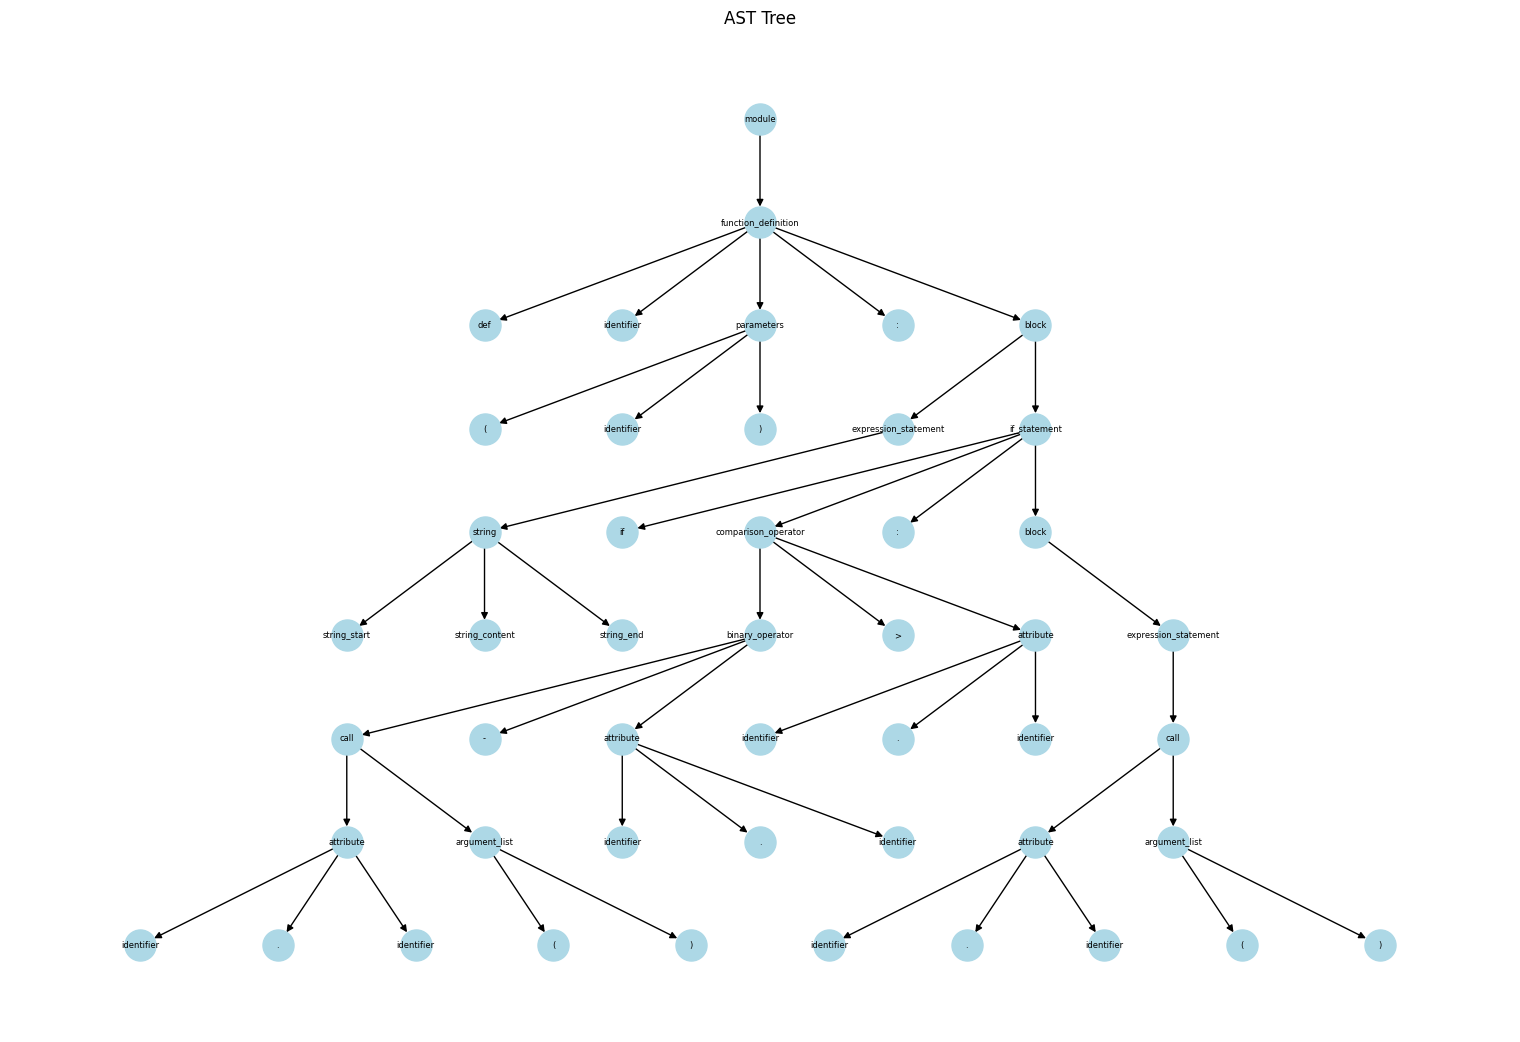

In [38]:


visualize_graph(train_graphs[1], show_labels=True)

